In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
import os

from mvl2 import genData2
from mvl2.infer import *

set_platform('gpu')

import jax
from jax import numpy as jnp
import jax.numpy as jnp
from jax import random, vmap, pmap

import matplotlib.pyplot as plt

import numpy as np

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import optim
from numpyro.infer import SVI, Predictive
from numpyro.infer.autoguide import *
from numpyro.infer.elbo import TraceGraph_ELBO

from IPython.display import set_matplotlib_formats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.stats import norm

from torch import tensor

random_seed = 9939
random_key = random.PRNGKey(random_seed)

Inv_Cumulative_Normal = norm.ppf

plt.style.use('bmh')
if "NUMPYRO_SPHINXBUILD" in os.environ:
    set_matplotlib_formats('svg')

tensor([9.9688e-05, 9.9688e-05, 9.9688e-05, 9.9688e-05], dtype=torch.float64)
mean affects 1 tensor([9.9087e-05, 1.0012e-04, 2.0046e-04, 2.0046e-04], dtype=torch.float64)
std affects 1 tensor([9.7636e-05, 9.8663e-05, 1.9896e-04, 1.9896e-04], dtype=torch.float64)
mean affects 2 tensor([9.7609e-05, 3.0513e-04, 2.0364e-04, 6.2369e-04], dtype=torch.float64)
std affects 2 tensor([9.8568e-05, 3.2026e-04, 2.1182e-04, 6.8415e-04], dtype=torch.float64)
mean affects 3 tensor([9.7954e-05, 3.0005e-04, 1.0002e-04, 3.0005e-04], dtype=torch.float64)
std affects 3 tensor([9.9005e-05, 3.0320e-04, 1.0108e-04, 3.0320e-04], dtype=torch.float64)
[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]


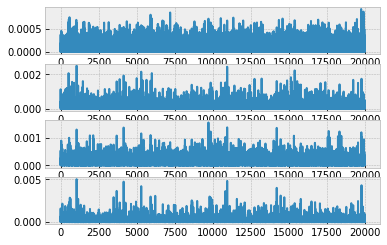

In [3]:
r_p = tensor([[1., 0], [0, 1.]])
r_g = tensor([[1., .5], [.5, 1.]])
v_p = tensor([.05, .05])
h2 = tensor([.9, .9])

popgen_params = genData2.get_popgen_param(h2=h2, v_p=v_p, r_p=r_p, r_g=r_g)

sim_params = {
    "pi": tensor([.1, .1, .05]),
    **popgen_params,
    "RR_mean": tensor([3., 2.]),
    "PV_shape": tensor(1.),
    "PV_mean": tensor(1e-4),
    "PD": tensor([.01, .01]),
    "n_cases": tensor([1.5e4, 1.5e4, 4e3]),
    "n_ctrls": tensor(5e4),
    "fudge_factor": .1
}
sim_data = genData2.gen_counts(**sim_params)
sim_data["PVDs"].mean(0)

print(sim_data["PVDs"][sim_data["unaffected_genes"]].mean(0))
for i in range(len(sim_data["affected_genes"])):
    print(f"mean affects {i + 1}", sim_data["PVDs"][sim_data["affected_genes"][i]].mean(0))
    print(f"std affects {i + 1}", sim_data["PVDs"][sim_data["affected_genes"][i]].std(0))

fig, plts = plt.subplots(sim_data["PVDs"].shape[1])
print(plts)
for i in range(len(plts)):
    plts[i].plot(sim_data["PVDs"][:, i])

In [4]:
random_key, _random_key = random.split(random_key)

run_params = {
    "data": sim_data["alt_counts"].numpy(),
    "max_K": 4,
}

mcmc_rs = run_until_enough(random_key=_random_key, run_params=run_params)

best_chain_rs, statistics_rs = select_best_chain(mcmc_rs)

#best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain])
best_weights_rs, best_probs_rs, _, _ = get_parameters(best_chain_rs)
H_rs, mean_df_rs = get_assumed_order_for_2(best_probs_rs, prevalences=sim_params['PD'], data=run_params['data'])
best_weights_rs, best_probs_rs, best_betas_rs, best_dirichlet_concentrations_rs = ordered_statistics([best_chain_rs], H_rs)

print("best chain's weight mean", best_weights_rs.mean(0))
print("best chain's probs mean", best_probs_rs.mean(0))

sample: 100%|██████████| 6000/6000 [00:45<00:00, 131.48it/s, 15 steps of size 2.44e-01. acc. prob=0.90] 



                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                     beta[0]      0.70      0.02      0.70      0.66      0.73   1283.39      1.00
                     beta[1]      0.18      0.03      0.18      0.13      0.23   1716.60      1.00
                     beta[2]      0.48      0.05      0.48      0.40      0.55   1360.84      1.00
dirichlet_concentration[0,0]      1.81      1.25      1.54      0.09      3.50   4843.18      1.00
dirichlet_concentration[0,1]      0.94      0.74      0.77      0.01      1.93   6861.16      1.00
dirichlet_concentration[0,2]      0.95      0.69      0.80      0.02      1.88   5350.02      1.00
dirichlet_concentration[0,3]      0.51      0.44      0.40      0.00      1.10   6083.12      1.00
dirichlet_concentration[1,0]      1.35      0.91      1.17      0.07      2.60   5001.72      1.00
dirichlet_concentration[1,1]      1.30      1.03      1.05      0.01      2.67   5641.53      1.00
dirichlet

sample: 100%|██████████| 6000/6000 [00:49<00:00, 121.56it/s, 31 steps of size 2.13e-01. acc. prob=0.93] 



                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                     beta[0]      0.12      0.02      0.12      0.09      0.16   1330.82      1.00
                     beta[1]      0.06      0.01      0.06      0.05      0.07   1476.48      1.00
                     beta[2]      0.84      0.01      0.84      0.83      0.86   1598.25      1.00
dirichlet_concentration[0,0]      1.63      1.11      1.41      0.07      3.11   4685.32      1.00
dirichlet_concentration[0,1]      0.89      0.68      0.74      0.01      1.79   4586.12      1.00
dirichlet_concentration[0,2]      1.23      0.92      1.03      0.04      2.44   5029.66      1.00
dirichlet_concentration[0,3]      0.60      0.51      0.47      0.00      1.29   4256.28      1.00
dirichlet_concentration[1,0]      1.33      0.90      1.15      0.08      2.61   4089.08      1.00
dirichlet_concentration[1,1]      1.30      1.00      1.05      0.01      2.64   4971.01      1.00
dirichlet

  0%|          | 0/6000 [00:00<?, ?it/s]

weights.mean(0) [0.12397123 0.05417011 0.6935385  0.12831911]
probs.mean(0) [[0.4774459  0.1556535  0.29358342 0.07331721]
 [0.3037423  0.31210446 0.21071702 0.17343627]
 [0.6011463  0.17412491 0.17652453 0.04820437]
 [0.4085542  0.369998   0.12545225 0.0959956 ]]


sample: 100%|██████████| 6000/6000 [00:46<00:00, 128.94it/s, 15 steps of size 2.42e-01. acc. prob=0.91]



                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                     beta[0]      0.13      0.01      0.13      0.11      0.14   2123.56      1.00
                     beta[1]      0.80      0.02      0.81      0.76      0.84   1395.46      1.00
                     beta[2]      0.32      0.05      0.32      0.24      0.40   1424.41      1.00
dirichlet_concentration[0,0]      1.53      1.02      1.32      0.05      2.92   5362.19      1.00
dirichlet_concentration[0,1]      1.42      1.10      1.17      0.03      2.88   5289.97      1.00
dirichlet_concentration[0,2]      0.85      0.63      0.70      0.05      1.70   5394.36      1.00
dirichlet_concentration[0,3]      0.70      0.59      0.54      0.00      1.54   6107.63      1.00
dirichlet_concentration[1,0]      1.82      1.21      1.55      0.10      3.53   5874.59      1.00
dirichlet_concentration[1,1]      0.92      0.69      0.76      0.02      1.88   5391.63      1.00
dirichlet

  0%|          | 0/6000 [00:00<?, ?it/s]

weights.mean(0) [0.12884633 0.7001794  0.05394251 0.11703204]
probs.mean(0) [[0.40853742 0.369723   0.1256992  0.09604046]
 [0.6004479  0.17405097 0.1771501  0.04835111]
 [0.30362797 0.31176552 0.21100585 0.17360069]
 [0.47475982 0.15500014 0.2965595  0.07368059]]


sample: 100%|██████████| 6000/6000 [00:48<00:00, 124.08it/s, 15 steps of size 2.50e-01. acc. prob=0.89] 



                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                     beta[0]      0.70      0.02      0.70      0.66      0.73   1162.88      1.00
                     beta[1]      0.40      0.04      0.40      0.33      0.47   1216.22      1.00
                     beta[2]      0.71      0.04      0.71      0.64      0.77   2012.48      1.00
dirichlet_concentration[0,0]      1.78      1.19      1.53      0.12      3.45   6157.23      1.00
dirichlet_concentration[0,1]      0.92      0.72      0.72      0.01      1.90   6559.64      1.00
dirichlet_concentration[0,2]      0.94      0.70      0.78      0.01      1.88   6530.39      1.00
dirichlet_concentration[0,3]      0.51      0.42      0.39      0.00      1.07   6396.40      1.00
dirichlet_concentration[1,0]      1.62      1.10      1.39      0.08      3.20   5697.04      1.00
dirichlet_concentration[1,1]      0.88      0.68      0.72      0.01      1.82   6376.55      1.00
dirichlet

In [5]:
random_key, _random_key = random.split(random_key)

run_params_shared_prior = run_params.copy()
run_params_shared_prior["shared_dirichlet_prior"] = True

mcmc_rs_simple = run_until_enough(random_key=_random_key, run_params=run_params_shared_prior)

best_chain_rs_simple, statistics_rs_simple = select_best_chain(mcmc_rs_simple)
display(statistics_rs_simple)

#best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain])
best_weights_rs_simple, best_probs_rs_simple, _, _ = get_parameters(best_chain_rs_simple)
H_rs_simple, mean_df_rs_simple = get_assumed_order_for_2(best_probs_rs_simple, prevalences=sim_params['PD'], data=run_params['data'])
best_weights_rs_simple, best_probs_rs_simple, best_betas_rs_simple, best_dirichlet_concentrations_rs_simple = ordered_statistics([best_chain_rs_simple], H_rs_simple)

display(mean_df_rs_simple)
print("best chain's weight mean", best_weights_rs_simple.mean(0))
print("best chain's probs mean", best_probs_rs_simple.mean(0))

sample: 100%|██████████| 6000/6000 [00:41<00:00, 144.48it/s, 15 steps of size 2.42e-01. acc. prob=0.92]



                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.12      0.02      0.12      0.09      0.16   1559.07      1.00
                   beta[1]      0.15      0.01      0.15      0.13      0.17   1925.64      1.01
                   beta[2]      0.93      0.01      0.93      0.92      0.94   2147.96      1.00
dirichlet_concentration[0]      3.09      1.28      2.95      1.07      5.04   2739.02      1.00
dirichlet_concentration[1]      1.94      0.84      1.83      0.64      3.20   2996.15      1.00
dirichlet_concentration[2]      1.68      0.72      1.59      0.55      2.77   2760.17      1.00
dirichlet_concentration[3]      1.00      0.46      0.93      0.25      1.66   3814.26      1.00
                probs[0,0]      0.48      0.01      0.48      0.46      0.50   2138.59      1.00
                probs[0,1]      0.16      0.01      0.16      0.15      0.17   4169.55      1.00
                probs[0,2]   

  0%|          | 0/6000 [00:00<?, ?it/s]

weights.mean(0) [0.12453873 0.1300562  0.6924726  0.05293299]
probs.mean(0) [[0.47735098 0.15592231 0.2934452  0.07328154]
 [0.40858772 0.3692142  0.1260771  0.09612099]
 [0.60129297 0.17403638 0.17647648 0.04819417]
 [0.30292872 0.31174558 0.2111831  0.17414258]]


sample: 100%|██████████| 6000/6000 [00:41<00:00, 146.11it/s, 31 steps of size 2.34e-01. acc. prob=0.92]



                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.13      0.02      0.12      0.09      0.16   1344.12      1.00
                   beta[1]      0.15      0.01      0.15      0.13      0.17   1788.07      1.00
                   beta[2]      0.93      0.01      0.93      0.92      0.94   1643.41      1.00
dirichlet_concentration[0]      3.11      1.29      2.94      1.16      5.13   2933.61      1.00
dirichlet_concentration[1]      1.97      0.86      1.85      0.68      3.36   3232.36      1.00
dirichlet_concentration[2]      1.69      0.73      1.58      0.51      2.75   3061.53      1.00
dirichlet_concentration[3]      1.01      0.46      0.94      0.31      1.72   3552.81      1.00
                probs[0,0]      0.48      0.01      0.48      0.46      0.49   2019.02      1.00
                probs[0,1]      0.16      0.01      0.16      0.15      0.17   4082.97      1.00
                probs[0,2]   

  0%|          | 0/6000 [00:00<?, ?it/s]

weights.mean(0) [0.12529597 0.12985566 0.69195235 0.05289524]
probs.mean(0) [[0.47744888 0.15601885 0.2932067  0.0733256 ]
 [0.4084801  0.3693666  0.12603018 0.09612311]
 [0.60132843 0.17407191 0.17641586 0.04818387]
 [0.30286515 0.31191853 0.21094626 0.17427006]]


sample: 100%|██████████| 6000/6000 [00:38<00:00, 157.27it/s, 7 steps of size 2.79e-01. acc. prob=0.89] 



                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.12      0.02      0.12      0.09      0.16   1727.68      1.00
                   beta[1]      0.15      0.01      0.15      0.13      0.17   2163.87      1.00
                   beta[2]      0.07      0.01      0.07      0.06      0.09   1658.22      1.00
dirichlet_concentration[0]      3.09      1.28      2.92      0.97      4.93   3162.57      1.00
dirichlet_concentration[1]      1.93      0.84      1.80      0.60      3.20   3394.40      1.00
dirichlet_concentration[2]      1.66      0.70      1.57      0.56      2.72   3139.58      1.00
dirichlet_concentration[3]      0.99      0.44      0.93      0.31      1.67   4376.73      1.00
                probs[0,0]      0.48      0.01      0.48      0.46      0.50   2287.70      1.00
                probs[0,1]      0.16      0.01      0.16      0.15      0.17   4303.73      1.00
                probs[0,2]   

  0%|          | 0/6000 [00:00<?, ?it/s]

weights.mean(0) [0.12479217 0.12939446 0.05363111 0.69218224]
probs.mean(0) [[0.4775879  0.15576185 0.29340133 0.07324895]
 [0.40858838 0.36946595 0.1259002  0.09604553]
 [0.3033534  0.31157917 0.21114479 0.1739227 ]
 [0.6012928  0.17411064 0.17641671 0.04817991]]


sample: 100%|██████████| 6000/6000 [00:39<00:00, 150.61it/s, 15 steps of size 2.43e-01. acc. prob=0.91]



                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.70      0.02      0.70      0.67      0.73   1469.39      1.00
                   beta[1]      0.18      0.03      0.18      0.14      0.23   1670.47      1.00
                   beta[2]      0.53      0.05      0.53      0.45      0.60   1513.76      1.00
dirichlet_concentration[0]      3.03      1.22      2.87      1.12      4.94   3206.07      1.00
dirichlet_concentration[1]      1.91      0.81      1.81      0.60      3.14   3594.54      1.00
dirichlet_concentration[2]      1.65      0.70      1.56      0.57      2.74   3703.50      1.00
dirichlet_concentration[3]      0.98      0.44      0.92      0.33      1.69   3966.21      1.00
                probs[0,0]      0.60      0.00      0.60      0.60      0.60   1904.77      1.00
                probs[0,1]      0.17      0.00      0.17      0.17      0.18   4093.22      1.00
                probs[0,2]   

,diverging,accept_prob_mean,accept_prob_std,potential_energy,mcmc_index
1,0.0,0.924423,0.080511,436522.34375,1.0
0,0.0,0.918741,0.085968,436523.43750,0.0
3,0.0,0.908514,0.095672,436517.34375,3.0
2,0.0,0.894246,0.107227,436528.59375,2.0


,"P(~D|V,H)","P(D1|V,H)","P(D2|V,H)","P(D12|V,H)"
H2,0.477351,0.155922,0.293445,0.073282
H1,0.408588,0.369214,0.126077,0.096121
H0,0.601293,0.174036,0.176476,0.048194
H12,0.302929,0.311746,0.211183,0.174143


best chain's weight mean [0.6924726  0.1300562  0.12453873 0.05293299]
best chain's probs mean [[0.60129327 0.1740363  0.17647657 0.04819423]
 [0.40858772 0.36921415 0.12607703 0.09612115]
 [0.47735083 0.1559223  0.29344514 0.07328141]
 [0.30292875 0.31174564 0.21118315 0.17414255]]


In [13]:
!cat sim/simulations/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.1_pi2_0.1_pi12_0.1_h2_1_0.2_h2_2_0.2_rho_0/results.csv.ss

Args are: Prev_Disorder1,Prev_Disorder2,Sample_Size,No_Genes,Mean_Rare_Freq_Per_Gene,FractionGenes1_only,FractionGenes2_only,FractionBoth,Rare_h2_1,rare_h2_2,rho,outfile
Args val: 0.02,0.02,200000,20000,0.0001,0.1,0.1,0.1,0.2,0.2,0,pd1_0.02_pd2_0.02_af_1e-4_pi1_0.1_pi2_0.1_pi12_0.1_h2_1_0.2_h2_2_0.2_rho_0/results.csv

 Disorder 0 has a prev = 0.02 and thres = 2.0541885887219 

 Disorder 1 has a prev = 0.02 and thres = 2.0541885887219 

 h2[0] = 0.2  h2[1] =0.2   rho = 0 

 Stupid_sum[0] = -6.53466991629159e-09   and stupid_sum[1] = 4.86649298636621e-09 

 Before normalization total variances were 0.861577101783085 and 0.83324292185757 

Normalizing by 0.481801251489393

 For disorder 0 we expected a prevalence of 0.02 and got 0.022515 with 4503 out of 200000

 Genetic mean liability  = 6.00374749915034e-16 Genetic Variance in Liabilty = 0.8578363607211
 Residual mean liability  = 0.00185293055314494 Residual Variance in Liabilty = 3.45258459054147
 Total mean liability  = 8.76720918085

In [3]:
import pandas as pd
import numpy as np
df = pd.read_csv('sim/simulations/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.1_pi2_0.1_pi12_0.1_h2_1_0.2_h2_2_0.2_rho_0/results.csv')

#df = pd.read_csv('/home/akotlar/tada/project/sim/test_dave3.csv')
pds = np.array([0.022515,0.02302,0.001295])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave = {
    "data": stat_data_dave,
    "max_K": 4,
}

# Our best performing model; fits like a champ even challening simulations
random_key, _random_key = random.split(random_key)

mcmc_dave_2k_8k_gamma8 = run_until_enough(random_key=_random_key, run_params=run_params_dave)
best_chain, statistics = select_best_chain(mcmc_dave_2k_8k_gamma8)
display(statistics)
del mcmc_dave_2k_8k_gamma8

#best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain])
best_weights, best_probs, _, _ = get_parameters(best_chain)
H, mean_df = get_assumed_order_for_2(best_probs, data_columns=['unaffected', 'affected2', 'affected1', 'affected12'], data=stat_data_dave, prevalences=pds)
best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain], order=H)

best_probs_mean_across_mcmc_samples = np.array(best_probs.mean(0))
best_weights_mean_across_mcmc_samples = np.array(best_weights.mean(0))

display('best_probs sample mean', best_probs.mean(0))
display('best_weights sample mean', best_weights.mean(0))

display(mean_df)

alpha 0.0125


sample: 100%|██████████| 6000/6000 [01:58<00:00, 50.81it/s, 63 steps of size 5.65e-02. acc. prob=0.91]  



                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                     beta[0]      0.05      0.02      0.05      0.02      0.08    669.14      1.00
                     beta[1]      0.12      0.02      0.12      0.09      0.15   1124.24      1.00
                     beta[2]      0.90      0.02      0.90      0.87      0.92    993.45      1.00
dirichlet_concentration[0,0]      6.20      1.03      6.17      4.56      7.84   5136.86      1.00
dirichlet_concentration[0,1]      0.51      0.36      0.44      0.02      1.01   4094.64      1.00
dirichlet_concentration[0,2]      0.87      0.56      0.75      0.06      1.66   5177.88      1.00
dirichlet_concentration[0,3]      0.21      0.21      0.15      0.00      0.50   2732.41      1.00
dirichlet_concentration[1,0]      6.20      1.01      6.13      4.56      7.82   6246.67      1.00
dirichlet_concentration[1,1]      0.89      0.60      0.77      0.04      1.73   7246.25      1.00
dirichlet

sample: 100%|██████████| 6000/6000 [01:49<00:00, 55.01it/s, 63 steps of size 7.13e-02. acc. prob=0.86] 



                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                     beta[0]      0.11      0.02      0.11      0.08      0.14   1447.22      1.00
                     beta[1]      0.05      0.02      0.05      0.02      0.08    578.73      1.00
                     beta[2]      0.90      0.02      0.90      0.87      0.92    847.51      1.00
dirichlet_concentration[0,0]      6.22      1.03      6.16      4.59      7.97   5570.28      1.00
dirichlet_concentration[0,1]      0.87      0.58      0.76      0.02      1.65   6759.63      1.00
dirichlet_concentration[0,2]      0.64      0.43      0.56      0.02      1.22   6112.12      1.00
dirichlet_concentration[0,3]      0.30      0.28      0.22      0.00      0.67   5755.69      1.00
dirichlet_concentration[1,0]      6.20      1.01      6.15      4.59      7.84   5038.04      1.00
dirichlet_concentration[1,1]      0.49      0.35      0.41      0.01      0.95   1379.92      1.00
dirichlet

  0%|          | 0/6000 [00:00<?, ?it/s]

weights.mean(0) [0.11372047 0.04709987 0.7523526  0.08682556]
probs.mean(0) [[0.90484405 0.06564475 0.02495023 0.00456104]
 [0.92240506 0.01031614 0.06590907 0.00136966]
 [0.9543742  0.02248554 0.02174232 0.00139794]
 [0.87912416 0.04613409 0.06750754 0.00723429]]
alpha 0.0125


sample: 100%|██████████| 6000/6000 [01:44<00:00, 57.68it/s, 31 steps of size 9.66e-02. acc. prob=0.74] 



                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                     beta[0]      0.09      0.01      0.09      0.07      0.11    440.18      1.00
                     beta[1]      0.12      0.02      0.12      0.10      0.15    725.95      1.00
                     beta[2]      0.95      0.02      0.96      0.93      0.98    216.07      1.00
dirichlet_concentration[0,0]      6.21      1.02      6.15      4.69      8.00   2867.39      1.00
dirichlet_concentration[0,1]      0.78      0.51      0.68      0.04      1.47   3417.63      1.00
dirichlet_concentration[0,2]      0.90      0.58      0.79      0.04      1.69   3094.09      1.00
dirichlet_concentration[0,3]      0.33      0.30      0.24      0.00      0.74   3971.85      1.00
dirichlet_concentration[1,0]      6.21      1.01      6.13      4.63      7.91   2366.60      1.00
dirichlet_concentration[1,1]      0.87      0.60      0.75      0.06      1.71   2687.74      1.00
dirichlet

  0%|          | 0/6000 [00:00<?, ?it/s]

weights.mean(0) [0.09314907 0.11176312 0.7584252  0.03666222]
probs.mean(0) [[0.88101286 0.04467894 0.06733318 0.0069751 ]
 [0.90445954 0.06613015 0.02481817 0.00459222]
 [0.9542541  0.022461   0.02188518 0.00139979]
 [0.9230583  0.00779904 0.06807651 0.00106626]]
alpha 0.0125


sample: 100%|██████████| 6000/6000 [06:11<00:00, 16.14it/s, 255 steps of size 1.37e-02. acc. prob=0.87] 



                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                     beta[0]      0.75      0.02      0.76      0.73      0.79    890.44      1.00
                     beta[1]      0.19      0.06      0.19      0.09      0.29    528.76      1.00
                     beta[2]      0.57      0.07      0.56      0.45      0.68    934.87      1.00
dirichlet_concentration[0,0]      6.23      1.01      6.18      4.69      7.96   5470.86      1.00
dirichlet_concentration[0,1]      0.62      0.43      0.53      0.03      1.20   4273.05      1.00
dirichlet_concentration[0,2]      0.61      0.43      0.52      0.03      1.19   4587.09      1.00
dirichlet_concentration[0,3]      0.23      0.21      0.17      0.00      0.50   6364.20      1.00
dirichlet_concentration[1,0]      6.20      1.01      6.14      4.55      7.80   4736.88      1.00
dirichlet_concentration[1,1]      0.51      0.37      0.42      0.02      1.03   4028.63      1.00
dirichlet

,diverging,accept_prob_mean,accept_prob_std,potential_energy,mcmc_index
0,0.0,0.914653,0.087385,2282795.75,0.0
1,2.0,0.861838,0.160590,2282794.00,1.0
3,6.0,0.874988,0.159075,2282784.00,3.0
2,23.0,0.740378,0.272986,2282791.50,2.0


'best_probs sample mean'

array([[0.95439744, 0.02247582, 0.02172822, 0.00139874],
       [0.9218995 , 0.01086437, 0.06580164, 0.00143553],
       [0.9049661 , 0.06551515, 0.02497207, 0.00454515],
       [0.87880987, 0.04645494, 0.06743748, 0.00729677]], dtype=float32)

'best_weights sample mean'

array([0.7514285 , 0.04869304, 0.114302  , 0.08557676], dtype=float32)

,"P(~D|V,H)","P(D2|V,H)","P(D1|V,H)","P(D12|V,H)"
H1,0.921898,0.010864,0.065802,0.001436
H2,0.904968,0.065515,0.024972,0.004545
H0,0.954397,0.022476,0.021728,0.001399
H12,0.878811,0.046455,0.067438,0.007297


In [28]:
1.8490571e-01 / 3.2717872e-02

5.651520062184973

In [10]:
stat_data_dave.sum(1).reshape(20_000,1)

array([[32],
       [31],
       [51],
       ...,
       [31],
       [36],
       [48]])

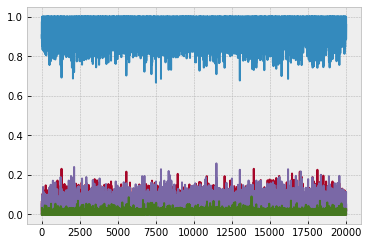

In [11]:
plt.plot(stat_data_dave/stat_data_dave.sum(1).reshape(20_000,1))

In [ ]:
run_params_dave_simple = {
    "data": stat_data_dave,
    "max_K": 4,
    'shared_dirichlet_prior': True
}

# Our best performing model; fits like a champ even challening simulations
random_key, _random_key = random.split(random_key)

mcmc_dave_2k_8k_gamma8_simple = run_until_enough(random_key=_random_key, run_params=run_params_dave_simple)
best_chain_simple, statistics_simple = select_best_chain(mcmc_dave_2k_8k_gamma8_simple)
display(statistics_simple)
del mcmc_dave_2k_8k_gamma8_simple

#best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain])
best_weights_simple, best_probs_simple, _, _ = get_parameters(best_chain_simple)
H_simple, mean_df_simple = get_assumed_order_for_2(best_probs_simple, data_columns=['unaffected', 'affected2', 'affected1', 'affected12'], data=stat_data_dave, prevalences=pds)
best_weights_simple, best_probs_simple, best_betas_simple, best_dirichlet_concentrations_simple = ordered_statistics([best_chain_simple], order=H_simple)

display('best_probs sample mean',best_probs_simple.mean(0))
display('best_weights sample mean', best_weights_simple.mean(0))

display(mean_df)

In [ ]:
run_params_dave_simple = {
    "data": stat_data_dave,
    "max_K": 4,
    'shared_dirichlet_prior': False
}

# Our best performing model; fits like a champ even challening simulations
random_key, _random_key = random.split(random_key)

mcmc_dave_2k_8k_gamma8_simple = run_until_enough(random_key=_random_key, run_params=run_params_dave_simple)
best_chain_simple, statistics_simple = select_best_chain(mcmc_dave_2k_8k_gamma8_simple)
display(statistics_simple)
del mcmc_dave_2k_8k_gamma8_simple

#best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain])
best_weights_simple, best_probs_simple, _, _ = get_parameters(best_chain_simple)
H_simple, mean_df_simple = get_assumed_order_for_2(best_probs_simple, data_columns=['unaffected', 'affected2', 'affected1', 'affected12'], data=stat_data_dave, prevalences=pds)
best_weights_simple, best_probs_simple, best_betas_simple, best_dirichlet_concentrations_simple = ordered_statistics([best_chain_simple], order=H_simple)

display('best_probs sample mean',best_probs_simple.mean(0))
display('best_weights sample mean', best_weights_simple.mean(0))

display(mean_df)

In [ ]:
best_weights, best_probs, _, _ = get_parameters(best_chain)
H, mean_df = get_assumed_order_for_2(best_probs, data_columns=['unaffected', 'affected2', 'affected1', 'affected12'])
best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain], order=H)

best_probs_mean_across_mcmc_samples = np.array(best_probs.mean(0))
best_weights_mean_across_mcmc_samples = np.array(best_weights.mean(0))

display('best_probs sample mean',best_probs_mean_across_mcmc_samples)
display('best_weights sample mean', best_weights_mean_across_mcmc_samples)

display(mean_df)

In [ ]:
H_based_on_pis = [0,3,2,1]
print("H", H)
print("H_based_on_pis", H_based_on_pis)

print("best_weights.mean(0)", best_weights.mean(0))

print("best_weights.mean(0)[H]", best_weights.mean(0)[H])

print("best_weights.mean(0)[H_based_on_pis]", best_weights.mean(0)[H_based_on_pis])

print("\nbest_probs.mean(0)", best_probs.mean(0))
print("best_probs.mean(0)[H]", best_probs.mean(0)[H])
print("best_probs.mean(0)[H_based_on_pis]", best_probs.mean(0)[H_based_on_pis])

PD_V_H_P_H_across_samples = np.multiply(best_probs, best_weights.reshape(*best_weights.shape,1))

PD_V_H_P_H_mean = PD_V_H_P_H_across_samples.mean(0)
print("\nPD_V_H_P_H_mean", PD_V_H_P_H_mean)
print("ordered PD|Vs based on H", PD_V_H_P_H_mean[H])
print("ordered PD|Vs based on H_based_on_pis", PD_V_H_P_H_mean[H_based_on_pis])
        
PD_V = PD_V_H_P_H_mean[H_based_on_pis].sum(1)
display("PD|V", PD_V)
PD = np.array([0.022515,0.02302,0.001295])
PV = q = 1e-4

rr = PD_V[1:4]/PD
display("rr",rr)

In [ ]:
df.sum(1)

In [ ]:
(df['Per_Gene_Counts_Unaffected_Unaffected'] / df.sum(1)).mean(0)

In [ ]:
(df['Affected_Unaffected'] / df.sum(1)).mean(0)

In [ ]:
(df['Unaffected_Affected'] / df.sum(1)).mean(0)

In [ ]:
(df['Affected_Affected'] / df.sum(1)).mean(0)

In [ ]:
df['Affected_Unaffected'].mean(0)

In [ ]:
df['Affected_Affected'].mean(0)

In [ ]:
P_D1_A1 = PD_V[1]
P_D2_A1 = PD_V[2]
print("P_D1_A1", P_D1_A1)
print("P_D2_A1", P_D2_A1)
q = 1e-4
p = 1-q

#Final Observed Prevalences for this study are (Disorder1,Disorder2,Both) = 0.022515,0.02302,0.001295
prevalence_d1 = PD[0]#.02
prevalence_d2 = PD[0] #.02
thresh1 = Inv_Cumulative_Normal(PD[1])
thresh2 = Inv_Cumulative_Normal(prevalence_d2)
print(f"thresh1: {thresh1}, thresh2: {thresh2}")

alpha1_D1 = thresh1 - Inv_Cumulative_Normal( 1- P_D1_A1)
alpha1_D2 = thresh2 - Inv_Cumulative_Normal( 1- P_D2_A1)

alpha2_D1 = -p*alpha1_D1/q
alpha2_D2 = -p*alpha1_D2/q

variance_D1 = 2*(p*(alpha1_D1**2) + q * (alpha2_D1**2))
variance_D2 = 2*(p*(alpha1_D2**2) + q * (alpha2_D2**2))
print(f"alpha2_D1: {alpha2_D1}, alpha2_D2: {alpha2_D2}")
print(f"variance_D1: {variance_D1}, variance_D2: {variance_D2}")

cov = 2*(p*alpha1_D1*alpha1_D2 + q*alpha2_D1*alpha2_D2)
print(f"cov: {cov}")

rho = cov / ((variance_D1*variance_D2)**.5)
print(f"rho: {rho}")

In [ ]:
# For a locus with two alleles, A1 and A2, with frequencies p and q.

# alpha1 = (Freq(A1A1) * Average(Phenotype of A1A1 individuals) +
# 1/2 *Freq(A1A2) * Average(Phenotype of A1A2 individuals) ) / p

# alpha2 = -p * alpha1 /q

# For case control data, if the prevalence of disease is Pv, then
# the threshold on the liability scale is

# thres =  Inv_Cumulatative_Normal( 1 - Pv)

# If the penetrance of A1 is P{D | A1}. then 

# alpha1 = thres - Inv_Cumulative_Normal( 1- P{D | A1})

# i..e alpha1 is the mean liability of individuals with an A1 allele.

# alpha2 = -p*alpha / q

# Va due to the locus is 2*(p*alpha1^2 + q*alpha2)

# Of course, with two phenotypes you can calculate the alphas independently
# for the two traits based on the penetrance of the A1 allele for both traits.

# For your problem, we can think of A1 is the collection of a bunch of 
# rare alleles....

P_D_V = PD_V[1:4].sum()
thres =  Inv_Cumulatative_Normal( 1 - Pv)


In [ ]:
def plot_regression(x, y_mean, y_hpdi):
    print(x.shape)
    # Sort values for plotting by x axis
    # idx = jnp.argsort(x)
    # marriage = x[idx]
    ctrls = stat_data_dave[:, 0]
    print('ctrls.shape', ctrls.shape)
    case1 = stat_data_dave[:, 1]
    case2 = stat_data_dave[:, 2]
    caseBoth  = stat_data_dave[:, 3]
    
    
    meanCtrls = y_mean[:, 0]
    print('meanCtrls.shape', meanCtrls.shape)
    print("y_hpdi.shape", y_hpdi.shape)
    meanCtrls = y_mean[:, 1]
    meanCtrls = y_mean[:, 2]
    meanCtrls = y_mean[:, 3]
    hpdiCtrls = y_hpdi[:, 0]
    hpdiCases1 = y_hpdi[:, 1]
    hpdiCases2 = y_hpdi[:, 2]
    hpdiCasesBoth = y_hpdi[:, 3]

    # Plot
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6, 6))
    ax.plot(ctrls, meanCtrls)
    ax.plot(marriage, divorce, "o")
    ax.fill_between(marriage, hpdi[0], hpdi[1], alpha=0.3, interpolate=True)
    return ax

random_key, _random_key = random.split(random_key)
t = best_chain.get_samples()
# test = {
#     'beta': t['beta'][0,:],
#     'dirichlet_concentration': t['dirichlet_concentration'][0,:],
#     'probs': t['probs'][0,:]}

prior_predictive = Predictive(model, num_samples=100)
prior_predictions = prior_predictive(_random_key, stat_data_dave,n_cases,n_ctrls,4)[
    "obs"
]
mean_prior_pred = jnp.mean(prior_predictions, axis=0)
hpdi_prior_pred = hpdi(prior_predictions, 0.9)
ax = plot_regression(stat_data_dave, mean_prior_pred, hpdi_prior_pred)
ax.set(xlabel="Obs", ylabel="Divorce rate", title="Predictions with 90% CI");
# predictive = Predictive(model_with_gamma_prior_alpha8, t)


# samples_predictive = predictive(random.PRNGKey(1), stat_data_dave,n_cases,n_ctrls,4)

# mean_prior_pred = jnp.mean(samples_predictive, axis=0)
# hpdi_prior_pred = hpdi(prior_predictions, 0.9)
# # display(samples_predictive['z'].mean(0)[0:100])
# pd.DataFrame(np.array(samples_predictive['z'])[0], columns=['z']).to_csv("z_pred.tsv", sep='\t')
# display(np.array(samples_predictive['z'])[0:3])
# display(np.array(samples_predictive['obs'])[1999])
# posterior_samples = best_chain.get_samples()
# predictive = Predictive(model, posterior_samples=posterior_samples)
# samples = predictive(_random_key, *model_args)
# print(samples)

# weights, probs, betas, dirichlet_concentrations = ordered_statistics([best_chain])

# assumed_h0, assumed_h1, assumed_h2, assumed_h12, mean_df = get_assumed_order_for_2(best_probs, best_weights)
# display(mean_df)

# PD_V_H_P_H_across_samples = np.multiply(probs, weights.reshape(*weights.shape,1))


# PD_V_H_P_H_mean = PD_V_H_P_H_across_samples.mean(0)[np.array([assumed_h0, assumed_h1, assumed_h2, assumed_h12])]

# PD_V = PD_V_H_P_H_mean.sum(1)

# rr = PD_V[1:4]/PD
# display(rr)

In [ ]:
from numpyro.infer.util import Predictive
PD = np.array([0.022515,0.02302,0.001295])
PV = q = 1e-4
model_args = [run_params_dave['data'], run_params_dave['n_cases'], run_params_dave['n_ctrls'], run_params_dave['max_K']]
i = 0
while i < 20_000:
    i += 1
    
    random_key, _random_key = random.split(random_key)
    predictive = Predictive(new_school, best_chain.get_samples())
    samples_predictive = predictive(random.PRNGKey(1))
    print(np.mean(samples_predictive['obs'])) 
    posterior_samples = best_chain.get_samples()
    predictive = Predictive(model, posterior_samples=posterior_samples)
    samples = predictive(_random_key, *model_args)
    print(samples)

    weights, probs, betas, dirichlet_concentrations = ordered_statistics([best_chain])
    
    assumed_h0, assumed_h1, assumed_h2, assumed_h12, mean_df = get_assumed_order_for_2(best_probs, best_weights)
    display(mean_df)
    
    PD_V_H_P_H_across_samples = np.multiply(probs, weights.reshape(*weights.shape,1))
    

    PD_V_H_P_H_mean = PD_V_H_P_H_across_samples.mean(0)[np.array([assumed_h0, assumed_h1, assumed_h2, assumed_h12])]

    PD_V = PD_V_H_P_H_mean.sum(1)

    rr = PD_V[1:4]/PD
    display(rr)
    
    if i > 5:
        break

    # For a locus with two alleles, A1 and A2, with frequencies p and q.

    # alpha1 = (Freq(A1A1) * Average(Phenotype of A1A1 individuals) +
    # 1/2 *Freq(A1A2) * Average(Phenotype of A1A2 individuals) ) / p

    # alpha2 = -p * alpha1 /q

    # For case control data, if the prevalence of disease is Pv, then
    # the threshold on the liability scale is

    # thres =  Inv_Cumulatative_Normal( 1 - Pv)

    # If the penetrance of A1 is P{D | A1}. then 

    # alpha1 = thres - Inv_Cumulative_Normal( 1- P{D | A1})

    # i..e alpha1 is the mean liability of individuals with an A1 allele.

    # alpha2 = -p*alpha / q

    # Va due to the locus is 2*(p*alpha1^2 + q*alpha2)

    # Of course, with two phenotypes you can calculate the alphas independently
    # for the two traits based on the penetrance of the A1 allele for both traits.

    # For your problem, we can think of A1 is the collection of a bunch of 
    # rare alleles....

    # Assuming alpha is our rare allele marginal sums (per gene), across all samples:
#     P_D1_A1 = PD_V[1]
#     P_D2_A1 = PD_V[2]
#     print("P_D1_A1", P_D1_A1)
#     print("P_D2_A1", P_D2_A1)
#     q = 1e-4
#     p = 1-q

#     #Final Observed Prevalences for this study are (Disorder1,Disorder2,Both) = 0.022515,0.02302,0.001295
#     prevalence_d1 = PD[0]#.02
#     prevalence_d2 = PD[0] #.02
#     thresh1 = Inv_Cumulative_Normal(PD[1])
#     thresh2 = Inv_Cumulative_Normal(prevalence_d2)
#     print(f"thresh1: {thresh1}, thresh2: {thresh2}")

#     alpha1_D1 = thresh1 - Inv_Cumulative_Normal( 1- P_D1_A1)
#     alpha1_D2 = thresh2 - Inv_Cumulative_Normal( 1- P_D2_A1)

#     alpha2_D1 = -p*alpha1_D1/q
#     alpha2_D2 = -p*alpha1_D2/q

#     variance_D1 = 2*(p*(alpha1_D1**2) + q * (alpha2_D1**2))
#     variance_D2 = 2*(p*(alpha1_D2**2) + q * (alpha2_D2**2))
#     print(f"alpha2_D1: {alpha2_D1}, alpha2_D2: {alpha2_D2}")
#     print(f"variance_D1: {variance_D1}, variance_D2: {variance_D2}")

#     cov = 2*(p*alpha1_D1*alpha1_D2 + q*alpha2_D1*alpha2_D2)
#     print(f"cov: {cov}")

#     rho = cov / ((variance_D1*variance_D2)**.5)
#     print(f"rho: {rho}")
#     break

In [ ]:
!cat sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.1_pi2_0.1_pi12_0.1_h2_1_0.2_h2_2_0.2_rho_0/results.csv.ss

In [ ]:
# random_key, _random_key = random.split(random_key)
#P(H0|D) = P(D|H0)P(H0)
H0_posterior = (best_weights[0][:,assumed_h0] @ best_probs[0][:,assumed_h0]).mean(0).mean(0)
#P(H1|D) = P(D|H1)P(H1)


best_weights[0][:,assumed_h0].mean()

In [ ]:
plt.plot(best_chain.get_extra_fields()['potential_energy'])

In [ ]:
######### Using new dave program ############

In [4]:
df_exp3 = pd.read_csv('sim/test_new_steez')
df_exp3

,Per_Gene_Counts_Unaffected_Unaffected,Unaffected_Affected,Affected_Unaffected,Affected_Affected
0,35,5,0,0
1,37,0,0,0
2,33,0,3,0
3,41,0,1,1
4,25,2,1,0
...,...,...,...,...
19995,28,0,2,0
19996,40,2,3,0
19997,40,0,2,1
19998,39,1,2,0


In [2]:
import pandas as pd
import numpy as np

df_exp_ns = pd.read_csv('sim/test_new_steez')
display(df_exp_ns)
df_exp_ns_data = df_exp_ns.to_numpy()
display('df_exp_ns_data', df_exp_ns_data)

cheats_exp_ns= pd.read_csv('sim/test_new_steez.cheat.txt', sep='\t')
df_exp_ns_genetic_architectures = cheats_exp_ns['Model_No'].to_numpy()
display(cheats_exp_ns)
display('df_exp_ns_genetic_architectures', df_exp_ns_genetic_architectures)


# Our best performing model; fits like a champ even challening simulations
random_key, _random_key = random.split(random_key)

res_exp_ns = run_until_enough(random_key=_random_key, target_number_of_chains=1, run_params={
    "data": df_exp_ns_data,
    "max_K": 4,
})
best_chain_exp_ns, statistics_exp_ns = select_best_chain(res_exp_ns)
display(statistics_exp_ns)

#best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain])
best_weights_exp_ns, best_probs_exp_ns, best_betas_exp_ns, best_dirichlet_concentrations_exp_ns = get_parameters(best_chain_exp_ns)

# pds_exp_ns = np.array([0.043475,0.04295,0.012475])
#pd_with_both_exp_ns = np.array([1 - pds_exp_ns.sum(), *pds_exp_ns])
n_samples_exp_ns = 200_000
var1_exp_ns, var2_exp_ns, cov_exp_ns, rho_exp_ns, debug_architectures_exp_ns = get_rho_bivariate(probs = best_probs_exp_ns, weights = best_weights_exp_ns,
                                         observations = df_exp_ns_data,
                                         true_architectures = df_exp_ns_genetic_architectures,
                                         concentrations = best_dirichlet_concentrations_exp_ns,
                                         # prevalences=pd_with_both_exp_ns,
                                         n_samples = n_samples_exp_ns)

# debug_architectures_3.query('`estimated genetic architecture` != real').to_csv('things_we_got_wrong_exp_3.csv')
# debug_architectures_3.query('`estimated genetic architecture` == real').to_csv('things_we_got_right_exp_3.csv')


,Per_Gene_Counts_Unaffected_Unaffected,Unaffected_Affected,Affected_Unaffected,Affected_Affected
0,39,1,4,0
1,35,2,1,1
2,32,2,1,1
3,29,2,3,0
4,30,2,0,0
...,...,...,...,...
19995,42,0,3,1
19996,37,3,5,2
19997,50,4,1,1
19998,32,2,3,0


'df_exp_ns_data'

array([[39,  1,  4,  0],
       [35,  2,  1,  1],
       [32,  2,  1,  1],
       ...,
       [50,  4,  1,  1],
       [32,  2,  3,  0],
       [34,  3,  3,  1]])

,Gene_No,Model_No,"[[a,b][c,d]]a",b,c,d
0,0,0,0.0,0.0,0.0,0.0
1,1,0,0.0,0.0,0.0,0.0
2,2,0,0.0,0.0,0.0,0.0
3,3,0,0.0,0.0,0.0,0.0
4,4,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
19995,19995,0,0.0,0.0,0.0,0.0
19996,19996,3,0.8,0.8,0.8,0.8
19997,19997,0,0.0,0.0,0.0,0.0
19998,19998,0,0.0,0.0,0.0,0.0


'df_exp_ns_genetic_architectures'

array([0, 0, 0, ..., 0, 0, 0])

alpha 0.0125


sample: 100%|██████████| 6000/6000 [00:44<00:00, 133.54it/s, 15 steps of size 3.54e-01. acc. prob=0.88]



                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                     beta[0]      0.02      0.00      0.02      0.02      0.02   6161.55      1.00
                     beta[1]      0.00      0.00      0.00      0.00      0.00   6263.97      1.00
                     beta[2]      0.98      0.00      0.98      0.98      0.99   6957.90      1.00
dirichlet_concentration[0,0]      4.58      0.96      4.52      3.10      6.19   5476.91      1.00
dirichlet_concentration[0,1]      2.71      1.73      2.41      0.11      5.11   5602.86      1.00
dirichlet_concentration[0,2]      0.62      0.47      0.51      0.01      1.28   5427.75      1.00
dirichlet_concentration[0,3]      0.86      0.70      0.67      0.01      1.80   5506.87      1.00
dirichlet_concentration[1,0]      3.33      0.68      3.29      2.26      4.46   5802.90      1.00
dirichlet_concentration[1,1]      1.20      0.88      1.00      0.01      2.40   5006.10      1.00
dirichlet

,diverging,accept_prob_mean,accept_prob_std,potential_energy,mcmc_index
0,0.0,0.88086,0.112798,2319245.75,0.0


ordered_weights [0.9630952  0.01756063 0.01597817 0.0033663 ]
ordered_probs [[0.90198064 0.04180789 0.04061654 0.015595  ]
 [0.4188252  0.4713801  0.03176175 0.07803294]
 [0.42223644 0.02979403 0.47386715 0.07410242]
 [0.03602196 0.10966466 0.20749748 0.64681596]]
posterior prevalence estimate [0.88295263 0.04943531 0.04790387 0.01970818]
posterior prevalence estimate using our stuff [0.8829159  0.04938793 0.04794538 0.01975117]
Estimating sample breakdown using prevalences
alleles [353181.05356456  19774.12503497  19161.54750058   7883.27389989]
P_D1 0.04943531258742742 P_D2 0.047903868751450286
n_genes_used 74
tot_post_one 49.67049541976303
tot_post_two 51.136274909600616
tot_post_both 46.80677042435855
inf_rows 20
cov_sum_f 5.253628189543493
sigma1_mean 2.1471654446338713
sigma1_^2_mean 5.070515609939824
sigma2_mean 2.432807209776106
sigma2_^2_mean 6.319050575113596
cov 0.029988615256091755
rho 0.06985280372429302
how_many_wrong 2567
how_many_right 17433
how_many_mixed_up_one_two 0


In [10]:
import pandas as pd
import numpy as np

df_exp_ns_shared_priors = pd.read_csv('sim/test_new_steez')
display(df_exp_ns_shared_priors)
df_exp_ns_shared_priors_data = df_exp_ns_shared_priors.to_numpy()
display('df_exp_ns_shared_priors_data', df_exp_ns_shared_priors_data)

cheats_exp_ns_shared_priors= pd.read_csv('sim/test_new_steez.cheat.txt', sep='\t')
df_exp_ns_shared_priors_genetic_architectures = cheats_exp_ns_shared_priors['Model_No'].to_numpy()
display(cheats_exp_ns_shared_priors)
display('df_exp_ns_shared_priors_genetic_architectures', df_exp_ns_shared_priors_genetic_architectures)


# Our best performing model; fits like a champ even challening simulations
random_key, _random_key = random.split(random_key)

res_exp_ns_shared_priors = run_until_enough(random_key=_random_key, target_number_of_chains=1, run_params={
    "data": df_exp_ns_shared_priors_data,
    "max_K": 4,
    "shared_dirichlet_prior": True,
})
best_chain_exp_ns_shared_priors, statistics_exp_ns_shared_priors = select_best_chain(res_exp_ns_shared_priors)
display(statistics_exp_ns_shared_priors)

#best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain])
best_weights_exp_ns_shared_priors, best_probs_exp_ns_shared_priors, best_betas_exp_ns_shared_priors, best_dirichlet_concentrations_exp_ns_shared_priors = get_parameters(best_chain_exp_ns_shared_priors)

# pds_exp_ns_shared_priors = np.array([0.043475,0.04295,0.012475])
#pd_with_both_exp_ns_shared_priors = np.array([1 - pds_exp_ns_shared_priors.sum(), *pds_exp_ns_shared_priors])
n_samples_exp_ns_shared_priors = 200_000
var1_exp_ns_shared_priors, var2_exp_ns_shared_priors, cov_exp_ns_shared_priors, rho_exp_ns_shared_priors, debug_architectures_exp_ns_shared_priors = get_rho_bivariate(probs = best_probs_exp_ns_shared_priors, weights = best_weights_exp_ns_shared_priors,
                                         observations = df_exp_ns_shared_priors_data,
                                         true_architectures = df_exp_ns_shared_priors_genetic_architectures,
                                         concentrations = best_dirichlet_concentrations_exp_ns_shared_priors,
                                         # prevalences=pd_with_both_exp_ns_shared_priors,
                                         n_samples = n_samples_exp_ns_shared_priors)

# debug_architectures_3.query('`estimated genetic architecture` != real').to_csv('things_we_got_wrong_exp_3.csv')
# debug_architectures_3.query('`estimated genetic architecture` == real').to_csv('things_we_got_right_exp_3.csv')


,Per_Gene_Counts_Unaffected_Unaffected,Unaffected_Affected,Affected_Unaffected,Affected_Affected
0,39,1,4,0
1,35,2,1,1
2,32,2,1,1
3,29,2,3,0
4,30,2,0,0
...,...,...,...,...
19995,42,0,3,1
19996,37,3,5,2
19997,50,4,1,1
19998,32,2,3,0


'df_exp_ns_shared_priors_data'

array([[39,  1,  4,  0],
       [35,  2,  1,  1],
       [32,  2,  1,  1],
       ...,
       [50,  4,  1,  1],
       [32,  2,  3,  0],
       [34,  3,  3,  1]])

,Gene_No,Model_No,"[[a,b][c,d]]a",b,c,d
0,0,0,0.0,0.0,0.0,0.0
1,1,0,0.0,0.0,0.0,0.0
2,2,0,0.0,0.0,0.0,0.0
3,3,0,0.0,0.0,0.0,0.0
4,4,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
19995,19995,0,0.0,0.0,0.0,0.0
19996,19996,3,0.8,0.8,0.8,0.8
19997,19997,0,0.0,0.0,0.0,0.0
19998,19998,0,0.0,0.0,0.0,0.0


'df_exp_ns_shared_priors_genetic_architectures'

array([0, 0, 0, ..., 0, 0, 0])

  0%|          | 0/6000 [00:00<?, ?it/s]

alpha 0.0125


sample: 100%|██████████| 6000/6000 [00:24<00:00, 244.16it/s, 7 steps of size 4.80e-01. acc. prob=0.88]



                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.02      0.00      0.02      0.01      0.02   6512.44      1.00
                   beta[1]      0.00      0.00      0.00      0.00      0.00   5506.16      1.00
                   beta[2]      0.98      0.00      0.98      0.98      0.98   5642.64      1.00
dirichlet_concentration[0]      3.17      0.61      3.13      2.18      4.16   5364.67      1.00
dirichlet_concentration[1]      0.87      0.37      0.82      0.26      1.40   5452.08      1.00
dirichlet_concentration[2]      0.95      0.39      0.90      0.32      1.57   6306.81      1.00
dirichlet_concentration[3]      0.85      0.37      0.81      0.23      1.38   4827.48      1.00
                probs[0,0]      0.42      0.01      0.42      0.41      0.43   5319.88      1.00
                probs[0,1]      0.03      0.00      0.03      0.03      0.03   4799.37      1.00
                probs[0,2]   

,diverging,accept_prob_mean,accept_prob_std,potential_energy,mcmc_index
0,0.0,0.880451,0.115277,2319226.25,0.0


ordered_weights [0.96309274 0.01749204 0.01605086 0.00336377]
ordered_probs [[0.9019812  0.04180934 0.04061653 0.01559295]
 [0.4186601  0.4715048  0.03181209 0.07802302]
 [0.42234132 0.02978406 0.47379524 0.0740794 ]
 [0.03597153 0.10971658 0.20763204 0.6466799 ]]
posterior prevalence estimate [0.88295263 0.04943531 0.04790387 0.01970818]
P_D1 0.06914349733716063 P_D2 0.06761205350118348
n_genes_used 70
inf_rows 20
sigma1_mean 2.1806834202202463
sigma1_^2_mean 5.202811505113702
sigma2_mean 2.4914590543805146
sigma2_^2_mean 6.571240845803371
cov -0.01965912412516424
rho -0.04872213139844956
how_many_wrong 2567
how_many_right 17433
how_many_mixed_up_one_two 0
how_many_mixed_up_both_and_one_or_two 248
how_many_called_risk_when_nonrisk 0
how_many_called_nonrisk_when_risk 2319


In [21]:
import json
with open('sim/test_new_steez_prevalence_.02_h2_.3_pi.1.json') as f:
    e = json.load(f)
    
e

{'total_variance_before_normalization': [0.28636851846245, 0.284983400693462],
 'observed_prevalences': [0.02649, 0.02608, 0.00265],
 'residual_mean_liability': [0.000829629327105086, -0.000966658470130854],
 'genetic_variance_liability': [0.286613124728182, 0.283343122157917],
 'genetic_mean_liability': [5.81499293161869e-16, -5.74804925879135e-16],
 'models': [0.7, 0.1, 0.1, 0.1],
 'prevalence_expected': [0.02, 0.02],
 'h2': [0.3, 0.3],
 'expected_mutations_per_person': 4,
 'residual_variance_liability': [0.699619730557444, 0.699247637138353],
 'disease_gene_counts': [1923, 2020, 2006],
 'prevalence_actual': [0.02649, 0.02608],
 'total_affected': [5298, 5216],
 'rho': 0.8,
 'expected_risk_mutations_per_person': 1.2,
 'stupid_sum': [-6.41859043692961e-09, -3.04130809425374e-09],
 'total_N': 200000,
 'sigma': [0.612403056614167, 0.612403056614167]}

In [23]:
!cat sim/test_new_steez_prevalence_.02_h2_.3_pi.1.

cat: sim/test_new_steez_prevalence_.02_h2_.3_pi.1.ss.txt: No such file or directory


In [15]:
import pandas as pd
import numpy as np

df_exp_ns_h2_p3 = pd.read_csv('sim/test_new_steez_prevalence_.02_h2_.3_pi.1')
display(df_exp_ns_h2_p3)
df_exp_ns_h2_p3_data = df_exp_ns_h2_p3.to_numpy()
display('df_exp_ns_h2_p3_data', df_exp_ns_h2_p3_data)

cheats_exp_ns_h2_p3= pd.read_csv('sim/test_new_steez_prevalence_.02_h2_.3_pi.1.cheat.txt', sep='\t')
df_exp_ns_h2_p3_genetic_architectures = cheats_exp_ns_h2_p3['Model_No'].to_numpy()
display(cheats_exp_ns_h2_p3)
display('df_exp_ns_h2_p3_genetic_architectures', df_exp_ns_h2_p3_genetic_architectures)


# Our best performing model; fits like a champ even challening simulations
random_key, _random_key = random.split(random_key)

res_exp_ns_h2_p3 = run_until_enough(random_key=_random_key, target_number_of_chains=1, run_params={
    "data": df_exp_ns_h2_p3_data,
    "max_K": 4,
})
best_chain_exp_ns_h2_p3, statistics_exp_ns_h2_p3 = select_best_chain(res_exp_ns_h2_p3)
display(statistics_exp_ns_h2_p3)

#best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain])
best_weights_exp_ns_h2_p3, best_probs_exp_ns_h2_p3, best_betas_exp_ns_h2_p3, best_dirichlet_concentrations_exp_ns_h2_p3 = get_parameters(best_chain_exp_ns_h2_p3)

# pds_exp_ns_h2_p3 = np.array([0.043475,0.04295,0.012475])
#pd_with_both_exp_ns_h2_p3 = np.array([1 - pds_exp_ns_h2_p3.sum(), *pds_exp_ns_h2_p3])
n_samples_exp_ns_h2_p3 = 200_000
var1_exp_ns_h2_p3, var2_exp_ns_h2_p3, cov_exp_ns_h2_p3, rho_exp_ns_h2_p3, debug_architectures_exp_ns_h2_p3 = get_rho_bivariate(probs = best_probs_exp_ns_h2_p3, weights = best_weights_exp_ns_h2_p3,
                                         observations = df_exp_ns_h2_p3_data,
                                         true_architectures = df_exp_ns_h2_p3_genetic_architectures,
                                         concentrations = best_dirichlet_concentrations_exp_ns_h2_p3,
                                         # prevalences=pd_with_both_exp_ns_h2_p3,
                                         n_samples = n_samples_exp_ns_h2_p3)

# debug_architectures_3.query('`estimated genetic architecture` != real').to_csv('things_we_got_wrong_exp_3.csv')
# debug_architectures_3.query('`estimated genetic architecture` == real').to_csv('things_we_got_right_exp_3.csv')

# With shared_dirichlet_prior we get
# Number of divergences: 0
# weights.mean(0) [0.03823679 0.03939373 0.9171149  0.00525455]
# probs.mean(0) [[0.8223947  0.02932295 0.13725184 0.0110305 ]
#  [0.8140206  0.13835607 0.03442666 0.01319682]
#  [0.9450574  0.02569625 0.02626495 0.00298138]
#  [0.5780022  0.14824992 0.1952343  0.07851357]]

,Per_Gene_Counts_Unaffected_Unaffected,Unaffected_Affected,Affected_Unaffected,Affected_Affected
0,35,0,0,1
1,44,0,1,0
2,40,5,0,0
3,36,2,1,0
4,29,1,1,0
...,...,...,...,...
19995,35,4,0,0
19996,36,2,5,0
19997,46,1,3,0
19998,42,1,1,1


'df_exp_ns_h2_p3_data'

array([[35,  0,  0,  1],
       [44,  0,  1,  0],
       [40,  5,  0,  0],
       ...,
       [46,  1,  3,  0],
       [42,  1,  1,  1],
       [42,  1,  0,  0]])

,Gene_No,Model_No,"[[a,b][c,d]]a",b,c,d
0,0,2,0.3,0.0,0.0,0.0
1,1,0,0.0,0.0,0.0,0.0
2,2,1,0.0,0.0,0.0,0.3
3,3,0,0.0,0.0,0.0,0.0
4,4,1,0.0,0.0,0.0,0.3
...,...,...,...,...,...,...
19995,19995,1,0.0,0.0,0.0,0.3
19996,19996,3,0.3,0.8,0.8,0.3
19997,19997,0,0.0,0.0,0.0,0.0
19998,19998,0,0.0,0.0,0.0,0.0


'df_exp_ns_h2_p3_genetic_architectures'

array([2, 0, 1, ..., 0, 0, 0])

  0%|          | 0/6000 [00:00<?, ?it/s]

alpha 0.0125


sample: 100%|██████████| 6000/6000 [00:43<00:00, 136.92it/s, 15 steps of size 2.93e-01. acc. prob=0.90]



                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                     beta[0]      0.04      0.00      0.04      0.03      0.04   3643.71      1.00
                     beta[1]      0.95      0.00      0.95      0.95      0.96   3705.04      1.00
                     beta[2]      0.12      0.01      0.12      0.10      0.14   5660.56      1.00
dirichlet_concentration[0,0]      6.00      0.98      5.95      4.36      7.55   7195.29      1.00
dirichlet_concentration[0,1]      0.64      0.47      0.54      0.01      1.27   6878.41      1.00
dirichlet_concentration[0,2]      1.16      0.78      1.01      0.05      2.24   6467.36      1.00
dirichlet_concentration[0,3]      0.38      0.34      0.29      0.00      0.85   7253.98      1.00
dirichlet_concentration[1,0]      6.04      1.03      5.97      4.37      7.71   7338.22      1.00
dirichlet_concentration[1,1]      0.60      0.43      0.50      0.01      1.17   7135.43      1.00
dirichlet

,diverging,accept_prob_mean,accept_prob_std,potential_energy,mcmc_index
0,0.0,0.898471,0.099901,2279956.75,0.0


ordered_weights [0.9173998  0.03902216 0.03826743 0.00531141]
ordered_probs [[0.94504577 0.02571018 0.02626025 0.00298381]
 [0.81363064 0.1387804  0.03437971 0.01320931]
 [0.82249796 0.0292999  0.13717851 0.01102366]
 [0.57795864 0.14805043 0.19553272 0.07845823]]
posterior prevalence estimate [0.93337495 0.03087249 0.03166947 0.00408308]
P_D1 0.03495557415274967 P_D2 0.03575255453162894
n_genes_used 179
inf_rows 1
sigma1_mean 1.0277105905907238
sigma1_^2_mean 1.181645541941621
sigma2_mean 1.1639097777765117
sigma2_^2_mean 1.455845314168462
cov 0.016559373785452358
rho 0.1469922212265326
how_many_wrong 5306
how_many_right 14694
how_many_mixed_up_one_two 10
how_many_mixed_up_both_and_one_or_two 486
how_many_called_risk_when_nonrisk 86
how_many_called_nonrisk_when_risk 4724


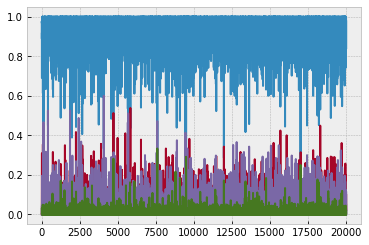

In [16]:
plt.plot(df_exp_ns_h2_p3_data/df_exp_ns_h2_p3_data.sum(1).reshape(20_000, 1))

In [ ]:
import pandas as pd
import numpy as np

df_exp_ns_h2_p3 = pd.read_csv('sim/test_new_steez_prevalence_.02_h2_.3_pi.1')
display(df_exp_ns_h2_p3)
df_exp_ns_h2_p3_data = df_exp_ns_h2_p3.to_numpy()
display('df_exp_ns_h2_p3_data', df_exp_ns_h2_p3_data)

cheats_exp_ns_h2_p3= pd.read_csv('sim/test_new_steez_prevalence_.02_h2_.3_pi.1.cheat.txt', sep='\t')
df_exp_ns_h2_p3_genetic_architectures = cheats_exp_ns_h2_p3['Model_No'].to_numpy()
display(cheats_exp_ns_h2_p3)
display('df_exp_ns_h2_p3_genetic_architectures', df_exp_ns_h2_p3_genetic_architectures)


# Our best performing model; fits like a champ even challening simulations
random_key, _random_key = random.split(random_key)

res_exp_ns_h2_p3 = run_until_enough(random_key=_random_key, target_number_of_chains=1, run_params={
    "data": df_exp_ns_h2_p3_data,
    "max_K": 4,
    "shared_dirichlet_prior": True,
})
best_chain_exp_ns_h2_p3, statistics_exp_ns_h2_p3 = select_best_chain(res_exp_ns_h2_p3)
display(statistics_exp_ns_h2_p3)

#best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain])
best_weights_exp_ns_h2_p3, best_probs_exp_ns_h2_p3, best_betas_exp_ns_h2_p3, best_dirichlet_concentrations_exp_ns_h2_p3 = get_parameters(best_chain_exp_ns_h2_p3)

# pds_exp_ns_h2_p3 = np.array([0.043475,0.04295,0.012475])
#pd_with_both_exp_ns_h2_p3 = np.array([1 - pds_exp_ns_h2_p3.sum(), *pds_exp_ns_h2_p3])
n_samples_exp_ns_h2_p3 = 200_000
var1_exp_ns_h2_p3, var2_exp_ns_h2_p3, cov_exp_ns_h2_p3, rho_exp_ns_h2_p3, debug_architectures_exp_ns_h2_p3 = get_rho_bivariate(probs = best_probs_exp_ns_h2_p3, weights = best_weights_exp_ns_h2_p3,
                                         observations = df_exp_ns_h2_p3_data,
                                         true_architectures = df_exp_ns_h2_p3_genetic_architectures,
                                         concentrations = best_dirichlet_concentrations_exp_ns_h2_p3,
                                         # prevalences=pd_with_both_exp_ns_h2_p3,
                                         n_samples = n_samples_exp_ns_h2_p3)

# debug_architectures_3.query('`estimated genetic architecture` != real').to_csv('things_we_got_wrong_exp_3.csv')
# debug_architectures_3.query('`estimated genetic architecture` == real').to_csv('things_we_got_right_exp_3.csv')


In [19]:
import pandas as pd
import numpy as np

df_exp_ns_h2_p2_rho0= pd.read_csv('sim/test_new_steez_prevalence_.02_h2_.2_pi.1_rho0')
display(df_exp_ns_h2_p2_rho0)
df_exp_ns_h2_p2_rho0_data = df_exp_ns_h2_p2_rho0.to_numpy()
display('df_exp_ns_h2_p2_rho0_data', df_exp_ns_h2_p2_rho0_data)

cheats_exp_ns_h2_p2_rho0= pd.read_csv('sim/test_new_steez_prevalence_.02_h2_.2_pi.1_rho0.cheat.txt', sep='\t')
df_exp_ns_h2_p2_rho0_genetic_architectures = cheats_exp_ns_h2_p2_rho0['Model_No'].to_numpy()
display(cheats_exp_ns_h2_p2_rho0)
display('df_exp_ns_h2_p2_rho0_genetic_architectures', df_exp_ns_h2_p2_rho0_genetic_architectures)


# Our best performing model; fits like a champ even challening simulations
random_key, _random_key = random.split(random_key)

res_exp_ns_h2_p2_rho0 = run_until_enough(random_key=_random_key, target_number_of_chains=1, run_params={
    "data": df_exp_ns_h2_p2_rho0_data,
    "max_K": 4,
})
best_chain_exp_ns_h2_p2_rho0, statistics_exp_ns_h2_p2_rho0 = select_best_chain(res_exp_ns_h2_p2_rho0)
display(statistics_exp_ns_h2_p2_rho0)

#best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain])
best_weights_exp_ns_h2_p2_rho0, best_probs_exp_ns_h2_p2_rho0, best_betas_exp_ns_h2_p2_rho0, best_dirichlet_concentrations_exp_ns_h2_p2_rho0 = get_parameters(best_chain_exp_ns_h2_p2_rho0)

# pds_exp_ns_h2_p2_rho0 = np.array([0.043475,0.04295,0.012475])
#pd_with_both_exp_ns_h2_p2_rho0 = np.array([1 - pds_exp_ns_h2_p2_rho0.sum(), *pds_exp_ns_h2_p2_rho0])
n_samples_exp_ns_h2_p2_rho0 = 200_000
var1_exp_ns_h2_p2_rho0, var2_exp_ns_h2_p2_rho0, cov_exp_ns_h2_p2_rho0, rho_exp_ns_h2_p2_rho0, debug_architectures_exp_ns_h2_p2_rho0 = get_rho_bivariate(probs = best_probs_exp_ns_h2_p2_rho0, weights = best_weights_exp_ns_h2_p2_rho0,
                                         observations = df_exp_ns_h2_p2_rho0_data,
                                         true_architectures = df_exp_ns_h2_p2_rho0_genetic_architectures,
                                         concentrations = best_dirichlet_concentrations_exp_ns_h2_p2_rho0,
                                         # prevalences=pd_with_both_exp_ns_h2_p2_rho0,
                                         n_samples = n_samples_exp_ns_h2_p2_rho0)

,Per_Gene_Counts_Unaffected_Unaffected,Unaffected_Affected,Affected_Unaffected,Affected_Affected
0,33,0,0,0
1,34,1,2,0
2,42,0,2,0
3,47,2,0,0
4,39,1,3,0
...,...,...,...,...
19995,41,0,0,0
19996,30,3,2,0
19997,48,0,1,0
19998,42,0,1,0


'df_exp_ns_h2_p2_rho0_data'

array([[33,  0,  0,  0],
       [34,  1,  2,  0],
       [42,  0,  2,  0],
       ...,
       [48,  0,  1,  0],
       [42,  0,  1,  0],
       [40,  0,  1,  0]])

,Gene_No,Model_No,"[[a,b][c,d]]a",b,c,d
0,0,0,0.0,0,0,0.0
1,1,0,0.0,0,0,0.0
2,2,0,0.0,0,0,0.0
3,3,0,0.0,0,0,0.0
4,4,3,0.2,0,0,0.2
...,...,...,...,...,...,...
19995,19995,0,0.0,0,0,0.0
19996,19996,0,0.0,0,0,0.0
19997,19997,0,0.0,0,0,0.0
19998,19998,0,0.0,0,0,0.0


'df_exp_ns_h2_p2_rho0_genetic_architectures'

array([0, 0, 0, ..., 0, 0, 0])

  0%|          | 0/6000 [00:00<?, ?it/s]

alpha 0.0125


sample: 100%|██████████| 6000/6000 [01:06<00:00, 89.76it/s, 15 steps of size 1.57e-01. acc. prob=0.89] 



                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                     beta[0]      0.04      0.00      0.04      0.03      0.04   4066.98      1.00
                     beta[1]      0.90      0.02      0.90      0.87      0.93   1520.53      1.00
                     beta[2]      0.14      0.03      0.14      0.10      0.18   2568.94      1.00
dirichlet_concentration[0,0]      6.15      1.00      6.11      4.36      7.60   6013.83      1.00
dirichlet_concentration[0,1]      1.18      0.77      1.02      0.12      2.31   6365.69      1.00
dirichlet_concentration[0,2]      0.58      0.41      0.49      0.02      1.14   6346.94      1.00
dirichlet_concentration[0,3]      0.29      0.27      0.21      0.00      0.65   5995.98      1.00
dirichlet_concentration[1,0]      6.18      1.04      6.13      4.38      7.76   6174.28      1.00
dirichlet_concentration[1,1]      0.61      0.42      0.52      0.02      1.18   5241.54      1.00
dirichlet

,diverging,accept_prob_mean,accept_prob_std,potential_energy,mcmc_index
0,0.0,0.888674,0.113154,2278738.25,0.0


KeyError: 3

{'h2': [0.2, 0.2],
 'total_variance_before_normalization': [0.200111536461155, 0.200441060283296],
 'genetic_mean_liability': [3.00757752036418e-16, -3.61716767649511e-16],
 'prevalence_actual': [0.023735, 0.02411],
 'total_affected': [4747, 4822],
 'residual_variance_liability': [0.798090941259858, 0.799468467265914],
 'residual_mean_liability': [0.000768463874137692, -0.00303509540941654],
 'observed_prevalences': [0.023735, 0.02411, 0.00066],
 'prevalence_expected': [0.02, 0.02],
 'stupid_sum': [4.06392397511723e-09, 2.53591983523371e-09],
 'rho': '0',
 'expected_mutations_per_person': 4,
 'expected_risk_mutations_per_person': 1.2,
 'total_N': 200000,
 'models': [0.7, 0.1, 0.1, 0.1],
 'disease_gene_counts': [1961, 2010, 1971],
 'genetic_variance_liability': [0.199767272778438, 0.20139146507658],
 'sigma': [0.500025001875156, 0.500025001875156]}

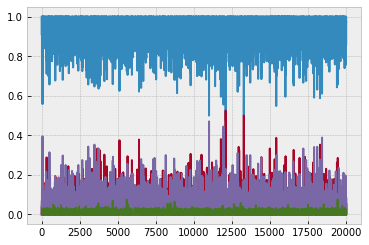

In [23]:
plt.plot(df_exp_ns_h2_p2_rho0_data/df_exp_ns_h2_p2_rho0_data.sum(1).reshape(20_000,1))

import json
with open('sim/test_new_steez_prevalence_.02_h2_.2_pi.1_rho0.json') as f:
    r = json.load(f)
r

In [25]:
import pandas as pd
import numpy as np

df_exp_ns_h2_p8_rho0= pd.read_csv('sim/test_new_steez_prevalence_.02_h2_.8_pi.1_rho0')
display(df_exp_ns_h2_p8_rho0)
df_exp_ns_h2_p8_rho0_data = df_exp_ns_h2_p8_rho0.to_numpy()
display('df_exp_ns_h2_p8_rho0_data', df_exp_ns_h2_p8_rho0_data)

cheats_exp_ns_h2_p8_rho0= pd.read_csv('sim/test_new_steez_prevalence_.02_h2_.8_pi.1_rho0.cheat.txt', sep='\t')
df_exp_ns_h2_p8_rho0_genetic_architectures = cheats_exp_ns_h2_p8_rho0['Model_No'].to_numpy()
display(cheats_exp_ns_h2_p8_rho0)
display('df_exp_ns_h2_p8_rho0_genetic_architectures', df_exp_ns_h2_p8_rho0_genetic_architectures)


# Our best performing model; fits like a champ even challening simulations
random_key, _random_key = random.split(random_key)

res_exp_ns_h2_p8_rho0 = run_until_enough(random_key=_random_key, target_number_of_chains=1, run_params={
    "data": df_exp_ns_h2_p8_rho0_data,
    "max_K": 4,
})
best_chain_exp_ns_h2_p8_rho0, statistics_exp_ns_h2_p8_rho0 = select_best_chain(res_exp_ns_h2_p8_rho0)
display(statistics_exp_ns_h2_p8_rho0)

#best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain])
best_weights_exp_ns_h2_p8_rho0, best_probs_exp_ns_h2_p8_rho0, best_betas_exp_ns_h2_p8_rho0, best_dirichlet_concentrations_exp_ns_h2_p8_rho0 = get_parameters(best_chain_exp_ns_h2_p8_rho0)

# pds_exp_ns_h2_p8_rho0 = np.array([0.043475,0.04295,0.012475])
#pd_with_both_exp_ns_h2_p8_rho0 = np.array([1 - pds_exp_ns_h2_p8_rho0.sum(), *pds_exp_ns_h2_p8_rho0])
n_samples_exp_ns_h2_p8_rho0 = 200_000
var1_exp_ns_h2_p8_rho0, var2_exp_ns_h2_p8_rho0, cov_exp_ns_h2_p8_rho0, rho_exp_ns_h2_p8_rho0, debug_architectures_exp_ns_h2_p8_rho0 = get_rho_bivariate(probs = best_probs_exp_ns_h2_p8_rho0, weights = best_weights_exp_ns_h2_p8_rho0,
                                         observations = df_exp_ns_h2_p8_rho0_data,
                                         true_architectures = df_exp_ns_h2_p8_rho0_genetic_architectures,
                                         concentrations = best_dirichlet_concentrations_exp_ns_h2_p8_rho0,
                                         # prevalences=pd_with_both_exp_ns_h2_p8_rho0,
                                         n_samples = n_samples_exp_ns_h2_p8_rho0)

,Per_Gene_Counts_Unaffected_Unaffected,Unaffected_Affected,Affected_Unaffected,Affected_Affected
0,39,2,1,0
1,38,0,3,0
2,36,2,2,0
3,37,1,4,0
4,41,0,3,0
...,...,...,...,...
19995,43,1,1,0
19996,42,5,4,0
19997,25,1,0,0
19998,42,1,3,0


'df_exp_ns_h2_p8_rho0_data'

array([[39,  2,  1,  0],
       [38,  0,  3,  0],
       [36,  2,  2,  0],
       ...,
       [25,  1,  0,  0],
       [42,  1,  3,  0],
       [44,  3,  2,  0]])

,Gene_No,Model_No,"[[a,b][c,d]]a",b,c,d
0,0,1,0.0,0,0,0.8
1,1,0,0.0,0,0,0.0
2,2,0,0.0,0,0,0.0
3,3,2,0.8,0,0,0.0
4,4,0,0.0,0,0,0.0
...,...,...,...,...,...,...
19995,19995,0,0.0,0,0,0.0
19996,19996,0,0.0,0,0,0.0
19997,19997,0,0.0,0,0,0.0
19998,19998,0,0.0,0,0,0.0


'df_exp_ns_h2_p8_rho0_genetic_architectures'

array([1, 0, 0, ..., 0, 0, 1])

  0%|          | 0/6000 [00:00<?, ?it/s]

alpha 0.0125


sample: 100%|██████████| 6000/6000 [00:36<00:00, 166.47it/s, 15 steps of size 3.39e-01. acc. prob=0.88]



                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                     beta[0]      0.06      0.00      0.06      0.05      0.06   5021.78      1.00
                     beta[1]      0.95      0.00      0.95      0.95      0.95   5984.60      1.00
                     beta[2]      0.85      0.01      0.85      0.83      0.87   4780.71      1.00
dirichlet_concentration[0,0]      5.25      1.01      5.18      3.61      6.89   6393.48      1.00
dirichlet_concentration[0,1]      0.63      0.46      0.53      0.01      1.24   6414.05      1.00
dirichlet_concentration[0,2]      1.44      0.95      1.23      0.13      2.84   5938.34      1.00
dirichlet_concentration[0,3]      0.42      0.36      0.32      0.00      0.91   6458.68      1.00
dirichlet_concentration[1,0]      5.33      1.00      5.27      3.60      6.88   5543.07      1.00
dirichlet_concentration[1,1]      0.68      0.49      0.56      0.02      1.36   6082.98      1.00
dirichlet

,diverging,accept_prob_mean,accept_prob_std,potential_energy,mcmc_index
0,0.0,0.883653,0.111245,2302664.75,0.0


KeyError: 0

{'residual_variance_liability': [0.200963986303942, 0.199905192945081],
 'prevalence_expected': [0.02, 0.02],
 'observed_prevalences': [0.04456, 0.04241, 0.00296],
 'expected_risk_mutations_per_person': 1.2,
 'genetic_variance_liability': [0.821495840677343, 0.780524597460601],
 'genetic_mean_liability': [-2.16128198671228e-15, -2.4883040072865e-16],
 'rho': '0',
 'prevalence_actual': [0.04456, 0.04241],
 'total_affected': [8912, 8482],
 'expected_mutations_per_person': 4,
 'h2': [0.8, 0.8],
 'sigma': [1.00005000375031, 1.00005000375031],
 'total_N': 200000,
 'models': [0.7, 0.1, 0.1, 0.1],
 'total_variance_before_normalization': [0.81806936646039, 0.780314129870066],
 'disease_gene_counts': [2054, 1946, 1995],
 'residual_mean_liability': [4.75885537257054e-05, 2.35122786590736e-05],
 'stupid_sum': [3.00400460062633e-09, 2.15912837608911e-09]}

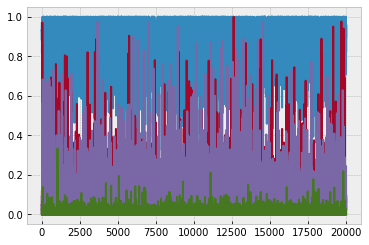

In [26]:
plt.plot(df_exp_ns_h2_p8_rho0_data/df_exp_ns_h2_p8_rho0_data.sum(1).reshape(20_000,1))

import json
with open('sim/test_new_steez_prevalence_.02_h2_.8_pi.1_rho0.json') as f:
    r2 = json.load(f)
r2

In [98]:
######### Try with lognormal ########
import pandas as pd
import numpy as np

df_exp_ns_h2_p2_rho95_ctm_lkj = pd.read_csv('sim/test_new_steez_prevalence_.02_h2_.2_rho_.95_pi.1')
display(df_exp_ns_h2_p2_rho95_ctm_lkj)
df_exp_ns_h2_p2_rho95_ctm_lkj_data = df_exp_ns_h2_p2_rho95_ctm_lkj.to_numpy()
display('test_new_steez_prevalence_.02_h2_.2_rho_.95_pi.1 data', df_exp_ns_h2_p2_rho95_ctm_lkj_data)

cheats_exp_ns_h2_p2_rho95_ctm_lkj = pd.read_csv('sim/test_new_steez_prevalence_.02_h2_.2_rho_.95_pi.1.cheat.txt', sep='\t')
cheats2_exp_ns_h2_p2_rho95_ctm_lkj = pd.read_csv('sim/test_new_steez_prevalence_.02_h2_.2_rho_.95_pi.1.cheat2.txt')

df_exp_ns_h2_p2_rho95_ctm_lkj_genetic_architectures = cheats_exp_ns_h2_p2_rho95_ctm_lkj['Model_No'].to_numpy()
display(cheats_exp_ns_h2_p2_rho95_ctm_lkj)
display('df_exp_ns_h2_p2_rho95_ctm_lkj_genetic_architectures', df_exp_ns_h2_p2_rho95_ctm_lkj_genetic_architectures)


# Our best performing model; fits like a champ even challening simulations
random_key, _random_key = random.split(random_key)

res_exp_ns_h2_p2_rho95_ctm_lkj = run_until_enough(random_key=_random_key, target_number_of_chains=1, run_params={
    "data": df_exp_ns_h2_p2_rho95_ctm_lkj_data,
    "max_K": 4,
    "model_to_run": modelLKJ
})
best_chain_exp_ns_h2_p2_rho95_ctm_lkj, statistics_exp_ns_h2_p2_rho95_ctm_lkj = select_best_chain(res_exp_ns_h2_p2_rho95_ctm_lkj)
display(statistics_exp_ns_h2_p2_rho95_ctm_lkj)

#best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain])
best_weights_exp_ns_h2_p2_rho95_ctm_lkj, best_probs_exp_ns_h2_p2_rho95_ctm_lkj, best_betas_exp_ns_h2_p2_rho95_ctm_lkj, best_dirichlet_concentrations_exp_ns_h2_p2_rho95_ctm_lkj = get_parameters(best_chain_exp_ns_h2_p2_rho95_ctm_lkj)

# pds_exp_ns_h2_p2_rho95_ctm_lkj = np.array([0.043475,0.04295,0.012475])
#pd_with_both_exp_ns_h2_p2_rho95_ctm_lkj = np.array([1 - pds_exp_ns_h2_p2_rho95_ctm_lkj.sum(), *pds_exp_ns_h2_p2_rho95_ctm_lkj])
n_samples_exp_ns_h2_p2_rho95_ctm_lkj = 200_000
var1_exp_ns_h2_p2_rho95_ctm_lkj, var2_exp_ns_h2_p2_rho95_ctm_lkj, cov_exp_ns_h2_p2_rho95_ctm_lkj, rho_exp_ns_h2_p2_rho95_ctm_lkj, debug_architectures_exp_ns_h2_p2_rho95_ctm_lkj = get_rho_bivariate(probs = best_probs_exp_ns_h2_p2_rho95_ctm_lkj, weights = best_weights_exp_ns_h2_p2_rho95_ctm_lkj,
                                         observations = df_exp_ns_h2_p2_rho95_ctm_lkj_data,
                                         true_architectures = df_exp_ns_h2_p2_rho95_ctm_lkj_genetic_architectures,
                                         concentrations = best_dirichlet_concentrations_exp_ns_h2_p2_rho95_ctm_lkj,
                                         # prevalences=pd_with_both_exp_ns_h2_p2_rho95_ctm_lkj,
                                         n_samples = n_samples_exp_ns_h2_p2_rho95_ctm_lkj)

,Per_Gene_Counts_Unaffected_Unaffected,Unaffected_Affected,Affected_Unaffected,Affected_Affected
0,50,0,1,0
1,39,3,1,0
2,38,0,2,0
3,34,1,2,0
4,29,8,5,1
...,...,...,...,...
19995,37,2,0,0
19996,37,1,5,0
19997,45,0,0,0
19998,39,4,1,0


'test_new_steez_prevalence_.02_h2_.2_rho_.95_pi.1 data'

array([[50,  0,  1,  0],
       [39,  3,  1,  0],
       [38,  0,  2,  0],
       ...,
       [45,  0,  0,  0],
       [39,  4,  1,  0],
       [35,  0,  0,  0]])

,Gene_No,Model_No,"[[a,b][c,d]]a",b,c,d
0,0,0,0.0,0.00,0.00,0.0
1,1,3,0.2,0.95,0.95,0.2
2,2,1,0.0,0.00,0.00,0.2
3,3,0,0.0,0.00,0.00,0.0
4,4,3,0.2,0.95,0.95,0.2
...,...,...,...,...,...,...
19995,19995,0,0.0,0.00,0.00,0.0
19996,19996,0,0.0,0.00,0.00,0.0
19997,19997,1,0.0,0.00,0.00,0.2
19998,19998,1,0.0,0.00,0.00,0.2


'df_exp_ns_h2_p2_rho95_ctm_lkj_genetic_architectures'

array([0, 3, 1, ..., 1, 1, 3])

  0%|          | 0/6000 [00:00<?, ?it/s]

alpha 0.0125


warmup:   2%|▏         | 143/6000 [00:29<20:09,  4.84it/s, 724 steps of size 2.52e-03. acc. prob=0.76] 


KeyboardInterrupt: 

In [96]:
######### Try with lognormal ########
import pandas as pd
import numpy as np

df_exp_ns_h2_p2_rho95_ctm = pd.read_csv('sim/test_new_steez_prevalence_.02_h2_.2_rho_.95_pi.1')
display(df_exp_ns_h2_p2_rho95_ctm)
df_exp_ns_h2_p2_rho95_ctm_data = df_exp_ns_h2_p2_rho95_ctm.to_numpy()
display('test_new_steez_prevalence_.02_h2_.2_rho_.95_pi.1 data', df_exp_ns_h2_p2_rho95_ctm_data)

cheats_exp_ns_h2_p2_rho95_ctm = pd.read_csv('sim/test_new_steez_prevalence_.02_h2_.2_rho_.95_pi.1.cheat.txt', sep='\t')
cheats2_exp_ns_h2_p2_rho95_ctm = pd.read_csv('sim/test_new_steez_prevalence_.02_h2_.2_rho_.95_pi.1.cheat2.txt')

df_exp_ns_h2_p2_rho95_ctm_genetic_architectures = cheats_exp_ns_h2_p2_rho95_ctm['Model_No'].to_numpy()
display(cheats_exp_ns_h2_p2_rho95_ctm)
display('df_exp_ns_h2_p2_rho95_ctm_genetic_architectures', df_exp_ns_h2_p2_rho95_ctm_genetic_architectures)


# Our best performing model; fits like a champ even challening simulations
random_key, _random_key = random.split(random_key)

res_exp_ns_h2_p2_rho95_ctm = run_until_enough(random_key=_random_key, target_number_of_chains=1, run_params={
    "data": df_exp_ns_h2_p2_rho95_ctm_data,
    "max_K": 4,
    "model_to_run": modelLN
})
best_chain_exp_ns_h2_p2_rho95_ctm, statistics_exp_ns_h2_p2_rho95_ctm = select_best_chain(res_exp_ns_h2_p2_rho95_ctm)
display(statistics_exp_ns_h2_p2_rho95_ctm)

#best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain])
best_weights_exp_ns_h2_p2_rho95_ctm, best_probs_exp_ns_h2_p2_rho95_ctm, best_betas_exp_ns_h2_p2_rho95_ctm, best_dirichlet_concentrations_exp_ns_h2_p2_rho95_ctm = get_parameters(best_chain_exp_ns_h2_p2_rho95_ctm)

# pds_exp_ns_h2_p2_rho95_ctm = np.array([0.043475,0.04295,0.012475])
#pd_with_both_exp_ns_h2_p2_rho95_ctm = np.array([1 - pds_exp_ns_h2_p2_rho95_ctm.sum(), *pds_exp_ns_h2_p2_rho95_ctm])
n_samples_exp_ns_h2_p2_rho95_ctm = 200_000
var1_exp_ns_h2_p2_rho95_ctm, var2_exp_ns_h2_p2_rho95_ctm, cov_exp_ns_h2_p2_rho95_ctm, rho_exp_ns_h2_p2_rho95_ctm, debug_architectures_exp_ns_h2_p2_rho95_ctm = get_rho_bivariate(probs = best_probs_exp_ns_h2_p2_rho95_ctm, weights = best_weights_exp_ns_h2_p2_rho95_ctm,
                                         observations = df_exp_ns_h2_p2_rho95_ctm_data,
                                         true_architectures = df_exp_ns_h2_p2_rho95_ctm_genetic_architectures,
                                         concentrations = best_dirichlet_concentrations_exp_ns_h2_p2_rho95_ctm,
                                         # prevalences=pd_with_both_exp_ns_h2_p2_rho95_ctm,
                                         n_samples = n_samples_exp_ns_h2_p2_rho95_ctm)

,Per_Gene_Counts_Unaffected_Unaffected,Unaffected_Affected,Affected_Unaffected,Affected_Affected
0,50,0,1,0
1,39,3,1,0
2,38,0,2,0
3,34,1,2,0
4,29,8,5,1
...,...,...,...,...
19995,37,2,0,0
19996,37,1,5,0
19997,45,0,0,0
19998,39,4,1,0


'test_new_steez_prevalence_.02_h2_.2_rho_.95_pi.1 data'

array([[50,  0,  1,  0],
       [39,  3,  1,  0],
       [38,  0,  2,  0],
       ...,
       [45,  0,  0,  0],
       [39,  4,  1,  0],
       [35,  0,  0,  0]])

,Gene_No,Model_No,"[[a,b][c,d]]a",b,c,d
0,0,0,0.0,0.00,0.00,0.0
1,1,3,0.2,0.95,0.95,0.2
2,2,1,0.0,0.00,0.00,0.2
3,3,0,0.0,0.00,0.00,0.0
4,4,3,0.2,0.95,0.95,0.2
...,...,...,...,...,...,...
19995,19995,0,0.0,0.00,0.00,0.0
19996,19996,0,0.0,0.00,0.00,0.0
19997,19997,1,0.0,0.00,0.00,0.2
19998,19998,1,0.0,0.00,0.00,0.2


'df_exp_ns_h2_p2_rho95_ctm_genetic_architectures'

array([0, 3, 1, ..., 1, 1, 3])

  0%|          | 0/6000 [00:00<?, ?it/s]

alpha 0.0125
running
running
running


sample: 100%|██████████| 6000/6000 [10:45<00:00,  9.29it/s, 511 steps of size 1.53e-02. acc. prob=0.88] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta[0]      0.01      0.00      0.01      0.01      0.01   4682.02      1.00
      beta[1]      0.93      0.00      0.93      0.93      0.94   3950.11      1.00
      beta[2]      0.49      0.03      0.49      0.44      0.55   4632.40      1.00
logtheta[0,0]      6.54      0.37      6.54      5.96      7.17   2427.51      1.00
logtheta[0,1]      4.76      0.36      4.77      4.18      5.38   2404.50      1.00
logtheta[0,2]      4.72      0.36      4.72      4.14      5.33   2406.75      1.00
logtheta[0,3]      3.52      0.36      3.53      2.98      4.14   2396.79      1.00
logtheta[1,0]      6.07      0.35      6.07      5.50      6.63   2279.36      1.00
logtheta[1,1]      2.38      0.35      2.38      1.81      2.94   2280.35      1.00
logtheta[1,2]      2.40      0.35      2.40      1.82      2.95   2278.86      1.00
logtheta[1,3]     -0.09      0.35     -0.09     -0.67      0.46   2285.84  

KeyError: 'probs'

In [69]:
with numpyro.handlers.seed(rng_seed=1):
    random_key, _random_key = random.split(random_key)
    d1 = df_exp_ns_h2_p2_rho95_ctm_data
    print(d1)
    mean_est = jnp.log(jnp.mean(d1, axis=0)).reshape(d1.shape[1], 1)
    # print('probs', probs)
    print('mean_est', mean_est)
    cov_est = jnp.cov(d1.T)
    print('cov_est', cov_est)

    logtheta = MultivariateNormal(mean_est, cov_est)
    s = logtheta.sample(random_key)
    theta = jnp.exp(s)
    print('theta', theta/theta.sum())
    print('jax.nn.softmax(s, -1)', jax.nn.softmax(s))

[[50  0  1  0]
 [39  3  1  0]
 [38  0  2  0]
 ...
 [45  0  0  0]
 [39  4  1  0]
 [35  0  0  0]]
mean_est [[ 3.6298869 ]
 [ 0.10237607]
 [ 0.12645638]
 [-2.2429023 ]]
cov_est [[40.413994   -0.851145   -0.92136055 -0.18064299]
 [-0.851145    1.7347292   0.12884894  0.07665806]
 [-0.92136055  0.12884894  1.7768677   0.07564168]
 [-0.18064299  0.07665806  0.07564168  0.1263181 ]]
theta [[9.3713105e-01 6.0934090e-04 2.2200564e-05 1.7738302e-04]
 [1.5274582e-08 2.9832056e-06 5.5210344e-06 1.7047410e-06]
 [6.2045194e-02 8.6570492e-07 4.6915633e-07 2.1028286e-06]
 [4.2526143e-12 7.3455175e-07 7.7481744e-08 2.2533348e-07]]
jax.nn.softmax(s, -1) [[9.9913752e-01 6.4965867e-04 2.3669481e-05 1.8911969e-04]
 [1.4939553e-03 2.9177731e-01 5.3999376e-01 1.6673498e-01]
 [9.9994469e-01 1.3952038e-05 7.5611079e-06 3.3890024e-05]
 [4.0994146e-06 7.0808953e-01 7.4690454e-02 2.1721585e-01]]


In [105]:
import pandas as pd
import numpy as np

df_exp_ns_h2_p2_rho95 = pd.read_csv('sim/test_new_steez_prevalence_.02_h2_.2_rho_.95_pi.1')
display(df_exp_ns_h2_p2_rho95)
df_exp_ns_h2_p2_rho95_data = df_exp_ns_h2_p2_rho95.to_numpy()
display('test_new_steez_prevalence_.02_h2_.2_rho_.95_pi.1 data', df_exp_ns_h2_p2_rho95_data)

cheats_exp_ns_h2_p2_rho95 = pd.read_csv('sim/test_new_steez_prevalence_.02_h2_.2_rho_.95_pi.1.cheat.txt', sep='\t')
cheats2_exp_ns_h2_p2_rho95 = pd.read_csv('sim/test_new_steez_prevalence_.02_h2_.2_rho_.95_pi.1.cheat2.txt')

df_exp_ns_h2_p2_rho95_genetic_architectures = cheats_exp_ns_h2_p2_rho95['Model_No'].to_numpy()
display(cheats_exp_ns_h2_p2_rho95)
display('df_exp_ns_h2_p2_rho95_genetic_architectures', df_exp_ns_h2_p2_rho95_genetic_architectures)


# Our best performing model; fits like a champ even challening simulations
random_key, _random_key = random.split(random_key)

res_exp_ns_h2_p2_rho95 = run_until_enough(random_key=_random_key, target_number_of_chains=1, run_params={
    "data": df_exp_ns_h2_p2_rho95_data,
    "max_K": 4,
})
best_chain_exp_ns_h2_p2_rho95, statistics_exp_ns_h2_p2_rho95 = select_best_chain(res_exp_ns_h2_p2_rho95)
display(statistics_exp_ns_h2_p2_rho95)

#best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain])
best_weights_exp_ns_h2_p2_rho95, best_probs_exp_ns_h2_p2_rho95, best_betas_exp_ns_h2_p2_rho95, best_dirichlet_concentrations_exp_ns_h2_p2_rho95 = get_parameters(best_chain_exp_ns_h2_p2_rho95)

# pds_exp_ns_h2_p2_rho95 = np.array([0.043475,0.04295,0.012475])
#pd_with_both_exp_ns_h2_p2_rho95 = np.array([1 - pds_exp_ns_h2_p2_rho95.sum(), *pds_exp_ns_h2_p2_rho95])
n_samples_exp_ns_h2_p2_rho95 = 200_000
var1_exp_ns_h2_p2_rho95, var2_exp_ns_h2_p2_rho95, cov_exp_ns_h2_p2_rho95, rho_exp_ns_h2_p2_rho95, debug_architectures_exp_ns_h2_p2_rho95 = get_rho_bivariate(probs = best_probs_exp_ns_h2_p2_rho95, weights = best_weights_exp_ns_h2_p2_rho95,
                                         observations = df_exp_ns_h2_p2_rho95_data,
                                         true_architectures = df_exp_ns_h2_p2_rho95_genetic_architectures,
                                         concentrations = best_dirichlet_concentrations_exp_ns_h2_p2_rho95,
                                         # prevalences=pd_with_both_exp_ns_h2_p2_rho95,
                                         n_samples = n_samples_exp_ns_h2_p2_rho95)

,Per_Gene_Counts_Unaffected_Unaffected,Unaffected_Affected,Affected_Unaffected,Affected_Affected
0,48,0,1,0
1,39,1,0,0
2,38,1,1,0
3,25,1,0,0
4,35,0,2,0
...,...,...,...,...
19995,37,0,2,1
19996,28,0,1,0
19997,53,1,0,0
19998,38,0,1,0


'test_new_steez_prevalence_.02_h2_.2_rho_.95_pi.1 data'

array([[48,  0,  1,  0],
       [39,  1,  0,  0],
       [38,  1,  1,  0],
       ...,
       [53,  1,  0,  0],
       [38,  0,  1,  0],
       [31,  3,  0,  0]])

,Gene_No,Model_No,"[[a,b][c,d]]a",b,c,d
0,0,0,0.0,0.00,0.00,0.0
1,1,3,0.2,0.95,0.95,0.2
2,2,1,0.0,0.00,0.00,0.2
3,3,0,0.0,0.00,0.00,0.0
4,4,3,0.2,0.95,0.95,0.2
...,...,...,...,...,...,...
19995,19995,0,0.0,0.00,0.00,0.0
19996,19996,0,0.0,0.00,0.00,0.0
19997,19997,1,0.0,0.00,0.00,0.2
19998,19998,1,0.0,0.00,0.00,0.2


'df_exp_ns_h2_p2_rho95_genetic_architectures'

array([0, 3, 1, ..., 1, 1, 3])

  0%|          | 0/6000 [00:00<?, ?it/s]

alpha 0.0125


sample: 100%|██████████| 6000/6000 [00:43<00:00, 137.91it/s, 15 steps of size 2.81e-01. acc. prob=0.89]



                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                     beta[0]      0.04      0.00      0.04      0.03      0.04   2951.49      1.00
                     beta[1]      0.95      0.01      0.95      0.94      0.95   2292.57      1.00
                     beta[2]      0.13      0.02      0.12      0.10      0.16   3703.96      1.00
dirichlet_concentration[0,0]      6.13      0.99      6.09      4.58      7.77   7626.01      1.00
dirichlet_concentration[0,1]      0.67      0.47      0.58      0.02      1.28   6486.54      1.00
dirichlet_concentration[0,2]      1.08      0.72      0.94      0.02      2.06   7577.80      1.00
dirichlet_concentration[0,3]      0.33      0.30      0.25      0.00      0.72   6064.66      1.00
dirichlet_concentration[1,0]      6.14      1.00      6.11      4.49      7.76   7807.20      1.00
dirichlet_concentration[1,1]      0.61      0.43      0.52      0.03      1.19   7882.52      1.00
dirichlet

,diverging,accept_prob_mean,accept_prob_std,potential_energy,mcmc_index
0,0.0,0.887867,0.106514,2282204.5,0.0


ordered_weights [0.91188437 0.04496084 0.03670063 0.00645489]
ordered_probs [[0.94892156 0.02481849 0.02420298 0.00205699]
 [0.85283023 0.10608438 0.03345285 0.00763262]
 [0.847869   0.03307968 0.11232064 0.00673077]
 [0.66417694 0.1608435  0.12659763 0.04838202]]
posterior prevalence estimate [0.93911885 0.02961841 0.02846478 0.00279795]
posterior prevalence estimate using our stuff [0.9390552  0.02965351 0.0285138  0.00277823]
Estimating sample breakdown using prevalences
alleles [375647.54110967  11847.36550926  11385.91209174   1119.18128934]
P_D1 0.029618413773150894 P_D2 0.02846478022934442
n_genes_used 512
tot_post_one 327.60594178084284
tot_post_two 247.5897608147934
tot_post_both 125.9201912432909
inf_rows 8
cov_sum_f 0.8647643268235073
sigma1_mean 0.8913609741870574
sigma1_^2_mean 0.8571282673564802
sigma2_mean 0.850467425896091
sigma2_^2_mean 0.7977350716392628
cov 0.1066908535624086
rho 1.5628694798060292
how_many_wrong 6696
how_many_right 13304
how_many_mixed_up_one_two 84

In [101]:
cheats_exp_ns_h2_p2_rho95

,Gene_No,Model_No,"[[a,b][c,d]]a",b,c,d
0,0,0,0.0,0.00,0.00,0.0
1,1,3,0.2,0.95,0.95,0.2
2,2,1,0.0,0.00,0.00,0.2
3,3,0,0.0,0.00,0.00,0.0
4,4,3,0.2,0.95,0.95,0.2
...,...,...,...,...,...,...
19995,19995,0,0.0,0.00,0.00,0.0
19996,19996,0,0.0,0.00,0.00,0.0
19997,19997,1,0.0,0.00,0.00,0.2
19998,19998,1,0.0,0.00,0.00,0.2


In [100]:
cheats2_exp_ns_h2_p2_rho95

,Per_Gene_Counts_Unaffected_Unaffected,Unaffected_Affected,Affected_Unaffected,Affected_Affected,Gene_Model
0,50,0,1,0,0
1,39,3,1,0,3
2,38,0,2,0,1
3,34,1,2,0,0
4,29,8,5,1,3
...,...,...,...,...,...
19995,37,2,0,0,0
19996,37,1,5,0,0
19997,45,0,0,0,1
19998,39,4,1,0,1


In [104]:
!cat sim/test_new_steez_prevalence_.02_h2_.5_rho_.95_pi.1.json | jq

{
  "models": [
    0.7,
    0.1,
    0.1,
    0.1
  ],
  "prevalence_actual": [
    0.03385,
    0.03423
  ],
  "sigma": [
    0.790608946477729,
    0.790608946477729
  ],
  "genetic_variance_liability": [
    0.492239985481661,
    0.506946137739756
  ],
  "total_affected": [
    6770,
    6846
  ],
  "residual_variance_liability": [
    0.500407972398873,
    0.495523072365127
  ],
  "rho": 0.95,
  "residual_mean_liability": [
    -0.0014146659105609,
    0.00207978794001202
  ],
  "total_N": 200000,
  "expected_mutations_per_person": 4,
  "observed_prevalences": [
    0.03385,
    0.03423,
    0.006095
  ],
  "total_variance_before_normalization": [
    0.495052695292824,
    0.508859196043639
  ],
  "disease_gene_counts": [
    1943,
    2034,
    2037
  ],
  "stupid_sum": [
    -4.85583597116535e-09,
    -9.13653530609793e-09
  ],
  "prevalence_expected": [
    0.02,
    0.02
  ],
  "expected_risk_mutations_per_person": 1.2,
  "h2": [
    0.5,
    0.5
  ],
  "genetic_mean_liabil

In [32]:
n_samples_exp_ns_h2_p2_rho95 = 200_000
var1_exp_ns_h2_p2_rho95, var2_exp_ns_h2_p2_rho95, cov_exp_ns_h2_p2_rho95, rho_exp_ns_h2_p2_rho95, debug_architectures_exp_ns_h2_p2_rho95 = get_rho_bivariate(probs = best_probs_exp_ns_h2_p2_rho95, weights = best_weights_exp_ns_h2_p2_rho95,
                                         observations = df_exp_ns_h2_p2_rho95_data,
                                         true_architectures = df_exp_ns_h2_p2_rho95_genetic_architectures,
                                         concentrations = best_dirichlet_concentrations_exp_ns_h2_p2_rho95,
                                         # prevalences=pd_with_both_exp_ns_h2_p2_rho95,
                                         n_samples = n_samples_exp_ns_h2_p2_rho95)

ordered_weights [0.9241209  0.03371942 0.03222293 0.00993698]
ordered_probs [[0.9501428  0.02360217 0.02425538 0.00199969]
 [0.8526046  0.11313094 0.02720959 0.00705484]
 [0.8469693  0.02602159 0.12011828 0.00689084]
 [0.7237876  0.12318088 0.11758222 0.03544937]]
posterior prevalence estimate [0.94127151 0.02768124 0.02839063 0.00265662]
posterior prevalence estimate using our stuff [0.94128025 0.02768851 0.02837137 0.00266014]
alleles [376508.60244337  11072.4965583   11356.25352461   1062.64747372]
P_D1 0.030337860080064893 P_D2 0.031047252495821916
n_genes_used 880
tot_post_one 423.5282542575151
tot_post_two 403.4020947506651
tot_post_both 190.5501919919625
inf_rows 9
cov_sum_f 0.7035152130313003
sigma1_mean 0.83438226456047
sigma1_^2_mean 0.7522178535614662
sigma2_mean 0.8259520024162479
sigma2_^2_mean 0.7418792730458681
cov 0.014355510836976504
rho 0.24826043590807084
how_many_wrong 5388
how_many_right 14612
how_many_mixed_up_one_two 11
how_many_mixed_up_both_and_one_or_two 259
h

{'expected_risk_mutations_per_person': 1.2,
 'residual_mean_liability': [-0.000103549036123367, 0.000428964343527411],
 'rho': 0.95,
 'observed_prevalences': [0.02397, 0.02353, 0.001705],
 'genetic_variance_liability': [0.195892886750682, 0.193380318988588],
 'total_affected': [4794, 4706],
 'expected_mutations_per_person': 4,
 'h2': [0.2, 0.2],
 'disease_gene_counts': [2078, 1942, 1983],
 'total_variance_before_normalization': [0.19674260788301, 0.194226645306063],
 'residual_variance_liability': [0.801000401496117, 0.800460450349141],
 'models': [0.7, 0.1, 0.1, 0.1],
 'prevalence_actual': [0.02397, 0.02353],
 'genetic_mean_liability': [1.35670440160052e-15, -9.8361346845266e-16],
 'sigma': [0.500025001875156, 0.500025001875156],
 'stupid_sum': [3.10876301437557e-09, -5.63200325265356e-09],
 'prevalence_expected': [0.02, 0.02],
 'total_N': 200000}

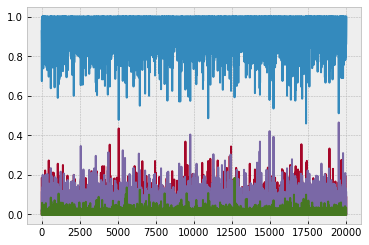

In [5]:
plt.plot(df_exp_ns_h2_p2_rho95_data/df_exp_ns_h2_p2_rho95_data.sum(1).reshape(20_000,1))

import json
with open('sim/test_new_steez_prevalence_.02_h2_.2_rho_.95_pi.1.json') as f:
    r3 = json.load(f)
r3

In [47]:
cheats2_exp_ns_h2_p2_rho95

,Per_Gene_Counts_Unaffected_Unaffected,Unaffected_Affected,Affected_Unaffected,Affected_Affected,Gene_Model
0,50,0,1,0,0
1,39,3,1,0,3
2,38,0,2,0,1
3,34,1,2,0,0
4,29,8,5,1,3
...,...,...,...,...,...
19995,37,2,0,0,0
19996,37,1,5,0,0
19997,45,0,0,0,1
19998,39,4,1,0,1


In [46]:
df_exp_ns_h2_p2_rho95.reset_index().merge(cheats_exp_ns_h2_p2_rho95, left_on='index', right_on='Gene_No').to_csv('df_exp_ns_h2_p2_rho95.tsv', sep='\t')

In [3]:
import pandas as pd
import numpy as np

df_exp_ns_h2_p5_rho95 = pd.read_csv('sim/test_new_steez_prevalence_.02_h2_.5_rho_.95_pi.1')
display(df_exp_ns_h2_p5_rho95)
df_exp_ns_h2_p5_rho95_data = df_exp_ns_h2_p5_rho95.to_numpy()
display('test_new_steez_prevalence_.02_h2_.5_rho_.95_pi.1 data', df_exp_ns_h2_p5_rho95_data)

cheats_exp_ns_h2_p5_rho95 = pd.read_csv('sim/test_new_steez_prevalence_.02_h2_.5_rho_.95_pi.1.cheat.tsv', sep='\t')
cheats2_exp_ns_h2_p5_rho95 = pd.read_csv('sim/test_new_steez_prevalence_.02_h2_.5_rho_.95_pi.1.cheat2.csv')

df_exp_ns_h2_p5_rho95_genetic_architectures = cheats_exp_ns_h2_p5_rho95['Model_No'].to_numpy()
display(cheats_exp_ns_h2_p5_rho95)
display('df_exp_ns_h2_p5_rho95_genetic_architectures', df_exp_ns_h2_p5_rho95_genetic_architectures)


# Our best performing model; fits like a champ even challening simulations
random_key, _random_key = random.split(random_key)

res_exp_ns_h2_p5_rho95 = run_until_enough(random_key=_random_key, target_number_of_chains=1, run_params={
    "data": df_exp_ns_h2_p5_rho95_data,
    "max_K": 4,
})
best_chain_exp_ns_h2_p5_rho95, statistics_exp_ns_h2_p5_rho95 = select_best_chain(res_exp_ns_h2_p5_rho95)
display(statistics_exp_ns_h2_p5_rho95)

#best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain])
best_weights_exp_ns_h2_p5_rho95, best_probs_exp_ns_h2_p5_rho95, best_betas_exp_ns_h2_p5_rho95, best_dirichlet_concentrations_exp_ns_h2_p5_rho95 = get_parameters(best_chain_exp_ns_h2_p5_rho95)

# pds_exp_ns_h2_p5_rho95 = np.array([0.043475,0.04295,0.012475])
#pd_with_both_exp_ns_h2_p5_rho95 = np.array([1 - pds_exp_ns_h2_p5_rho95.sum(), *pds_exp_ns_h2_p5_rho95])
n_samples_exp_ns_h2_p5_rho95 = 200_000
var1_exp_ns_h2_p5_rho95, var2_exp_ns_h2_p5_rho95, cov_exp_ns_h2_p5_rho95, rho_exp_ns_h2_p5_rho95, debug_architectures_exp_ns_h2_p5_rho95 = get_rho_bivariate(probs = best_probs_exp_ns_h2_p5_rho95, weights = best_weights_exp_ns_h2_p5_rho95,
                                         observations = df_exp_ns_h2_p5_rho95_data,
                                         true_architectures = df_exp_ns_h2_p5_rho95_genetic_architectures,
                                         concentrations = best_dirichlet_concentrations_exp_ns_h2_p5_rho95,
                                         # prevalences=pd_with_both_exp_ns_h2_p5_rho95,
                                         n_samples = n_samples_exp_ns_h2_p5_rho95)

,Per_Gene_Counts_Unaffected_Unaffected,Unaffected_Affected,Affected_Unaffected,Affected_Affected
0,44,2,2,0
1,44,1,1,1
2,24,4,12,1
3,41,1,0,0
4,23,1,2,0
...,...,...,...,...
19995,42,0,0,0
19996,37,2,1,0
19997,32,1,2,0
19998,30,2,2,0


'test_new_steez_prevalence_.02_h2_.5_rho_.95_pi.1 data'

array([[44,  2,  2,  0],
       [44,  1,  1,  1],
       [24,  4, 12,  1],
       ...,
       [32,  1,  2,  0],
       [30,  2,  2,  0],
       [37,  3,  5,  0]])

,Gene_No,Model_No,"[[a,b][c,d]]a",b,c,d
0,0,0,0.0,0.00,0.00,0.0
1,1,0,0.0,0.00,0.00,0.0
2,2,3,0.5,0.95,0.95,0.5
3,3,0,0.0,0.00,0.00,0.0
4,4,0,0.0,0.00,0.00,0.0
...,...,...,...,...,...,...
19995,19995,0,0.0,0.00,0.00,0.0
19996,19996,0,0.0,0.00,0.00,0.0
19997,19997,0,0.0,0.00,0.00,0.0
19998,19998,1,0.0,0.00,0.00,0.5


'df_exp_ns_h2_p5_rho95_genetic_architectures'

array([0, 0, 3, ..., 0, 1, 0])

alpha 0.0125


sample: 100%|██████████| 6000/6000 [00:42<00:00, 142.23it/s, 15 steps of size 3.50e-01. acc. prob=0.88]



                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                     beta[0]      0.04      0.00      0.04      0.04      0.04   4696.28      1.00
                     beta[1]      0.01      0.00      0.01      0.01      0.01   4708.45      1.00
                     beta[2]      0.96      0.00      0.96      0.95      0.96   3851.61      1.00
dirichlet_concentration[0,0]      5.68      1.02      5.63      3.94      7.24   5771.27      1.00
dirichlet_concentration[0,1]      1.35      0.89      1.19      0.06      2.55   5186.99      1.00
dirichlet_concentration[0,2]      0.61      0.45      0.51      0.02      1.24   5764.91      1.00
dirichlet_concentration[0,3]      0.51      0.43      0.39      0.00      1.09   4831.71      1.00
dirichlet_concentration[1,0]      5.45      0.95      5.39      3.94      6.98   5828.41      1.00
dirichlet_concentration[1,1]      1.50      0.99      1.31      0.03      2.82   5907.71      1.00
dirichlet

,diverging,accept_prob_mean,accept_prob_std,potential_energy,mcmc_index
0,0.0,0.88471,0.107724,2296033.75,0.0


ordered_weights [0.91009694 0.0405269  0.04017702 0.00919953]
ordered_probs [[0.9315696  0.0308073  0.02994952 0.00767362]
 [0.76756865 0.18044856 0.02700993 0.02497287]
 [0.75908434 0.03702332 0.17580049 0.02809192]
 [0.49366158 0.18363142 0.17299633 0.14971073]]
posterior prevalence estimate [0.91404428 0.03851484 0.03700305 0.01043783]
posterior prevalence estimate using our stuff [0.913965   0.03852746 0.03700622 0.01050173]
Estimating sample breakdown using prevalences
alleles [365617.7102206   15405.93595226  14801.22081324   4175.13301389]
P_D1 0.03851483988065029 P_D2 0.0370030520331017
n_genes_used 360
tot_post_one 248.766236317344
tot_post_two 285.94144718628377
tot_post_both 181.99853585241362
inf_rows 0
cov_sum_f 1.38225386245691
sigma1_mean 1.1193425587402217
sigma1_^2_mean 1.3771514130802807
sigma2_mean 1.0702934651307687
sigma2_^2_mean 1.2782265163708644
cov 0.18422883659449707
rho 1.434903187679082
how_many_wrong 4980
how_many_right 15020
how_many_mixed_up_one_two 2
how

In [4]:
!cat sim/test_new_steez_prevalence_.02_h2_.5_rho_.95_pi.1.json | jq

{
  "disease_gene_counts": [
    1942,
    2056,
    2002
  ],
  "rho": 0.95,
  "prevalence_actual": [
    0.033685,
    0.03472
  ],
  "residual_variance_liability": [
    0.501643878193026,
    0.500141265615653
  ],
  "observed_prevalences": [
    0.033685,
    0.03472,
    0.00677
  ],
  "total_variance_before_normalization": [
    0.487751640397822,
    0.509000079861579
  ],
  "residual_mean_liability": [
    0.000281616269296431,
    0.00360231345177312
  ],
  "h2": [
    0.5,
    0.5
  ],
  "total_affected": [
    6737,
    6944
  ],
  "prevalence_expected": [
    0.02,
    0.02
  ],
  "total_N": 200000,
  "models": [
    0.7,
    0.1,
    0.1,
    0.1
  ],
  "sigma": [
    0.790608946477729,
    0.790608946477729
  ],
  "expected_mutations_per_person": 4,
  "stupid_sum": [
    6.7128369529712e-10,
    5.62237145729227e-10
  ],
  "expected_risk_mutations_per_person": 1.2,
  "genetic_variance_liability": [
    0.486799152119422,
    0.509190606570269
  ],
  "genetic_mean_liabili

In [50]:
import json
with open('sim/test_new_steez_prevalence_.02_h2_.5_rho_.95_pi.1.json') as f:
    r3 = json.load(f)
r3

real_prevalences = np.array([1- sum(r3['observed_prevalences']), *r3['observed_prevalences']])
n_samples_exp_ns_h2_p5_rho95 = r3['total_N'] * real_prevalences
var1_exp_ns_h2_p5_rho95, var2_exp_ns_h2_p5_rho95, cov_exp_ns_h2_p5_rho95, rho_exp_ns_h2_p5_rho95, debug_architectures_exp_ns_h2_p5_rho95 = get_rho_bivariate(probs = best_probs_exp_ns_h2_p5_rho95, weights = best_weights_exp_ns_h2_p5_rho95,
                                         observations = df_exp_ns_h2_p5_rho95_data,
                                         true_architectures = df_exp_ns_h2_p5_rho95_genetic_architectures,
                                         concentrations = best_dirichlet_concentrations_exp_ns_h2_p5_rho95,
                                         # prevalences=real_prevalences,
                                         n_samples = 200_000)
# P_D1 0.039945 P_D2 0.04032499999999999

ordered_weights [0.92256147 0.03209453 0.02778425 0.01755898]
ordered_probs [[0.9308055  0.03122203 0.0308971  0.00707537]
 [0.75642127 0.20039149 0.02381174 0.01937553]
 [0.74426705 0.02203612 0.21289478 0.0208021 ]
 [0.6063037  0.14824942 0.14632118 0.09912581]]
posterior prevalence estimate [0.91418275 0.03847859 0.03785008 0.00948858]
posterior prevalence estimate using our stuff [0.9143272  0.03845108 0.03775307 0.00946783]
Estimating sample breakdown using prevalences
alleles [365673.10070711  15391.43529182  15140.03128694   3795.43271413]
P_D1 0.03847858822953827 P_D2 0.03785007821735975
n_genes_used 884
tot_post_one 504.68590619415045
tot_post_two 484.86221207585186
tot_post_both 348.1340296952985
inf_rows 0
cov_sum_f 0.9164163951836127
sigma1_mean 0.8931569310711994
sigma1_^2_mean 0.8925895719822176
sigma2_mean 0.9090143917337079
sigma2_^2_mean 0.9192470709980004
cov 0.10452389076318114
rho 1.11319763960566
how_many_wrong 4870
how_many_right 15130
how_many_mixed_up_one_two 3


In [12]:
best_chain_exp_ns_h2_p5_rho95_samples = best_chain_exp_ns_h2_p5_rho95.get_samples()
best_chain_exp_ns_h2_p5_rho95_samples

{'beta': DeviceArray([[0.04071882, 0.0088121 , 0.9576833 ],
              [0.04158821, 0.00973502, 0.9565195 ],
              [0.03963974, 0.00989744, 0.9561584 ],
              ...,
              [0.0426849 , 0.01144827, 0.9592802 ],
              [0.03977165, 0.00833078, 0.9573605 ],
              [0.04263239, 0.01136729, 0.95732266]], dtype=float32),
 'dirichlet_concentration': DeviceArray([[[4.4502039e+00, 2.2570946e+00, 5.3008017e-03,
                1.7784127e+00],
               [5.3849316e+00, 9.2477804e-01, 1.8339779e+00,
                4.3775323e-01],
               [5.5706229e+00, 6.0882604e-01, 1.8061273e+00,
                6.1066002e-02],
               [5.6688504e+00, 9.3411398e-01, 1.2451320e+00,
                6.3444966e-01]],
 
              [[5.1131654e+00, 3.3821523e-01, 2.3396103e-02,
                2.3330517e-02],
               [4.8314443e+00, 2.4417856e+00, 1.2197893e+00,
                3.1961999e+00],
               [6.5059500e+00, 1.3395137e-01, 1.1690315e

In [14]:
from numpyro.infer import Predictive

random_key, _random_key = random.split(random_key)
prior_predictive = Predictive(model, num_samples=100)
prior_predictions = prior_predictive(_random_key, data=df_exp_ns_h2_p5_rho95_data)[
    "obs"
]
mean_prior_pred = jnp.mean(prior_predictions, axis=0)
hpdi_prior_pred = hpdi(prior_predictions, 0.9)

# ax = plot_regression(df_exp_ns_h2_p5_rho95_data, mean_prior_pred, hpdi_prior_pred)
# ax.set(xlabel="Marriage rate", ylabel="Divorce rate", title="Predictions with 90% CI");

In [15]:
mean_prior_pred

DeviceArray([[44.,  2.,  2.,  0.],
             [44.,  1.,  1.,  1.],
             [24.,  4., 12.,  1.],
             ...,
             [32.,  1.,  2.,  0.],
             [30.,  2.,  2.,  0.],
             [37.,  3.,  5.,  0.]], dtype=float32)

In [19]:
mean_prior_pred[:,0]

DeviceArray([44., 44., 24., ..., 32., 30., 37.], dtype=float32)

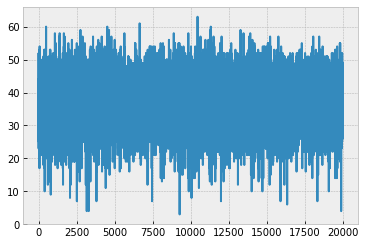

In [18]:
plt.plot(mean_prior_pred[:,0])

In [16]:
hpdi_prior_pred

array([[[44,  2,  2,  0],
        [44,  1,  1,  1],
        [24,  4, 12,  1],
        ...,
        [32,  1,  2,  0],
        [30,  2,  2,  0],
        [37,  3,  5,  0]],

       [[44,  2,  2,  0],
        [44,  1,  1,  1],
        [24,  4, 12,  1],
        ...,
        [32,  1,  2,  0],
        [30,  2,  2,  0],
        [37,  3,  5,  0]]], dtype=int32)

In [27]:
df_exp_ns_h2_p5_rho95

,Per_Gene_Counts_Unaffected_Unaffected,Unaffected_Affected,Affected_Unaffected,Affected_Affected
0,44,2,2,0
1,44,1,1,1
2,24,4,12,1
3,41,1,0,0
4,23,1,2,0
...,...,...,...,...
19995,42,0,0,0
19996,37,2,1,0
19997,32,1,2,0
19998,30,2,2,0


In [32]:
cheats_exp_ns_h2_p5_rho95['Model_No'].to_numpy()

array([0, 0, 3, ..., 0, 1, 0])

{2: 0, 0: 2, 3: 1, 1: 3}

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 2]])

In [41]:
samples_1 = best_chain_exp_ns_h2_p5_rho95.get_samples()
random_key, _random_key = random.split(random_key)
predictive = Predictive(model, samples_1)
predictions = predictive(_random_key, data=df_exp_ns_h2_p5_rho95.to_numpy())

_, _, mapping = get_assumed_order_for_2(best_probs_exp_ns_h2_p5_rho95)
predictions_z_mapped = np.vectorize(mapping.get)(predictions['z'])

# display(predictions)
df = df_exp_ns_h2_p5_rho95.copy(deep=True)
df["Mean Predictions"] = jnp.mean(predictions_z_mapped, axis=0)
df["True Architecture"] = cheats_exp_ns_h2_p5_rho95['Model_No'].to_numpy()
df.to_csv('ns_h2_p5_rho95.csv')
df.head()


,Per_Gene_Counts_Unaffected_Unaffected,Unaffected_Affected,Affected_Unaffected,Affected_Affected,Mean Predictions,True Architecture
0,44,2,2,0,0.14500,0
1,44,1,1,1,0.15250,0
2,24,4,12,1,0.14025,3
3,41,1,0,0,0.14825,0
4,23,1,2,0,0.16075,0


In [8]:
def get_null_gene_p_value(probs, weights, concentrations, observations: np.array, n_samples: Union[int, np.array], prevalences = None, hypothesis_order = None, true_architectures: np.ndarray = None):
    """
    Requires index 3 to be cases for both and index 1 & 2 to be affected by 1, affected by 2, or vice versa
    """
    if hypothesis_order is None:
        hypothesis_order, _ = get_assumed_order_bivariate(probs, data=observations)

    ordered_weights = weights.mean(0)[hypothesis_order]
    ordered_probs = probs.mean(0)[hypothesis_order]
    ordered_concentrations = concentrations.mean(0)[hypothesis_order]
    print('ordered_weights', ordered_weights)
    print('ordered_probs', ordered_probs)
    print('ordered_concentrations', ordered_concentrations)

    dm_model = DirichletMultinomial(concentration=ordered_concentrations)
    # TODO: should we just take this directly from n_samples (make that a vec of ctrl, case1, case2, caseBoth)
    # TODO: name this in-sample prevalences to distinguish from population prevalence?
    # TODO: should we use population prevalence of sample prevalence below?
    if prevalences is None:
        # Alternative estimate, using weighted posterior: (ordered_weights @ ordered_probs)
        prevalences = (observations/observations.sum(1).reshape(observations.shape[0], 1)).mean(0)
        # print("prevalence estimate", prevalences)
        prevalences2 = (ordered_weights @ ordered_probs)
        print('posterior prevalence estimate', prevalences)
        print('posterior prevalence estimate using our stuff', prevalences2)
    else:
        print("Prevalence passed: ", prevalences)
        print("would have used as posterior prevalence estimate: ", (ordered_weights @ ordered_probs))

    if isinstance(n_samples, int):
        print("Estimating sample breakdown using prevalences")
        # sample_proportions = (observations/observations.sum(1).reshape(observations.shape[0], 1)).mean(0)
        n_samples = prevalences * n_samples
    alleles = n_samples*2
    alleles_ctrls, alleles_one_only, alleles_two_only, alleles_both = alleles
    print("alleles", alleles)

    alleles_ctrl1 = alleles_ctrls + alleles_two_only
    alleles_ctrl2 = alleles_ctrls + alleles_one_only
    alleles_case1 = alleles_one_only + alleles_both
    alleles_case2 = alleles_two_only + alleles_both

    P_D1 = prevalences[1]#(n_samples[3] + n_samples[1]) / (n_samples.sum())
    P_D2 = prevalences[2]#(n_samples[3] + n_samples[2]) / (n_samples.sum())

    thresh1 = Inv_Cumulative_Normal(1 - P_D1)
    thresh2 = Inv_Cumulative_Normal(1 - P_D2)

    print('P_D1', P_D1, 'P_D2', P_D2)

    n_genes_used = 0

    if not (type(true_architectures) is np.ndarray and true_architectures.size == len(observations)):
        true_architectures = [None] * len(observations)

    how_many_wrong = 0
    how_many_right = 0
    how_many_mixed_up_one_two = 0
    how_many_mixed_up_both_and_one_or_two = 0
    how_many_called_risk_when_nonrisk = 0
    how_many_called_nonrisk_when_risk = 0
        
    tot_post_neither = 0
    tot_post_one = 0
    tot_post_two = 0
    tot_post_both = 0
    tot_post_affected = 0
    
    cov_sum = 0
    sigma1_mean_est = 0
    sigma1_squared_est = 0 
    sigma2_mean_est = 0
    sigma2_squared_est = 0 
    
    n_is_both = 0
    n_is_two = 0
    n_is_one = 0
    n_is_neither = 0

    inf_rows = 0
    print_out_architecture = []
    for i, obs in enumerate(observations):
        x_ctrl, x_one, x_two, x_both = obs
        
        L_D_given_z = (ordered_probs ** obs).prod(1)
        P_z_i2 = np.multiply(ordered_weights, L_D_given_z)        
        P_z_i2 = P_z_i2/P_z_i2.sum()
        
        print(P_z_i2)

        the_architecture = np.argmax(P_z_i2)
        if the_architecture == 1:
            n_is_two += 1
        elif the_architecture == 2:
            n_is_one += 1
        elif the_architecture == 0:
            n_is_neither += 1
        elif the_architecture == 3:
            n_is_both += 1

        if the_architecture == true_architectures[i]:
            how_many_right += 1
        else:
            how_many_wrong += 1

            if (the_architecture == 1 or the_architecture == 2):
                if true_architectures[i] == 1 or true_architectures[i] == 2:
                    how_many_mixed_up_one_two += 1
                elif true_architectures[i] == 3:
                    how_many_mixed_up_both_and_one_or_two += 1
                else:
                    how_many_called_risk_when_nonrisk += 1
            elif the_architecture == 3:
                if true_architectures[i] == 1 or true_architectures[i] == 2:
                    how_many_mixed_up_both_and_one_or_two += 1
                else:
                    how_many_called_risk_when_nonrisk += 1

            elif the_architecture == 0:
                how_many_called_nonrisk_when_risk += 1

        print_out_architecture.append([i, the_architecture, true_architectures[i], obs, P_z_i2])

        post_neither, post_one, post_two, post_both = P_z_i2

        # if the_architecture == 0:
        #     continue

        if post_both < .005:
            continue

        n_genes_used += 1

        P_V_Ctrl1 = (x_ctrl + x_two) / alleles_ctrl1
        P_V_Ctrl2 = (x_ctrl + x_one) / alleles_ctrl2
        P_V_Case1 = (x_one + x_both) / alleles_case1
        P_V_Case2 = (x_two + x_both) / alleles_case2

        # P_V_Ctrl1 = 1 - x_on1 + x_both
        P_V_1  = P_V_Ctrl1 * (1 - P_D1) + P_V_Case1 * P_D1
        P_D1_V = P_V_Case1 * P_D1 / P_V_1
        sigma1 = thresh1 - Inv_Cumulative_Normal(1 - P_D1_V)

        P_V_2  = P_V_Ctrl2 * (1 - P_D2) + P_V_Case2 * P_D2
        P_D2_V = P_V_Case2 * P_D2 / P_V_2      
        sigma2 = thresh2 - Inv_Cumulative_Normal(1 - P_D2_V)
        if np.isinf(sigma2) or np.isinf(sigma1):
            inf_rows += 1
            continue
        # print("arch vs PD", the_architecture, P_D1_V, P_D2_V)

        # print("P_D2_V", P_D2_V, "P_V_2", P_V_2, "P_D1_V", P_D1_V, "P_V_1", P_V_1)

        tot_post_neither += post_neither
        tot_post_one += post_one + post_both
        tot_post_two += post_two + post_both
        tot_post_both += post_both
        tot_post_affected += post_one + post_two + post_both

        # print("posts", post_one, post_two, post_both)
    
        sigma1_mean_est += (post_one + post_both) * sigma1
        sigma1_squared_est += (post_one + post_both) * sigma1 * sigma1
        
        sigma2_mean_est += (post_two + post_both) * sigma2
        sigma2_squared_est += (post_two + post_both) * sigma2 * sigma2
        
        cov_sum += post_both * sigma1 * sigma2
     
        i += 1

    sigma1_mean_est_f = sigma1_mean_est / tot_post_one
    sigma1_squared_est_f = sigma1_squared_est / tot_post_one
    var1_est = (sigma1_squared_est_f - sigma1_mean_est_f**2) 

    sigma2_mean_est_f = sigma2_mean_est / tot_post_two
    sigma2_squared_est_f = sigma2_squared_est / tot_post_two
    var2_est = (sigma2_squared_est_f - sigma2_mean_est_f**2) 

    cov_sum_f = cov_sum / tot_post_both
    cov = cov_sum_f - sigma1_mean_est_f*sigma2_mean_est_f

    rho = cov / (var1_est * var2_est)**.5

    print('n_genes_used', n_genes_used)
    print('tot_post_one', tot_post_one)
    print('tot_post_two', tot_post_two)
    print('tot_post_both', tot_post_both)
    print('inf_rows', inf_rows)
    print('cov_sum_f', cov_sum_f)
    print('sigma1_mean', sigma1_mean_est_f)
    print('sigma1_^2_mean', sigma1_squared_est_f)
    print('sigma2_mean', sigma2_mean_est_f)
    print('sigma2_^2_mean', sigma2_squared_est_f)
    print('cov', cov)
    print('rho', rho)

    print("how_many_wrong", how_many_wrong)
    print("how_many_right", how_many_right)
    print("how_many_mixed_up_one_two", how_many_mixed_up_one_two)
    print("how_many_mixed_up_both_and_one_or_two", how_many_mixed_up_both_and_one_or_two)
    print("how_many_called_risk_when_nonrisk", how_many_called_risk_when_nonrisk)
    print("how_many_called_nonrisk_when_risk", how_many_called_nonrisk_when_risk)

    return var1_est, var2_est, cov, rho, pd.DataFrame(print_out_architecture, columns=["i", "estimated genetic architecture", "real", "obs", 'P_z_i2'])

In [ ]:
get_null_gene_p_value(probs = best_probs_exp_ns_h2_p5_rho95, weights = best_weights_exp_ns_h2_p5_rho95,
                                         observations = df_exp_ns_h2_p5_rho95_data,
                                         true_architectures = df_exp_ns_h2_p5_rho95_genetic_architectures,
                                         concentrations = best_dirichlet_concentrations_exp_ns_h2_p5_rho95,
                                         # prevalences=real_prevalences,
                                         n_samples = 200_000)

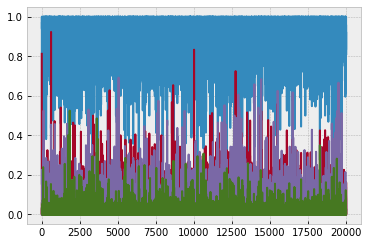

In [49]:
plt.plot(df_exp_ns_h2_p5_rho95_data/df_exp_ns_h2_p5_rho95_data.sum(1).reshape(20_000,1))

In [ ]:
df_exp_old = pd.read_csv('sim/test_old')
display(df_exp_old)
df_exp_old_data = df_exp_ns.to_numpy()
display('df_exp_ns_data', df_exp_ns_data)

In [ ]:
import pandas as pd
import numpy as np

df_exp_ns = pd.read_csv('sim/test_new_steez')
display(df_exp_ns)
df_exp_ns_data = df_exp_ns.to_numpy()
display('df_exp_ns_data', df_exp_ns_data)

cheats_exp_ns= pd.read_csv('sim/test_new_steez.cheat.txt', sep='\t')
df_exp_ns_genetic_architectures = cheats_exp_ns['Model_No'].to_numpy()
display(cheats_exp_ns)
display('df_exp_ns_genetic_architectures', df_exp_ns_genetic_architectures)


# Our best performing model; fits like a champ even challening simulations
random_key, _random_key = random.split(random_key)

res_exp_ns = run_until_enough(random_key=_random_key, target_number_of_chains=1, run_params={
    "data": df_exp_ns_data,
    "max_K": 4,
})
best_chain_exp_ns, statistics_exp_ns = select_best_chain(res_exp_ns)
display(statistics_exp_ns)

#best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain])
best_weights_exp_ns, best_probs_exp_ns, best_betas_exp_ns, best_dirichlet_concentrations_exp_ns = get_parameters(best_chain_exp_ns)

# pds_exp_ns = np.array([0.043475,0.04295,0.012475])
#pd_with_both_exp_ns = np.array([1 - pds_exp_ns.sum(), *pds_exp_ns])
n_samples_exp_ns = 200_000
var1_exp_ns, var2_exp_ns, cov_exp_ns, rho_exp_ns, debug_architectures_exp_ns = get_rho_bivariate(probs = best_probs_exp_ns, weights = best_weights_exp_ns,
                                         observations = df_exp_ns_data,
                                         true_architectures = df_exp_ns_genetic_architectures,
                                         concentrations = best_dirichlet_concentrations_exp_ns,
                                         # prevalences=pd_with_both_exp_ns,
                                         n_samples = n_samples_exp_ns)

# debug_architectures_3.query('`estimated genetic architecture` != real').to_csv('things_we_got_wrong_exp_3.csv')
# debug_architectures_3.query('`estimated genetic architecture` == real').to_csv('things_we_got_right_exp_3.csv')


In [ ]:
import pandas as pd
import numpy as np

df_exp_ns2 = pd.read_csv('sim/test_new_steez1e-3')
display(df_exp_ns2)
df_exp_ns2_data = df_exp_ns2.to_numpy()
display('df_exp_ns2_data', df_exp_ns2_data)

cheats_exp_ns2= pd.read_csv('sim/test_new_steez1e-3.cheat.txt', sep='\t')
df_exp_ns2_genetic_architectures = cheats_exp_ns2['Model_No'].to_numpy()
display(cheats_exp_ns2)
display('df_exp_ns2_genetic_architectures', df_exp_ns2_genetic_architectures)


# Our best performing model; fits like a champ even challening simulations
random_key, _random_key = random.split(random_key)

res_exp_ns2 = run_until_enough(random_key=_random_key, target_number_of_chains=1, run_params={
    "data": df_exp_ns2_data,
    "max_K": 4,
})
best_chain_exp_ns2, statistics_exp_ns2 = select_best_chain(res_exp_ns2)
display(statistics_exp_ns2)

#best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain])
best_weights_exp_ns2, best_probs_exp_ns2, best_betas_exp_ns2, best_dirichlet_concentrations_exp_ns2 = get_parameters(best_chain_exp_ns2)

# pds_exp_ns2 = np.array([0.043475,0.04295,0.012475])
#pd_with_both_exp_ns2 = np.array([1 - pds_exp_ns2.sum(), *pds_exp_ns2])
n_samples_exp_ns2 = 200_000
var1_exp_ns2, var2_exp_ns2, cov_exp_ns2, rho_exp_ns2, debug_architectures_exp_ns2 = get_rho_bivariate(probs = best_probs_exp_ns2, weights = best_weights_exp_ns2,
                                         observations = df_exp_ns2_data,
                                         true_architectures = df_exp_ns2_genetic_architectures,
                                         concentrations = best_dirichlet_concentrations_exp_ns2,
                                         # prevalences=pd_with_both_exp_ns2,
                                         n_samples = n_samples_exp_ns2)

# debug_architectures_3.query('`estimated genetic architecture` != real').to_csv('things_we_got_wrong_exp_3.csv')
# debug_architectures_3.query('`estimated genetic architecture` == real').to_csv('things_we_got_right_exp_3.csv')


In [27]:
cheats_exp_ns

,Gene_No,Model_No,"[[a,b][c,d]]a",b,c,d
0,0,0,0.0,0.0,0.0,0.0
1,1,0,0.0,0.0,0.0,0.0
2,2,0,0.0,0.0,0.0,0.0
3,3,0,0.0,0.0,0.0,0.0
4,4,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
19995,19995,0,0.0,0.0,0.0,0.0
19996,19996,3,0.8,0.8,0.8,0.8
19997,19997,0,0.0,0.0,0.0,0.0
19998,19998,0,0.0,0.0,0.0,0.0


In [30]:
n_samples_exp_ns = 200_000
var1_exp_ns, var2_exp_ns, cov_exp_ns, rho_exp_ns, debug_architectures_exp_ns = get_rho_bivariate(probs = best_probs_exp_ns, weights = best_weights_exp_ns,
                                         observations = df_exp_ns_data,
                                         true_architectures = df_exp_ns_genetic_architectures,
                                         concentrations = best_dirichlet_concentrations_exp_ns,
                                         # prevalences=pd_with_both_exp_ns,
                                         n_samples = n_samples_exp_ns)

display(debug_architectures_exp_ns.query('`estimated genetic architecture` != real'))
display(debug_architectures_exp_ns.query('`estimated genetic architecture` == real'))

debug_architectures_exp_ns.query('`estimated genetic architecture` != real').to_csv('dave_new_genes_we_got_wrong.tsv', sep='\t')

ordered_weights [0.25 0.25 0.25 0.25]
ordered_probs [[0.90197617 0.04181049 0.04061659 0.01559679]
 [0.41870493 0.4715669  0.03176903 0.07795921]
 [0.42226532 0.02976485 0.47383705 0.07413279]
 [0.03605393 0.10961095 0.20753181 0.6468034 ]]
posterior prevalence estimate [0.88295263 0.04943531 0.04790387 0.01970818]
P_D1 0.06914349733716063 P_D2 0.06761205350118348
n_genes_used 73
inf_rows 20
sigma1_mean 2.161475659799669
sigma1_^2_mean 5.116596246765139
sigma2_mean 2.464194477661614
sigma2_^2_mean 6.450838763802236
cov -0.00611076817866163
rho -0.014894309355471634
how_many_wrong 2500
how_many_right 17500
how_many_mixed_up_one_two 0
how_many_mixed_up_both_and_one_or_two 299
how_many_called_risk_when_nonrisk 0
how_many_called_nonrisk_when_risk 2201


,i,estimated genetic architecture,real,obs,P_z_i2
7,7,0,2,"[33, 3, 2, 0]","[0.999999990539842, 8.808547546452543e-09, 6.5..."
9,9,0,3,"[27, 8, 0, 0]","[0.7920086747372407, 0.20799132519689995, 6.58..."
11,11,0,1,"[26, 1, 4, 0]","[0.9999644887441163, 9.119753234218479e-09, 3...."
12,12,0,2,"[42, 2, 3, 0]","[0.9999999999878538, 6.11454464128366e-13, 1.1..."
20,20,0,3,"[36, 4, 0, 1]","[0.9999999188027421, 8.119559567329625e-08, 1...."
...,...,...,...,...,...
19967,19967,0,2,"[33, 2, 0, 0]","[0.9999999987167026, 1.276571857766755e-09, 6...."
19968,19968,0,3,"[35, 0, 9, 1]","[0.9475701071866658, 1.122287031333037e-12, 0...."
19974,19974,0,3,"[40, 4, 2, 0]","[0.9999999995362331, 4.614805927347527e-10, 2...."
19989,19989,0,1,"[30, 4, 4, 0]","[0.9999987770922929, 6.076087793120374e-07, 6...."


,i,estimated genetic architecture,real,obs,P_z_i2
0,0,0,0,"[39, 1, 4, 0]","[0.9999999981573433, 4.239040447029644e-13, 1...."
1,1,0,0,"[35, 2, 1, 1]","[0.9999999988427826, 1.0754840840605823e-09, 8..."
2,2,0,0,"[32, 2, 1, 1]","[0.9999999884520223, 1.0751398644930131e-08, 7..."
3,3,0,0,"[29, 2, 3, 0]","[0.9999997645477915, 1.3155122148391216e-08, 2..."
4,4,0,0,"[30, 2, 0, 0]","[0.9999999871728208, 1.2761633040259703e-08, 6..."
...,...,...,...,...,...
19994,19994,2,2,"[26, 4, 17, 2]","[4.661136638006383e-11, 6.249369288577636e-16,..."
19995,19995,0,0,"[42, 0, 3, 1]","[0.9999999998917961, 2.4025932398701e-14, 1.08..."
19997,19997,0,0,"[50, 4, 1, 1]","[0.9999999999986293, 1.3702986242157416e-12, 4..."
19998,19998,0,0,"[32, 2, 3, 0]","[0.9999999758751343, 1.3159336637035432e-09, 2..."


In [51]:
df_exp_ns_data.sum(1).reshape(20_000, 1)

array([[44],
       [39],
       [36],
       ...,
       [56],
       [37],
       [41]])

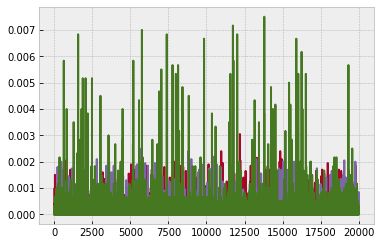

In [55]:
plt.plot(df_exp_ns_data/(np.array([.885, .05, .05, .015])*2*200_000))

In [28]:
debug_architectures_exp_ns.merge(cheats_exp_ns, left_on='i', right_on='Gene_No')

,i,estimated genetic architecture,real,obs,P_z_i2,Gene_No,Model_No,"[[a,b][c,d]]a",b,c,d
0,0,0,0,"[39, 1, 4, 0]","[1.0, 7.732059e-15, 3.047219e-11, 0.0]",0,0,0.0,0.0,0.0,0.0
1,1,0,0,"[35, 2, 1, 1]","[1.0, 1.9616956e-11, 1.3519447e-12, 0.0]",1,0,0.0,0.0,0.0,0.0
2,2,0,0,"[32, 2, 1, 1]","[1.0, 1.9610678e-10, 1.3176134e-11, 0.0]",2,0,0.0,0.0,0.0,0.0
3,3,0,0,"[29, 2, 3, 0]","[1.0, 2.39951e-10, 3.6769945e-09, 0.0]",3,0,0.0,0.0,0.0,0.0
4,4,0,0,"[30, 2, 0, 0]","[1.0, 2.3277369e-10, 1.0841931e-12, 0.0]",4,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
19995,19995,0,0,"[42, 0, 3, 1]","[1.0, 4.3823582e-16, 1.7893931e-12, 0.0]",19995,0,0.0,0.0,0.0,0.0
19996,19996,0,3,"[37, 3, 5, 2]","[1.0, 8.919697e-11, 1.8571013e-08, 0.0]",19996,3,0.8,0.8,0.8,0.8
19997,19997,0,0,"[50, 4, 1, 1]","[1.0, 2.4994407e-14, 7.792041e-18, 0.0]",19997,0,0.0,0.0,0.0,0.0
19998,19998,0,0,"[32, 2, 3, 0]","[1.0, 2.4002784e-11, 3.7728026e-10, 0.0]",19998,0,0.0,0.0,0.0,0.0


In [5]:
import pandas as pd
import numpy as np

df_exp_ns3 = pd.read_csv('sim/test_new_steez_prevalence.1')
display(df_exp_ns3)
df_exp_ns3_data = df_exp_ns3.to_numpy()
display('df_exp_ns3_data', df_exp_ns3_data)

cheats_exp_ns3= pd.read_csv('sim/test_new_steez_prevalence.1.cheat.txt', sep='\t')
df_exp_ns3_genetic_architectures = cheats_exp_ns3['Model_No'].to_numpy()
display(cheats_exp_ns3)
display('df_exp_ns3_genetic_architectures', df_exp_ns3_genetic_architectures)


# Our best performing model; fits like a champ even challening simulations
random_key, _random_key = random.split(random_key)

res_exp_ns3 = run_until_enough(random_key=_random_key, target_number_of_chains=1, run_params={
    "data": df_exp_ns3_data,
    "max_K": 4,
})
best_chain_exp_ns3, statistics_exp_ns3 = select_best_chain(res_exp_ns3)
display(statistics_exp_ns3)

#best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain])
best_weights_exp_ns3, best_probs_exp_ns3, best_betas_exp_ns3, best_dirichlet_concentrations_exp_ns3 = get_parameters(best_chain_exp_ns3)

# pds_exp_ns3 = np.array([0.043475,0.04295,0.012475])
#pd_with_both_exp_ns3 = np.array([1 - pds_exp_ns3.sum(), *pds_exp_ns3])
n_samples_exp_ns3 = 200_000
var1_exp_ns3, var2_exp_ns3, cov_exp_ns3, rho_exp_ns3, debug_architectures_exp_ns3 = get_rho_bivariate(probs = best_probs_exp_ns3, weights = best_weights_exp_ns3,
                                         observations = df_exp_ns3_data,
                                         true_architectures = df_exp_ns3_genetic_architectures,
                                         concentrations = best_dirichlet_concentrations_exp_ns3,
                                         # prevalences=pd_with_both_exp_ns3,
                                         n_samples = n_samples_exp_ns3)

# debug_architectures_3.query('`estimated genetic architecture` != real').to_csv('things_we_got_wrong_exp_3.csv')
# debug_architectures_3.query('`estimated genetic architecture` == real').to_csv('things_we_got_right_exp_3.csv')


,Per_Gene_Counts_Unaffected_Unaffected,Unaffected_Affected,Affected_Unaffected,Affected_Affected
0,0,40,0,4
1,28,3,1,1
2,31,4,2,2
3,2,0,28,0
4,30,2,2,3
...,...,...,...,...
19995,44,1,2,1
19996,40,2,1,2
19997,32,2,2,1
19998,36,1,1,1


'df_exp_ns3_data'

array([[ 0, 40,  0,  4],
       [28,  3,  1,  1],
       [31,  4,  2,  2],
       ...,
       [32,  2,  2,  1],
       [36,  1,  1,  1],
       [25,  3,  1,  1]])

,Gene_No,Model_No,"[[a,b][c,d]]a",b,c,d
0,0,1,0.0,0.0,0.0,0.8
1,1,0,0.0,0.0,0.0,0.0
2,2,0,0.0,0.0,0.0,0.0
3,3,2,0.8,0.0,0.0,0.0
4,4,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
19995,19995,0,0.0,0.0,0.0,0.0
19996,19996,0,0.0,0.0,0.0,0.0
19997,19997,0,0.0,0.0,0.0,0.0
19998,19998,0,0.0,0.0,0.0,0.0


'df_exp_ns3_genetic_architectures'

array([1, 0, 0, ..., 0, 0, 0])

  0%|          | 0/6000 [00:00<?, ?it/s]

alpha 0.0125


sample: 100%|██████████| 6000/6000 [00:38<00:00, 157.30it/s, 7 steps of size 4.51e-01. acc. prob=0.83]  



                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                     beta[0]      0.02      0.00      0.02      0.02      0.03   4747.23      1.00
                     beta[1]      0.03      0.00      0.03      0.02      0.03   3957.59      1.00
                     beta[2]      0.99      0.00      0.99      0.99      0.99   5207.68      1.00
dirichlet_concentration[0,0]      3.42      0.86      3.34      2.07      4.79   4041.82      1.00
dirichlet_concentration[0,1]      2.71      1.68      2.42      0.21      5.12   5462.06      1.00
dirichlet_concentration[0,2]      0.62      0.45      0.51      0.01      1.21   5175.73      1.00
dirichlet_concentration[0,3]      1.00      0.76      0.83      0.02      2.06   5037.89      1.00
dirichlet_concentration[1,0]      3.32      0.83      3.25      1.97      4.63   5004.48      1.00
dirichlet_concentration[1,1]      0.60      0.42      0.50      0.02      1.18   5377.47      1.00
dirichlet

,diverging,accept_prob_mean,accept_prob_std,potential_energy,mcmc_index
0,0.0,0.826216,0.16029,2331586.25,0.0


ordered_weights [0.94328564 0.0246308  0.02461999 0.00746266]
ordered_probs [[0.8197554  0.06934872 0.07607863 0.03481738]
 [0.26527917 0.59064907 0.02775267 0.11631908]
 [0.22512397 0.02485116 0.63116497 0.11885996]
 [0.03794222 0.13074589 0.11184131 0.7194706 ]]
posterior prevalence estimate [0.78563412 0.08146751 0.08888241 0.04401597]
P_D1 0.1254834706441095 P_D2 0.1328983744818056


/home/akotlar/tada/project/mvl2/infer.py:546: RuntimeWarning: invalid value encountered in true_divide
  P_z_i2 = P_z_i2/P_z_i2.sum()


n_genes_used 154
inf_rows 71
sigma1_mean nan
sigma1_^2_mean nan
sigma2_mean nan
sigma2_^2_mean nan
cov nan
rho nan
how_many_wrong 2092
how_many_right 17908
how_many_mixed_up_one_two 0
how_many_mixed_up_both_and_one_or_two 292
how_many_called_risk_when_nonrisk 0
how_many_called_nonrisk_when_risk 1800


In [8]:
import pandas as pd
import numpy as np

df_exp_ns4 = pd.read_csv('sim/test_new_steez_prevalence.1_pi.1')
display(df_exp_ns4)
df_exp_ns4_data = df_exp_ns4.to_numpy()
display('df_exp_ns4_data', df_exp_ns4_data)

cheats_exp_ns4= pd.read_csv('sim/test_new_steez_prevalence.1_pi.1.cheat.txt', sep='\t')
df_exp_ns4_genetic_architectures = cheats_exp_ns4['Model_No'].to_numpy()
display(cheats_exp_ns4)
display('df_exp_ns4_genetic_architectures', df_exp_ns4_genetic_architectures)


# Our best performing model; fits like a champ even challening simulations
random_key, _random_key = random.split(random_key)

res_exp_ns4 = run_until_enough(random_key=_random_key, target_number_of_chains=1, run_params={
    "data": df_exp_ns4_data,
    "max_K": 4,
})
best_chain_exp_ns4, statistics_exp_ns4 = select_best_chain(res_exp_ns4)
display(statistics_exp_ns4)

#best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain])
best_weights_exp_ns4, best_probs_exp_ns4, best_betas_exp_ns4, best_dirichlet_concentrations_exp_ns4 = get_parameters(best_chain_exp_ns4)

# pds_exp_ns4 = np.array([0.043475,0.04295,0.012475])
#pd_with_both_exp_ns4 = np.array([1 - pds_exp_ns4.sum(), *pds_exp_ns4])
n_samples_exp_ns4 = 200_000
var1_exp_ns4, var2_exp_ns4, cov_exp_ns4, rho_exp_ns4, debug_architectures_exp_ns4 = get_rho_bivariate(probs = best_probs_exp_ns4, weights = best_weights_exp_ns4,
                                         observations = df_exp_ns4_data,
                                         true_architectures = df_exp_ns4_genetic_architectures,
                                         concentrations = best_dirichlet_concentrations_exp_ns4,
                                         # prevalences=pd_with_both_exp_ns4,
                                         n_samples = n_samples_exp_ns4)

# debug_architectures_3.query('`estimated genetic architecture` != real').to_csv('things_we_got_wrong_exp_3.csv')
# debug_architectures_3.query('`estimated genetic architecture` == real').to_csv('things_we_got_right_exp_3.csv')


,Per_Gene_Counts_Unaffected_Unaffected,Unaffected_Affected,Affected_Unaffected,Affected_Affected
0,29,2,5,1
1,37,8,1,1
2,30,3,2,1
3,28,4,3,1
4,33,6,5,3
...,...,...,...,...
19995,34,5,5,2
19996,30,3,1,0
19997,26,2,1,2
19998,24,4,3,0


'df_exp_ns4_data'

array([[29,  2,  5,  1],
       [37,  8,  1,  1],
       [30,  3,  2,  1],
       ...,
       [26,  2,  1,  2],
       [24,  4,  3,  0],
       [33,  2,  5,  1]])

,Gene_No,Model_No,"[[a,b][c,d]]a",b,c,d
0,0,0,0.0,0.0,0.0,0.0
1,1,1,0.0,0.0,0.0,0.8
2,2,0,0.0,0.0,0.0,0.0
3,3,0,0.0,0.0,0.0,0.0
4,4,2,0.8,0.0,0.0,0.0
...,...,...,...,...,...,...
19995,19995,0,0.0,0.0,0.0,0.0
19996,19996,0,0.0,0.0,0.0,0.0
19997,19997,1,0.0,0.0,0.0,0.8
19998,19998,0,0.0,0.0,0.0,0.0


'df_exp_ns4_genetic_architectures'

array([0, 1, 0, ..., 1, 0, 0])

  0%|          | 0/6000 [00:00<?, ?it/s]

alpha 0.0125


sample: 100%|██████████| 6000/6000 [00:45<00:00, 132.28it/s, 15 steps of size 3.56e-01. acc. prob=0.89]



                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                     beta[0]      0.05      0.00      0.05      0.04      0.05   5333.38      1.00
                     beta[1]      0.94      0.00      0.94      0.94      0.94   5395.14      1.00
                     beta[2]      0.17      0.01      0.17      0.16      0.19   5362.47      1.00
dirichlet_concentration[0,0]      3.83      0.94      3.76      2.28      5.32   5474.64      1.00
dirichlet_concentration[0,1]      2.11      1.23      1.87      0.28      3.94   5913.58      1.00
dirichlet_concentration[0,2]      0.79      0.51      0.69      0.04      1.49   6309.61      1.00
dirichlet_concentration[0,3]      0.99      0.70      0.86      0.03      1.96   5428.90      1.00
dirichlet_concentration[1,0]      4.23      1.06      4.16      2.45      5.81   5582.27      1.00
dirichlet_concentration[1,1]      0.91      0.59      0.80      0.07      1.72   5557.55      1.00
dirichlet

,diverging,accept_prob_mean,accept_prob_std,potential_energy,mcmc_index
0,0.0,0.887079,0.107337,2347514.5,0.0


ordered_weights [0.8961051  0.04730565 0.04676019 0.00982915]
ordered_probs [[0.7997269  0.08199298 0.08020093 0.03807924]
 [0.43451855 0.4105615  0.04577821 0.10914177]
 [0.44132966 0.04870203 0.40476328 0.10520501]
 [0.10298839 0.1707263  0.1934687  0.53281665]]
posterior prevalence estimate [0.75891301 0.09677756 0.0949076  0.04940183]
P_D1 0.14617938747563333 P_D2 0.14430942844034353
n_genes_used 228
inf_rows 27
sigma1_mean 1.5840282315988243
sigma1_^2_mean 2.831495545015346
sigma2_mean 1.6514398835346618
sigma2_^2_mean 3.0573426282937803
cov 0.0933710023693397
rho 0.286241517744242
how_many_wrong 4584
how_many_right 15416
how_many_mixed_up_one_two 0
how_many_mixed_up_both_and_one_or_two 630
how_many_called_risk_when_nonrisk 1
how_many_called_nonrisk_when_risk 3953


In [7]:
import pandas as pd
import numpy as np

df_exp_ns4_shared_priors = pd.read_csv('sim/test_new_steez_prevalence.1_pi.1')
display(df_exp_ns4_shared_priors)
df_exp_ns4_shared_priors_data = df_exp_ns4_shared_priors.to_numpy()
display('df_exp_ns4_shared_priors_data', df_exp_ns4_shared_priors_data)

cheats_exp_ns4_shared_priors= pd.read_csv('sim/test_new_steez_prevalence.1_pi.1.cheat.txt', sep='\t')
df_exp_ns4_shared_priors_genetic_architectures = cheats_exp_ns4_shared_priors['Model_No'].to_numpy()
display(cheats_exp_ns4_shared_priors)
display('df_exp_ns4_shared_priors_genetic_architectures', df_exp_ns4_shared_priors_genetic_architectures)


# Our best performing model; fits like a champ even challening simulations
random_key, _random_key = random.split(random_key)

res_exp_ns4_shared_priors = run_until_enough(random_key=_random_key, target_number_of_chains=1, run_params={
    "data": df_exp_ns4_shared_priors_data,
    "max_K": 4,
    "shared_dirichlet_prior": True,
})
best_chain_exp_ns4_shared_priors, statistics_exp_ns4_shared_priors = select_best_chain(res_exp_ns4_shared_priors)
display(statistics_exp_ns4_shared_priors)

#best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain])
best_weights_exp_ns4_shared_priors, best_probs_exp_ns4_shared_priors, best_betas_exp_ns4_shared_priors, best_dirichlet_concentrations_exp_ns4_shared_priors = get_parameters(best_chain_exp_ns4_shared_priors)

# pds_exp_ns4_shared_priors = np.array([0.043475,0.04295,0.012475])
#pd_with_both_exp_ns4_shared_priors = np.array([1 - pds_exp_ns4_shared_priors.sum(), *pds_exp_ns4_shared_priors])
n_samples_exp_ns4_shared_priors = 200_000
var1_exp_ns4_shared_priors, var2_exp_ns4_shared_priors, cov_exp_ns4_shared_priors, rho_exp_ns4_shared_priors, debug_architectures_exp_ns4_shared_priors = get_rho_bivariate(probs = best_probs_exp_ns4_shared_priors, weights = best_weights_exp_ns4_shared_priors,
                                         observations = df_exp_ns4_shared_priors_data,
                                         true_architectures = df_exp_ns4_shared_priors_genetic_architectures,
                                         concentrations = best_dirichlet_concentrations_exp_ns4_shared_priors,
                                         # prevalences=pd_with_both_exp_ns4_shared_priors,
                                         n_samples = n_samples_exp_ns4_shared_priors)

# debug_architectures_3.query('`estimated genetic architecture` != real').to_csv('things_we_got_wrong_exp_3.csv')
# debug_architectures_3.query('`estimated genetic architecture` == real').to_csv('things_we_got_right_exp_3.csv')


,Per_Gene_Counts_Unaffected_Unaffected,Unaffected_Affected,Affected_Unaffected,Affected_Affected
0,29,2,5,1
1,37,8,1,1
2,30,3,2,1
3,28,4,3,1
4,33,6,5,3
...,...,...,...,...
19995,34,5,5,2
19996,30,3,1,0
19997,26,2,1,2
19998,24,4,3,0


'df_exp_ns4_shared_priors_data'

array([[29,  2,  5,  1],
       [37,  8,  1,  1],
       [30,  3,  2,  1],
       ...,
       [26,  2,  1,  2],
       [24,  4,  3,  0],
       [33,  2,  5,  1]])

,Gene_No,Model_No,"[[a,b][c,d]]a",b,c,d
0,0,0,0.0,0.0,0.0,0.0
1,1,1,0.0,0.0,0.0,0.8
2,2,0,0.0,0.0,0.0,0.0
3,3,0,0.0,0.0,0.0,0.0
4,4,2,0.8,0.0,0.0,0.0
...,...,...,...,...,...,...
19995,19995,0,0.0,0.0,0.0,0.0
19996,19996,0,0.0,0.0,0.0,0.0
19997,19997,1,0.0,0.0,0.0,0.8
19998,19998,0,0.0,0.0,0.0,0.0


'df_exp_ns4_shared_priors_genetic_architectures'

array([0, 1, 0, ..., 1, 0, 0])

alpha 0.0125
doing shared priors
doing shared priors


  0%|          | 0/6000 [00:00<?, ?it/s]

doing shared priors


sample: 100%|██████████| 6000/6000 [00:26<00:00, 224.36it/s, 7 steps of size 4.70e-01. acc. prob=0.88] 



                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.05      0.00      0.05      0.04      0.05   5425.98      1.00
                   beta[1]      0.05      0.00      0.05      0.05      0.05   5369.17      1.00
                   beta[2]      0.99      0.00      0.99      0.99      0.99   4927.64      1.00
dirichlet_concentration[0]      3.23      0.69      3.18      2.09      4.32   4335.57      1.00
dirichlet_concentration[1]      1.20      0.46      1.15      0.47      1.91   5146.39      1.00
dirichlet_concentration[2]      1.20      0.47      1.14      0.46      1.92   4663.26      1.00
dirichlet_concentration[3]      1.15      0.46      1.10      0.41      1.85   4585.11      1.00
                probs[0,0]      0.43      0.00      0.43      0.43      0.44   4632.43      1.00
                probs[0,1]      0.41      0.00      0.41      0.41      0.42   4677.83      1.00
                probs[0,2]   

,diverging,accept_prob_mean,accept_prob_std,potential_energy,mcmc_index
0,0.0,0.880072,0.11326,2347503.75,0.0


ordered_weights [0.896023   0.04732287 0.04685086 0.00980468]
ordered_probs [[0.79973394 0.08200081 0.080185   0.03808033]
 [0.43451625 0.41054538 0.04578635 0.10915205]
 [0.44138107 0.04870085 0.4047071  0.10521103]
 [0.10314487 0.17080137 0.19342323 0.53263056]]
posterior prevalence estimate [0.75891301 0.09677756 0.0949076  0.04940183]
P_D1 0.14617938747563333 P_D2 0.14430942844034353
n_genes_used 228
inf_rows 27
sigma1_mean 1.5839896879804591
sigma1_^2_mean 2.8313755109369088
sigma2_mean 1.65127346896793
sigma2_^2_mean 3.056846946170401
cov 0.09322019227121459
rho 0.2857549244094648
how_many_wrong 4584
how_many_right 15416
how_many_mixed_up_one_two 0
how_many_mixed_up_both_and_one_or_two 630
how_many_called_risk_when_nonrisk 1
how_many_called_nonrisk_when_risk 3953


In [5]:
model?

Signature:
model(
    data: Union[numpy._array_like._SupportsArray[numpy.dtype], numpy._nested_sequence._NestedSequence[numpy._array_like._SupportsArray[numpy.dtype]], bool, int, float, complex, str, bytes, numpy._nested_sequence._NestedSequence[Union[bool, int, float, complex, str, bytes]]] = None,
    k_hypotheses: int = 4,
    alpha: float = 0.05,
    shared_dirichlet_prior: bool = False,
    gamma_shape: Union[float, numpy._array_like._SupportsArray[numpy.dtype], numpy._nested_sequence._NestedSequence[numpy._array_like._SupportsArray[numpy.dtype]], bool, int, complex, str, bytes, numpy._nested_sequence._NestedSequence[Union[bool, int, float, complex, str, bytes]]] = None,
    gamma_rate: Union[float, numpy._array_like._SupportsArray[numpy.dtype], numpy._nested_sequence._NestedSequence[numpy._array_like._SupportsArray[numpy.dtype]], bool, int, complex, str, bytes, numpy._nested_sequence._NestedSequence[Union[bool, int, float, complex, str, bytes]]] = None,
)
Docstring:
Parameters
--

In [8]:
import pandas as pd
import numpy as np

df_exp_ns4_K50 = pd.read_csv('sim/test_new_steez_prevalence.1_pi.1')
display(df_exp_ns4_K50)
df_exp_ns4_K50_data = df_exp_ns4_K50.to_numpy()
display('df_exp_ns4_K50_data', df_exp_ns4_K50_data)

cheats_exp_ns4_K50= pd.read_csv('sim/test_new_steez_prevalence.1_pi.1.cheat.txt', sep='\t')
df_exp_ns4_K50_genetic_architectures = cheats_exp_ns4_K50['Model_No'].to_numpy()
display(cheats_exp_ns4_K50)
display('df_exp_ns4_K50_genetic_architectures', df_exp_ns4_K50_genetic_architectures)


# Our best performing model; fits like a champ even challening simulations
random_key, _random_key = random.split(random_key)

res_exp_ns4_K50 = run_until_enough(random_key=_random_key, target_number_of_chains=1, run_params={
    "data": df_exp_ns4_K50_data,
    "max_K": 50,
})
best_chain_exp_ns4_K50, statistics_exp_ns4_K50 = select_best_chain(res_exp_ns4_K50)
display(statistics_exp_ns4_K50)

#best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain])
best_weights_exp_ns4_K50, best_probs_exp_ns4_K50, best_betas_exp_ns4_K50, best_dirichlet_concentrations_exp_ns4_K50 = get_parameters(best_chain_exp_ns4_K50)

# pds_exp_ns4_K50 = np.array([0.043475,0.04295,0.012475])
#pd_with_both_exp_ns4_K50 = np.array([1 - pds_exp_ns4_K50.sum(), *pds_exp_ns4_K50])
n_samples_exp_ns4_K50 = 200_000
var1_exp_ns4_K50, var2_exp_ns4_K50, cov_exp_ns4_K50, rho_exp_ns4_K50, debug_architectures_exp_ns4_K50 = get_rho_bivariate(probs = best_probs_exp_ns4_K50, weights = best_weights_exp_ns4_K50,
                                         observations = df_exp_ns4_K50_data,
                                         true_architectures = df_exp_ns4_K50_genetic_architectures,
                                         concentrations = best_dirichlet_concentrations_exp_ns4_K50,
                                         # prevalences=pd_with_both_exp_ns4_K50,
                                         n_samples = n_samples_exp_ns4_K50)

# debug_architectures_3.query('`estimated genetic architecture` != real').to_csv('things_we_got_wrong_exp_3.csv')
# debug_architectures_3.query('`estimated genetic architecture` == real').to_csv('things_we_got_right_exp_3.csv')


,Per_Gene_Counts_Unaffected_Unaffected,Unaffected_Affected,Affected_Unaffected,Affected_Affected
0,39,10,1,2
1,30,3,5,1
2,25,2,5,1
3,26,1,2,2
4,39,3,4,0
...,...,...,...,...
19995,35,0,5,1
19996,40,4,1,4
19997,37,2,1,1
19998,30,1,5,0


'df_exp_ns4_K50_data'

array([[39, 10,  1,  2],
       [30,  3,  5,  1],
       [25,  2,  5,  1],
       ...,
       [37,  2,  1,  1],
       [30,  1,  5,  0],
       [31,  4,  3,  2]])

,Gene_No,Model_No,"[[a,b][c,d]]a",b,c,d
0,0,1,0.0,0.0,0.0,0.8
1,1,0,0.0,0.0,0.0,0.0
2,2,0,0.0,0.0,0.0,0.0
3,3,0,0.0,0.0,0.0,0.0
4,4,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
19995,19995,0,0.0,0.0,0.0,0.0
19996,19996,3,0.8,0.8,0.8,0.8
19997,19997,0,0.0,0.0,0.0,0.0
19998,19998,0,0.0,0.0,0.0,0.0


'df_exp_ns4_K50_genetic_architectures'

array([1, 0, 0, ..., 0, 0, 0])

alpha 0.001


sample: 100%|██████████| 6000/6000 [01:11<00:00, 83.74it/s, 8 steps of size 2.87e-02. acc. prob=0.70]  



                                   mean       std    median      5.0%     95.0%     n_eff     r_hat
                      beta[0]      0.05      0.01      0.05      0.03      0.07     10.24      1.27
                      beta[1]      0.80      0.01      0.81      0.78      0.82      9.71      1.00
                      beta[2]      0.01      0.00      0.01      0.00      0.01     53.95      1.00
                      beta[3]      0.02      0.00      0.02      0.01      0.02     21.03      1.00
                      beta[4]      0.10      0.03      0.10      0.05      0.15      6.41      1.32
                      beta[5]      0.04      0.00      0.04      0.03      0.04     29.63      1.08
                      beta[6]      0.01      0.00      0.01      0.01      0.02     21.58      1.00
                      beta[7]      0.01      0.00      0.01      0.01      0.01     24.74      1.03
                      beta[8]      0.08      0.02      0.08      0.06      0.11     14.03      1.01

  0%|          | 0/6000 [00:00<?, ?it/s]

weights.mean(0) [4.94911075e-02 7.63283551e-01 1.03076035e-03 3.59578710e-03
 1.75161771e-02 5.83137432e-03 2.32582609e-03 1.65314204e-03
 1.20243970e-02 6.91156695e-03 4.54764962e-02 2.56310087e-02
 1.31958758e-03 2.32189950e-02 2.00777617e-03 8.36827233e-03
 1.13788573e-02 5.50998049e-03 2.57289247e-03 6.00443874e-03
 2.84140045e-03 1.13707851e-03 3.87998676e-04 4.08271968e-04
 5.86882743e-05 1.09652774e-05 1.59455067e-06 1.79278220e-06
 3.87424954e-08 4.18392112e-08 5.63975699e-10 2.06662448e-11
 4.44542580e-12 7.15671283e-14 2.41493769e-14 4.39006589e-15
 2.61534101e-16 1.01946894e-16 2.47111953e-17 3.01364612e-20
 1.04684214e-20 1.14173906e-23 9.88484129e-25 1.23413517e-25
 5.88516909e-25 4.64192209e-28 5.72769203e-32 4.61625213e-32
 6.16569315e-36 2.99963474e-37]
probs.mean(0) [[0.7063412  0.0635462  0.17118907 0.05892361]
 [0.8120033  0.07420215 0.07780195 0.03599255]
 [0.04353974 0.0363212  0.4945219  0.4256172 ]
 [0.06559167 0.00404099 0.81749755 0.11286985]
 [0.6172005  0.162

sample: 100%|██████████| 6000/6000 [01:25<00:00, 69.81it/s, 21 steps of size 1.41e-02. acc. prob=0.81]  



                                   mean       std    median      5.0%     95.0%     n_eff     r_hat
                      beta[0]      0.00      0.00      0.00      0.00      0.00     23.78      1.08
                      beta[1]      0.81      0.00      0.81      0.80      0.82     29.91      1.05
                      beta[2]      0.10      0.01      0.10      0.08      0.11      7.55      1.13
                      beta[3]      0.26      0.02      0.26      0.24      0.29     22.80      1.04
                      beta[4]      0.40      0.02      0.40      0.37      0.43     22.13      1.00
                      beta[5]      0.05      0.01      0.05      0.04      0.06     11.42      1.15
                      beta[6]      0.20      0.02      0.20      0.17      0.23     12.84      1.08
                      beta[7]      0.02      0.01      0.02      0.01      0.03     20.57      1.02
                      beta[8]      0.02      0.01      0.02      0.01      0.03     13.79      1.13

,diverging,accept_prob_mean,accept_prob_std,potential_energy,mcmc_index
0,4000.0,0.811241,0.171053,2336439.25,0.0


KeyError: 0

In [ ]:
######### Using old dave program ############

In [9]:
!cat sim/simulations/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.05_pi12_0.05_h2_1_0.6_h2_2_0.8_rho_0.8/results.csv.ss

Args are: Prev_Disorder1,Prev_Disorder2,Sample_Size,No_Genes,Mean_Rare_Freq_Per_Gene,FractionGenes1_only,FractionGenes2_only,FractionBoth,Rare_h2_1,rare_h2_2,rho,outfile
Args val: 0.02,0.02,200000,20000,0.0001,0.05,0.05,0.05,0.6,0.8,0.8,pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.05_pi12_0.05_h2_1_0.6_h2_2_0.8_rho_0.8/results.csv

 Disorder 0 has a prev = 0.02 and thres = 2.0541885887219 

 Disorder 1 has a prev = 0.02 and thres = 2.0541885887219 

 h2[0] = 0.6  h2[1] =0.8   rho = 0.8 

 Stupid_sum[0] = -1.48461154481083e-09   and stupid_sum[1] = -7.15402714845936e-09 

 Before normalization total variances were 0.430650105546375 and 0.426127598071973 

Normalizing by 1.1803569083496

 For disorder 0 we expected a prevalence of 0.02 and got 0.03669 with 7338 out of 200000

 Genetic mean liability  = -2.07801553742115e-16 Genetic Variance in Liabilty = 0.429472061647336
 Residual mean liability  = -0.000410460644854633 Residual Variance in Liabilty = 0.287264454906469
 Total mean liability

In [3]:
import pandas as pd
import numpy as np

df_exp2 = pd.read_csv('sim/simulations/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.05_pi12_0.05_h2_1_0.6_h2_2_0.8_rho_0.8/results.csv')
# disorder 1, disorder 2, comorbid
# the order though is ctrl, unaffected_affected, affected_unaffedcted, affected_affected, aka ctrl, case2, case1, caseboth
pds_exp2 = np.array([0.043745,0.03669,0.00995])
pd_with_both_exp2 = np.array([1 - pds_exp2.sum(), *pds_exp2])
n_samples_exp2 = 200_000
n_cases_exp2 = n_samples_exp2 * pds_exp2
n_ctrls_exp2 = n_samples_exp2 - n_cases_exp2.sum()

display(df_exp2)

run_params_exp2 = {
    "data": df_exp2.to_numpy(),
    "max_K": 4,
}

# Our best performing model; fits like a champ even challening simulations
random_key, _random_key = random.split(random_key)

res_exp2 = run_until_enough(random_key=_random_key, run_params=run_params_exp2)
best_chain_exp2, statistics_exp2 = select_best_chain(res_exp2)
display(statistics_exp2)

#best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain])
best_weights_exp2, best_probs_exp2, best_betas_exp2, best_dirichlet_concentrations_exp2 = get_parameters(best_chain_exp2)

,Per_Gene_Counts_Unaffected_Unaffected,Unaffected_Affected,Affected_Unaffected,Affected_Affected
0,50,1,4,0
1,41,1,0,0
2,37,1,2,0
3,31,2,6,1
4,42,1,2,1
...,...,...,...,...
19995,29,0,1,1
19996,39,1,0,1
19997,28,0,3,0
19998,36,2,1,0


alpha 0.0125


sample: 100%|██████████| 6000/6000 [00:36<00:00, 163.19it/s, 7 steps of size 4.19e-01. acc. prob=0.86] 



                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                     beta[0]      0.04      0.00      0.04      0.04      0.05   3459.16      1.00
                     beta[1]      0.04      0.00      0.04      0.04      0.05   3170.59      1.00
                     beta[2]      0.96      0.00      0.96      0.96      0.96   3541.66      1.00
dirichlet_concentration[0,0]      5.47      0.99      5.40      3.89      7.10   4254.75      1.00
dirichlet_concentration[0,1]      1.53      1.00      1.33      0.08      2.95   4406.82      1.00
dirichlet_concentration[0,2]      0.50      0.37      0.41      0.01      0.99   4556.96      1.00
dirichlet_concentration[0,3]      0.55      0.43      0.45      0.01      1.13   4571.35      1.00
dirichlet_concentration[1,0]      5.45      0.97      5.40      3.88      6.98   4469.10      1.00
dirichlet_concentration[1,1]      1.25      0.86      1.07      0.04      2.46   5258.49      1.00
dirichlet

sample: 100%|██████████| 6000/6000 [00:39<00:00, 151.69it/s, 15 steps of size 2.80e-01. acc. prob=0.91]



                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                     beta[0]      0.04      0.00      0.04      0.03      0.04   5156.36      1.00
                     beta[1]      0.04      0.00      0.04      0.04      0.05   6666.84      1.00
                     beta[2]      0.95      0.00      0.95      0.95      0.96   5839.49      1.00
dirichlet_concentration[0,0]      5.50      1.02      5.43      3.84      7.15   7622.70      1.00
dirichlet_concentration[0,1]      0.53      0.39      0.44      0.01      1.06   7623.75      1.00
dirichlet_concentration[0,2]      1.36      0.91      1.19      0.04      2.61   7857.09      1.00
dirichlet_concentration[0,3]      0.54      0.44      0.43      0.00      1.12   6789.28      1.00
dirichlet_concentration[1,0]      5.44      1.02      5.37      3.80      7.09   7770.78      1.00
dirichlet_concentration[1,1]      1.27      0.87      1.11      0.06      2.46   7694.96      1.00
dirichlet

  0%|          | 0/6000 [00:00<?, ?it/s]

weights.mean(0) [0.03723424 0.0429673  0.87724316 0.04255478]
probs.mean(0) [[0.7664949  0.01660644 0.1897624  0.02713629]
 [0.6516818  0.14772844 0.09959592 0.10099383]
 [0.92727655 0.03450163 0.02787831 0.01034355]
 [0.7305276  0.23075478 0.01321055 0.02550716]]
alpha 0.0125


sample: 100%|██████████| 6000/6000 [01:21<00:00, 73.80it/s, 7 steps of size 3.68e-01. acc. prob=0.88]  



                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                     beta[0]      0.04      0.00      0.04      0.03      0.04   4645.87      1.00
                     beta[1]      0.04      0.00      0.04      0.04      0.05   4624.14      1.00
                     beta[2]      0.95      0.00      0.95      0.95      0.96   4866.06      1.00
dirichlet_concentration[0,0]      5.53      0.99      5.47      3.87      7.12   5436.85      1.00
dirichlet_concentration[0,1]      0.53      0.39      0.43      0.01      1.04   5429.03      1.00
dirichlet_concentration[0,2]      1.38      0.91      1.22      0.07      2.64   5307.29      1.00
dirichlet_concentration[0,3]      0.53      0.43      0.43      0.01      1.12   5284.65      1.00
dirichlet_concentration[1,0]      5.46      0.98      5.39      3.91      7.05   5498.56      1.00
dirichlet_concentration[1,1]      1.52      0.99      1.32      0.15      2.95   5525.27      1.00
dirichlet

  0%|          | 0/6000 [00:00<?, ?it/s]

weights.mean(0) [0.03725385 0.04266066 0.87726927 0.04281553]
probs.mean(0) [[0.7665239  0.01661657 0.1897043  0.02715524]
 [0.7306403  0.2306096  0.01322513 0.02552498]
 [0.9272759  0.03450302 0.02787784 0.01034326]
 [0.6515483  0.14776416 0.09963616 0.10105139]]
alpha 0.0125


sample: 100%|██████████| 6000/6000 [00:43<00:00, 137.01it/s, 15 steps of size 3.13e-01. acc. prob=0.90]



                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                     beta[0]      0.88      0.00      0.88      0.87      0.88   8985.08      1.00
                     beta[1]      0.30      0.01      0.30      0.29      0.32   6566.60      1.00
                     beta[2]      0.50      0.02      0.50      0.47      0.52   5564.59      1.00
dirichlet_concentration[0,0]      5.59      1.00      5.53      4.04      7.22   8974.40      1.00
dirichlet_concentration[0,1]      0.65      0.47      0.54      0.03      1.31   7631.42      1.00
dirichlet_concentration[0,2]      0.59      0.43      0.50      0.01      1.17   6969.10      1.00
dirichlet_concentration[0,3]      0.40      0.33      0.31      0.00      0.85   6743.67      1.00
dirichlet_concentration[1,0]      5.50      0.99      5.47      3.93      7.15   8447.05      1.00
dirichlet_concentration[1,1]      0.52      0.37      0.44      0.02      1.04   6675.27      1.00
dirichlet

,diverging,accept_prob_mean,accept_prob_std,potential_energy,mcmc_index
1,0.0,0.906381,0.090982,2300072.5,1.0
3,0.0,0.901907,0.095699,2300066.0,3.0
2,0.0,0.882624,0.113058,2300067.0,2.0
0,0.0,0.857780,0.131228,2300074.0,0.0


In [6]:
#best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain])
best_weights_exp2, best_probs_exp2, best_betas_exp2, best_dirichlet_concentrations_exp2 = get_parameters(best_chain_exp2)

pds_exp2 = np.array([0.043745,0.03669,0.00995])
pd_with_both_exp2 = np.array([1 - pds_exp2.sum(), *pds_exp2])
n_samples_exp2 = 200_000
var1_2, var2_2, cov_2, rho_2 = get_rho_bivariate(probs = best_probs_exp2, weights = best_weights_exp2,
                                         observations = df_exp2.to_numpy(),
                                         concentrations = best_dirichlet_concentrations_exp2,
                                         prevalences=pd_with_both_exp2,
                                         n_samples = n_samples_exp2)

ordered_weights [0.8772195  0.04266028 0.03716154 0.04295733]
ordered_probs [[0.92727786 0.03449934 0.02787906 0.01034378]
 [0.7306144  0.23065655 0.01321766 0.02551145]
 [0.7663849  0.01658704 0.18987462 0.02715351]
 [0.6516569  0.1477144  0.09962822 0.10100048]]
n_genes_used 1723
inf_rows 0
sigma1_mean 0.8884253230987391
sigma1_^2_mean 0.8515557210048521
sigma2_mean 0.7847759583895323
sigma2_^2_mean 0.6885669530357982
cov 0.03166463110211193
rho 0.470690045611378


In [4]:
jnp.exp(Normal(0,1).log_prob(2))

DeviceArray(0.05399096, dtype=float32, weak_type=True)

In [5]:
np.multiply(best_weights_exp2.mean(0), (best_probs_exp2 * 1e-4 / pd_with_both_exp2).mean(0))

array([[3.4265279e-06, 2.7005693e-05, 2.6505410e-05, 9.5280848e-06],
       [3.0562232e-06, 1.7294675e-05, 1.9978468e-04, 3.7721940e-05],
       [4.3488653e-06, 4.0392461e-06, 5.5905948e-05, 3.8632224e-06],
       [3.5942892e-06, 1.9420413e-06, 3.8075601e-04, 1.0141368e-05]],
      dtype=float32)

In [6]:
best_weights_exp2.mean(0) @ (best_probs_exp2 * 1e-4 / pd_with_both_exp2).mean(0)

DeviceArray([9.9060351e-05, 1.2827796e-04, 8.3108287e-05, 1.5587805e-04],            dtype=float32)

In [7]:
(best_probs_exp2 * 1e-4 / pd_with_both_exp2).mean(0)

DeviceArray([[8.0321268e-05, 6.2866323e-04, 3.0215253e-05, 2.5639642e-04],
             [7.1640956e-05, 4.0260126e-04, 2.2774766e-04, 1.0150803e-03],
             [1.0194179e-04, 9.4029267e-05, 6.3730855e-05, 1.0395755e-04],
             [8.4253763e-05, 4.5208613e-05, 4.3404874e-04, 2.7289958e-04]],            dtype=float32)

In [8]:
(8.0321268e-05*9.9e-5 + 7.16e-5*9.9e-5 + 1.02e-4*9.9e-5 + 8.425e-05*9.9e-5)

3.3478955532e-08

In [9]:
best_weights_exp2.mean(0)

array([0.04266028, 0.04295733, 0.8772195 , 0.03716154], dtype=float32)

In [6]:
df_exp2 / 400_000 # this is P(V|D) for each D (unaffected_unaffected, unaffected_affectd, etc)

,Per_Gene_Counts_Unaffected_Unaffected,Unaffected_Affected,Affected_Unaffected,Affected_Affected
0,0.000125,0.000003,0.000010,0.000000
1,0.000102,0.000003,0.000000,0.000000
2,0.000092,0.000003,0.000005,0.000000
3,0.000077,0.000005,0.000015,0.000003
4,0.000105,0.000003,0.000005,0.000003
...,...,...,...,...
19995,0.000073,0.000000,0.000003,0.000003
19996,0.000097,0.000003,0.000000,0.000003
19997,0.000070,0.000000,0.000008,0.000000
19998,0.000090,0.000005,0.000003,0.000000


In [21]:
#To get to P(D|V) we need to divide by P(V) and multiply by P(D)
# P(V|D) = P(D|V)P(V)/P(D)
((df_exp2 / 400_000)/(1e-4))*pd_with_both_exp2

,Per_Gene_Counts_Unaffected_Unaffected,Unaffected_Affected,Affected_Unaffected,Affected_Affected
0,1.137019,0.000917,0.004374,0.000000
1,0.932355,0.000917,0.000000,0.000000
2,0.841394,0.000917,0.002187,0.000000
3,0.704952,0.001835,0.006562,0.000249
4,0.955096,0.000917,0.002187,0.000249
...,...,...,...,...
19995,0.659471,0.000000,0.001094,0.000249
19996,0.886875,0.000917,0.000000,0.000249
19997,0.636730,0.000000,0.003281,0.000000
19998,0.818653,0.001835,0.001094,0.000000


In [16]:
df_exp2 / (200_000 *2*pd_with_both_exp2)

,Per_Gene_Counts_Unaffected_Unaffected,Unaffected_Affected,Affected_Unaffected,Affected_Affected
0,0.000137,0.000068,0.000229,0.000000
1,0.000113,0.000068,0.000000,0.000000
2,0.000102,0.000068,0.000114,0.000000
3,0.000085,0.000136,0.000343,0.000251
4,0.000115,0.000068,0.000114,0.000251
...,...,...,...,...
19995,0.000080,0.000000,0.000057,0.000251
19996,0.000107,0.000068,0.000000,0.000251
19997,0.000077,0.000000,0.000171,0.000000
19998,0.000099,0.000136,0.000057,0.000000


In [18]:
np.array([0.76648414, 0.01662662, 0.18973051, 0.0271588 ]) * 1e-4 / (.036)

array([2.12912261e-03, 4.61850556e-05, 5.27029194e-04, 7.54411111e-05])

In [49]:
best_weights_exp2.mean(0) @ best_probs_exp2.mean(0)

DeviceArray([0.9010679 , 0.04706518, 0.03635572, 0.01550986], dtype=float32)

In [60]:
(best_probs_exp2.mean(0)*1e-4/np.array([0.9010679 , 0.04706518, 0.03635572, 0.01550986]))

DeviceArray([[8.10831698e-05, 4.90078935e-04, 3.63564868e-05,
              1.64485333e-04],
             [7.23205085e-05, 3.13850702e-04, 2.74037244e-04,
              6.51201699e-04],
             [1.02908765e-04, 7.33011839e-05, 7.66841113e-05,
              6.66916094e-05],
             [8.50529541e-05, 3.52426978e-05, 5.22268878e-04,
              1.75072521e-04]], dtype=float32)

In [63]:
(np.array([8.10831698e-05, 4.90078935e-04, 3.63564868e-05,
              1.64485333e-04]) * .9010679)

array([7.30614415e-05, 4.41594397e-04, 3.27596632e-05, 1.48212454e-04])

In [64]:
.04706518 * np.array([7.23205085e-05, 3.13850702e-04, 2.74037244e-04,
              6.51201699e-04])

array([3.40377775e-06, 1.47714398e-05, 1.28976122e-05, 3.06489252e-05])

In [65]:
0.03635572 * np.array([1.02908765e-04, 7.33011839e-05, 7.66841113e-05,
              6.66916094e-05])

array([3.74132225e-06, 2.66491732e-06, 2.78790608e-06, 2.42462148e-06])

In [66]:
.01550986 * np.array([8.50529541e-05, 3.52426978e-05, 5.22268878e-04,
              1.75072521e-04])

array([1.31915941e-06, 5.46609309e-07, 8.10031718e-06, 2.71535029e-06])

In [69]:
manual = np.stack([(np.array([8.10831698e-05, 4.90078935e-04, 3.63564868e-05,
              1.64485333e-04]) * .9010679),
         .04706518 * np.array([7.23205085e-05, 3.13850702e-04, 2.74037244e-04,
              6.51201699e-04]),
         0.03635572 * np.array([1.02908765e-04, 7.33011839e-05, 7.66841113e-05,
              6.66916094e-05]),
         .01550986 * np.array([8.50529541e-05, 3.52426978e-05, 5.22268878e-04,
              1.75072521e-04])])
manual

array([[7.30614415e-05, 4.41594397e-04, 3.27596632e-05, 1.48212454e-04],
       [3.40377775e-06, 1.47714398e-05, 1.28976122e-05, 3.06489252e-05],
       [3.74132225e-06, 2.66491732e-06, 2.78790608e-06, 2.42462148e-06],
       [1.31915941e-06, 5.46609309e-07, 8.10031718e-06, 2.71535029e-06]])

In [71]:
manual.sum(1)

array([6.95627955e-04, 6.17217549e-05, 1.16187671e-05, 1.26814362e-05])

In [76]:
best_weights_exp2.mean(0) 

array([0.04266028, 0.04295733, 0.8772195 , 0.03716154], dtype=float32)

In [82]:
(best_probs_exp2*1e-4/np.array([0.9010679 , 0.04706518, 0.03635572, 0.01550986])).mean(0)

DeviceArray([[8.10831698e-05, 4.90078935e-04, 3.63564868e-05,
              1.64485347e-04],
             [7.23205085e-05, 3.13850673e-04, 2.74037244e-04,
              6.51201699e-04],
             [1.02908765e-04, 7.33011984e-05, 7.66841185e-05,
              6.66916094e-05],
             [8.50529468e-05, 3.52427014e-05, 5.22268936e-04,
              1.75072535e-04]], dtype=float32)

In [ ]:
.04266028 * [8.1e-05, 7.23e-05, 1.02

In [83]:
.87*.92

0.8004

In [84]:
.037*.766

0.028342

In [86]:
.037*.76

0.02812

In [ ]:
.037

In [75]:
best_weights_exp2.mean(0) @ (best_probs_exp2*1e-4/np.array([0.9010679 , 0.04706518, 0.03635572, 0.01550986])).mean(0)

DeviceArray([0.0001, 0.0001, 0.0001, 0.0001], dtype=float32)

In [91]:
(df_exp2['Unaffected_Affected'] / (200_000 * .047*2)).mean()

0.00010005585106382979

In [17]:
200_000 *2*pd_with_both_exp2

array([363846.,  14676.,  17498.,   3980.])

In [15]:
pd_with_both_exp2

array([0.909615, 0.03669 , 0.043745, 0.00995 ])

In [5]:
def ga(probs: np.ndarray, prevalences: np.ndarray = None, data: np.ndarray = None, data_columns: List[str] = ['unaffected', 'affected1', 'affected2', 'affected12']):
    """
    Infer the order of hypotheses for 2 conditions and 4 channels: ctrls, cases1, cases2, cases_both
    prevalences: Iterable[Union[int, float]]
        The list of prevalences for each of the condition columns (ex: ctrls, cases1, cases2, cases for both). Should be in the same order as the data columns
        The last element of the prevalences array should be comorbidity, if known
    """
    hypotheses = {}

    mapping= {
        'unaffected': 'P(~D|V,H)',
        'affected1': 'P(D1|V,H)',
        'affected2': 'P(D2|V,H)',
        'affected12': 'P(D12|V,H)'
    }
    
    poss = "0123"

    if prevalences is None:
        assert data is not None
        prevalences = (data/data.sum(1).reshape(data.shape[0], 1)).mean(0)
        print('prevalences', prevalences)
    probs_mean = probs.mean(0)
    probs_mean_df = pd.DataFrame(probs_mean, dtype='float32', columns=[mapping[x] for x in data_columns])

    pdiff = np.abs(probs_mean - prevalences)
    
    h0 = -1
    min_sum = 1
    idx = -1
    for row in pdiff:
        idx += 1
        s = row.sum()

        if s < min_sum:
            h0 = idx
            min_sum = s

    hypotheses[h0] = 'H0'
    
    h1 = (probs_mean_df['P(D1|V,H)'] - probs_mean_df['P(D2|V,H)']).idxmax()
    hypotheses[h1] = 'H1'

    h2 = (probs_mean_df['P(D2|V,H)'] - probs_mean_df['P(D1|V,H)']).idxmax()
    hypotheses[h2] = 'H2'
    
    h12 = (probs_mean_df['P(D12|V,H)']).idxmax()
    hypotheses[h12] = 'H12'

    probs_mean_df.index = [hypotheses[k] for k in probs_mean_df.index]
    
    return np.array([h0, h1, h2, h12]), probs_mean_df

order_h0_h1_h2_h12, probs_mean_df = ga(best_probs_exp2, data=df_exp2.to_numpy())
display(probs_mean_df)
print(best_probs_exp2.mean(0)[order_h0_h1_h2_h12])
# ordered_probs = best_dirichlet_concentrations_exp2

prevalences [0.90109938 0.04702912 0.03637225 0.01549926]


,"P(~D|V,H)","P(D1|V,H)","P(D2|V,H)","P(D12|V,H)"
H1,0.730614,0.230657,0.013218,0.025511
H12,0.651657,0.147714,0.099628,0.101000
H0,0.927278,0.034499,0.027879,0.010344
H2,0.766385,0.016587,0.189875,0.027154


[[0.92727786 0.03449934 0.02787906 0.01034378]
 [0.7306144  0.23065655 0.01321766 0.02551145]
 [0.7663849  0.01658704 0.18987462 0.02715351]
 [0.6516569  0.1477144  0.09962822 0.10100048]]


In [7]:
order_h0_h1_h2_h12

array([2, 0, 3, 1])

In [13]:
best_weights_exp2[:,np.array([order_h0_h1_h2_h12])].mean(0)

array([[0.8772209 , 0.04266025, 0.03716153, 0.04295729]], dtype=float32)

In [14]:
best_dirichlet_concentrations_exp2[:,np.array([order_h0_h1_h2_h12])].mean(0)

DeviceArray([[[5.602591  , 0.64033335, 0.59594107, 0.3955781 ],
              [5.470484  , 1.5275794 , 0.4979165 , 0.5451065 ],
              [5.4832716 , 0.53104216, 1.3449639 , 0.5459469 ],
              [5.4534163 , 1.254632  , 1.0242972 , 0.99051774]]],            dtype=float32)

In [15]:
best_dirichlet_concentrations_exp2.mean(0)[np.array([order_h0_h1_h2_h12])]

DeviceArray([[[5.602591  , 0.64033335, 0.59594107, 0.3955781 ],
              [5.470484  , 1.5275794 , 0.4979165 , 0.5451065 ],
              [5.4832716 , 0.53104216, 1.3449639 , 0.5459469 ],
              [5.4534163 , 1.254632  , 1.0242972 , 0.99051774]]],            dtype=float32)

In [16]:
best_dirichlet_concentrations_exp2.mean(0)

DeviceArray([[5.470484  , 1.5275794 , 0.4979165 , 0.5451065 ],
             [5.4534163 , 1.254632  , 1.0242972 , 0.99051774],
             [5.602591  , 0.64033335, 0.59594107, 0.3955781 ],
             [5.4832716 , 0.53104216, 1.3449639 , 0.5459469 ]],            dtype=float32)

In [17]:
best_dirichlet_concentrations_exp2.mean(0)/best_dirichlet_concentrations_exp2.mean(0).sum(1)

DeviceArray([[0.6803165 , 0.17512363, 0.06882582, 0.06895521],
             [0.678194  , 0.1438326 , 0.14158618, 0.12529911],
             [0.6967455 , 0.07340862, 0.08237553, 0.05004008],
             [0.6819068 , 0.06087934, 0.1859112 , 0.06906153]],            dtype=float32)

In [18]:
best_dirichlet_concentrations_exp2[:, np.array([order_h0_h1_h2_h12])].mean(0)[0]/best_dirichlet_concentrations_exp2[:, np.array([order_h0_h1_h2_h12])].mean(0)[0].sum(1)

DeviceArray([[0.77443296, 0.07963269, 0.07538572, 0.04534957],
             [0.75617206, 0.18997177, 0.06298574, 0.06249169],
             [0.7579397 , 0.0660411 , 0.17013606, 0.06258804],
             [0.7538129 , 0.15602767, 0.12957218, 0.11355419]],            dtype=float32)

In [19]:
best_dirichlet_concentrations_exp2.mean(0)/best_dirichlet_concentrations_exp2[:, np.array([order_h0_h1_h2_h12])].mean(0)[0].sum(1)

DeviceArray([[0.75617206, 0.18997177, 0.06298574, 0.06249169],
             [0.7538129 , 0.15602767, 0.12957218, 0.11355419],
             [0.77443296, 0.07963269, 0.07538572, 0.04534957],
             [0.7579397 , 0.0660411 , 0.17013606, 0.06258804]],            dtype=float32)

In [20]:
best_dirichlet_concentrations_exp2[:, np.array([order_h0_h1_h2_h12])].mean(0)[0].sum(1)

DeviceArray([7.234443, 8.041086, 7.905225, 8.722863], dtype=float32)

In [21]:
best_dirichlet_concentrations_exp2.mean(0).sum(1)

DeviceArray([8.041086, 8.722863, 7.234443, 7.905225], dtype=float32)

In [22]:
jnp.exp(Normal(6,2).log_prob(3))

DeviceArray(0.06475879, dtype=float32, weak_type=True)

In [ ]:
# # WIP
# def do_stuff(best_weights_exp2, best_probs_exp2, best_dirichlet_concentrations_exp2):

#     with numpyro.handlers.seed(rng_seed=0):  # random.PRNGKey(0) is used
#         # see https://academic.oup.com/bioinformatics/article/22/5/556/205477
#         # see https://people.smp.uq.edu.au/GeoffMcLachlan/mw_ifcs09.pdf
#         # TODO: er, are these posterior prevalence estimates or posterior weights?
#         ordered_weights = best_weights_exp2.mean(0)[order_h0_h1_h2_h12]
#         ordered_concentrations = best_dirichlet_concentrations_exp2.mean(0)[order_h0_h1_h2_h12]
#         ordered_probs = best_probs_exp2.mean(0)[order_h0_h1_h2_h12]
#         prior_mean_probs = ordered_concentrations/ordered_concentrations.sum(1)
#         prior_mean_probs /= prior_mean_probs.sum(1)
#         print("prior mean ordered_concentrations/ordered_concentrations.sum(1)", ordered_concentrations/ordered_concentrations.sum(1))
#         print('ordered weights', ordered_weights)
#         print('best_dirichlet_concentrations_exp2.mean(0)', best_dirichlet_concentrations_exp2.mean(0))
#         print('ordered concentrations', ordered_concentrations)
#         print('ordered ordered_probs', ordered_probs)
#         print("prior mean ordered_concentrations/ordered_concentrations.sum(1)", ordered_concentrations/ordered_concentrations.sum(1))
#         print("scaled prior mean probs", prior_mean_probs)
#         posterior_component_probabilities = best_weights_exp2.mean(0) @ best_probs_exp2.mean(0)
#         print("posterior_component_probabilities", posterior_component_probabilities)

#         # Final Observed Prevalences for this study are (Disorder1,Disorder2,Both) = 0.03669,0.043745,0.00995

#         n_cases = 200_000
#         samples_per_disease = pds_exp2*n_cases
#         alleles_per_person = samples_per_disease*2

#         p_v_given_d = (df_exp2.to_numpy()/alleles_per_person).mean(0)
#         PV = (p_v_given_d * p_d_prior_priors).sum()

#         df_exp2_np = df_exp2.to_numpy()
#         cases1_idx = 2
#         cases2_idx = 1
#         n_cases = 200_000

#         variance_D1_sum = 0
#         variance_D2_sum = 0
#         variance_D1_sum_2 = 0
#         variance_D2_sum_2 = 0
#         cov_sum = 0
#         cov_sum_2 = 0

#         dm_model = DirichletMultinomial(concentration = ordered_concentrations)

#         i = 0
#         h2_D1 = 0
#         h2_D2 = 0
#         h2_D1_2 = 0
#         h2_D2_2 = 0

#         for obs in df_exp2.to_numpy():
#             ll = dm_model.log_prob(obs)
#             likelihood = np.exp(ll)
#             #print('obs', obs)
#             # TODO: should we be using np.multiply(weights, likelihood) ?
#             # Let Post{Neither_i} = Pr{Neither} * L{Counts_i | Neither} / sum
#             # Let Post{D1_i} = Pr{D1} * L{Counts_i | D1} / sum
#             P_z_i = np.multiply(ordered_weights, likelihood)
#             P_z_i /= P_z_i.sum()
#             # print('P_z_i', P_z_i)
#             # print('(ordered_concentrations + obs)', (ordered_concentrations + obs))
#             # print('ordered_concentrations.sum(1)', ordered_concentrations.sum(1))
#             # print('obs.sum()', obs.sum() )
#             # print("obs.sum() + mean_dir_conc.sum(1)", obs.sum() + ordered_concentrations.sum(1))
#             dirichlet_posterior_mean_probability = (ordered_concentrations + obs)/(obs.sum() + ordered_concentrations.sum(1))
#             # print('dirichlet_posterior_mean_probability', dirichlet_posterior_mean_probability)
#             # print('dirichlet_posterior_mean_probability[1,2,3]', dirichlet_posterior_mean_probability[1:4, :])

#             posterior_penetrance = P_z_i.T @ dirichlet_posterior_mean_probability
#             posterior_penetrance_2 = (P_z_i[1:4].T @ dirichlet_posterior_mean_probability[1:4, :]) / P_z_i[1:4].sum()

#             P_D1_A1 = posterior_penetrance[1] 
#             P_D2_A1 = posterior_penetrance[2]

#             P_D1_A1_2 = posterior_penetrance_2[1] 
#             P_D2_A1_2 = posterior_penetrance_2[2]
#             # print('posterior_penetrance', posterior_penetrance)
#             # print('posterior_penetrance_2', posterior_penetrance_2)
#             # print('P_D1_A1', P_D1_A1, 'P_D2_A1', P_D2_A1)
#             # print('P_D1_A1_2', P_D1_A1_2, 'P_D2_A1_2', P_D2_A1_2)

#             q = PV
#             p = 1-q

#             # print('p', p, 'q', q)

#             thresh1 = Inv_Cumulative_Normal(1 - P_D1)
#             thresh2 = Inv_Cumulative_Normal(1 - P_D2)

#             # print('P_D1', P_D1, 'thresh1', thresh1, 'P_D2', P_D2, 'thresh2', thresh2)

#             alpha1_D1 = thresh1 - Inv_Cumulative_Normal(1 - P_D1_A1)
#             alpha1_D2 = thresh2 - Inv_Cumulative_Normal(1 - P_D2_A1)

#             # alpha1_D1_2 = thresh1 - Inv_Cumulative_Normal(1 - P_D1_A1_2)
#             # alpha1_D2_2 = thresh2 - Inv_Cumulative_Normal(1 - P_D2_A1_2)

#             # print('P_D1_A1', P_D1_A1, 'alpha1_D1', alpha1_D1, 'P_D2_A1', alpha1_D2)
#             # print('P_D1_A1_2', P_D1_A1_2, 'alpha1_D1_2', alpha1_D1_2, 'P_D2_A1_2', alpha1_D2_2)

#             alpha2_D1 = -p*alpha1_D1/q
#             alpha2_D2 = -p*alpha1_D2/q

#             # alpha2_D1_2 = -p*alpha1_D1_2/q
#             # alpha2_D2_2 = -p*alpha1_D2_2/q

#             # TODO: This seems to work, but I don't think it's right, because we're not weighing covariance
#             variance_D1 = 2*(p*(alpha1_D1**2)*(P_z_i[1] + P_z_i[3]) + q*(alpha2_D1**2)*(P_z_i[1] + P_z_i[3]))
#             variance_D2 = 2*(p*(alpha1_D2**2)*(P_z_i[2] + P_z_i[3]) + q*(alpha2_D2**2)*(P_z_i[2] + P_z_i[3]))

#             # variance_D1 = 2*(p*(alpha1_D1**2) + q*(alpha2_D1**2))
#             # variance_D2 = 2*(p*(alpha1_D2**2) + q*(alpha2_D2**2))

#             # variance_D1_2 = 2*(p*(alpha1_D1**2) + q*(alpha2_D1**2))
#             # variance_D2_2 = 2*(p*(alpha1_D2**2) + q*(alpha2_D2**2))

#             # print('variance_D1', variance_D1, 'variance_D2', variance_D2)
#             # print('variance_D1_2', variance_D1_2, 'variance_D2_2', variance_D2_2)
#             variance_D1_sum += variance_D1
#             variance_D2_sum += variance_D2
#             # variance_D1_sum_2 += variance_D1_2
#             # variance_D2_sum_2 += variance_D2_2

#             # TODO: need to make this proportional
#             cov = 2*(p*alpha1_D1*alpha1_D2 + q*alpha2_D1*alpha2_D2)
#             # cov_2 = 2*(p*alpha1_D1_2*alpha1_D2_2 + q*alpha2_D1_2*alpha2_D2_2)

#             # print('cov', cov)
#             # print('cov_2', cov_2)

#             cov_sum += cov
#             # cov_sum_2 += cov_2

#             h2_D1 += (P_z_i[1] + P_z_i[3]) * variance_D1
#             h2_D2 += (P_z_i[2] + P_z_i[3]) * variance_D2
#             # h2_D1_2 += variance_D1_2
#             # h2_D2_2 += variance_D2_2
#             # break
#             i += 1
            
#     return {'cov_sum': cov_sum, 'cov_sum_2': cov_sum_2, 'variance_D1_sum': variance_D1_sum, 'variance_D2_sum': variance_D2_sum,
#             'variance_D1_sum_2': variance_D1_sum_2, 'variance_D2_sum_2': variance_D2_sum_2,
#             'h2_D1': h2_D1, 'h2_D2': h2_D2, 'h2_D1_2': h2_D1_2, 'h2_D2_2': h2_D2_2}

# res = do_stuff(best_weights_exp2, best_probs_exp2, best_dirichlet_concentrations_exp2)
# # com_sum_3 = cov_sum * ordered_weights
# # dirichlet_posterior_mean_probability [[0.8934376  0.02602007 0.07306136 0.00620779]
# #  [0.8913148  0.04009416 0.07150307 0.00855433]
# #  [0.8915203  0.02428642 0.08496852 0.00856752]
# #  [0.89104056 0.03576449 0.07987091 0.01554415]]

# # dirichlet_posterior_mean_probability [[0.8945766  0.0257251  0.07238508 0.00607285]
# #  [0.89245105 0.03963964 0.07084122 0.00836838]
# #  [0.89265686 0.0240111  0.08418203 0.00838129]
# #  [0.8921765  0.03535905 0.0791316  0.01520626]]

In [40]:
# from numpyro.infer.util import log_likelihood
# random_key, _random_key = random.split(random_key)

# with numpyro.handlers.seed(rng_seed=0):  # random.PRNGKey(0) is used

    
#     display(jnp.exp(log_likelihood(model, best_chain_exp2.get_samples(), data=df_exp2.to_numpy(), k_hypotheses=4, batch_ndims=1)['obs'][0]).max())
            
            

DeviceArray(7.824845e-16, dtype=float32)

In [50]:
display(best_weights_exp2.mean(0))
display(best_probs_exp2.mean(0))

array([0.04266028, 0.04295733, 0.8772195 , 0.03716154], dtype=float32)

DeviceArray([[0.7306144 , 0.23065655, 0.01321766, 0.02551145],
             [0.6516569 , 0.1477144 , 0.09962822, 0.10100048],
             [0.92727786, 0.03449934, 0.02787906, 0.01034378],
             [0.7663849 , 0.01658704, 0.18987462, 0.02715351]],            dtype=float32)

In [59]:
df_exp2.to_csv('df_exp2.tsv', index=False)

In [58]:
pd.read_pickle('df_exp2.p').to_numpy()

array([[50,  1,  4,  0],
       [41,  1,  0,  0],
       [37,  1,  2,  0],
       ...,
       [28,  0,  3,  0],
       [36,  2,  1,  0],
       [24,  8,  7,  8]])

In [60]:
np.save('df_exp2.numpy', df_exp2.to_numpy())

In [54]:
np.save('best_probs_exp2.numpy', np.array(best_probs_exp2))

In [55]:
np.save('best_weights_exp2.numpy', np.array(best_weights_exp2))

In [97]:
var1, var2, cov, rho = get_rho_bivariate(probs = best_probs_exp2, weights = best_weights_exp2,
                                         observations = df_exp2.to_numpy(),
                                         prevalences = pd_with_both_exp2,
                                         n_samples = 200_000)

ordered_weights [0.8772195  0.04266028 0.03716154 0.04295733]
ordered_probs [[0.92727786 0.03449934 0.02787906 0.01034378]
 [0.7306144  0.23065655 0.01321766 0.02551145]
 [0.7663849  0.01658704 0.18987462 0.02715351]
 [0.6516569  0.1477144  0.09962822 0.10100048]]
prevalence estimate [0.90109938 0.04702912 0.03637225 0.01549926]
inf_rows 0
sigma1_mean 0.829841
sigma1_^2_mean 0.74082327
sigma2_mean 0.7588047
sigma2_^2_mean 0.63387823
cov 0.0286538
rho 0.52039856


In [44]:
df_exp2

,Per_Gene_Counts_Unaffected_Unaffected,Unaffected_Affected,Affected_Unaffected,Affected_Affected
0,50,1,4,0
1,41,1,0,0
2,37,1,2,0
3,31,2,6,1
4,42,1,2,1
...,...,...,...,...
19995,29,0,1,1
19996,39,1,0,1
19997,28,0,3,0
19998,36,2,1,0


In [61]:
from scipy.special import factorial
import math

def multinomial_coeff(c):
    return factorial(c.sum()) / factorial(c).prod()


# Hopefully final attempt, Dave's guidance on this:
with numpyro.handlers.seed(rng_seed=0):
    
    # order seems wrong,
    # dave's prevalences are .9, .036, .047, .01
    # ours are .9, .047, .036, .01
    # So we're going to flip ours
    order_h0_h1_h2_h12_fixed = order_h0_h1_h2_h12.copy()
    temp = order_h0_h1_h2_h12_fixed[2]
    order_h0_h1_h2_h12_fixed[2] = order_h0_h1_h2_h12_fixed[1]
    order_h0_h1_h2_h12_fixed[1] = temp
    print("order_h0_h1_h2_h12_fixed", order_h0_h1_h2_h12_fixed)
    print("order_h0_h1_h2_h12", order_h0_h1_h2_h12)
    
    # restore that for now
    order_h0_h1_h2_h12_fixed = order_h0_h1_h2_h12

    print('pd_with_both_exp2', pd_with_both_exp2)
    # see https://academic.oup.com/bioinformatics/article/22/5/556/205477
    # see https://people.smp.uq.edu.au/GeoffMcLachlan/mw_ifcs09.pdf
    # TODO: er, are these posterior prevalence estimates or posterior weights?
    ordered_weights = best_weights_exp2.mean(0)[order_h0_h1_h2_h12_fixed]
    ordered_concentrations = best_dirichlet_concentrations_exp2.mean(0)[order_h0_h1_h2_h12_fixed]
    ordered_probs = best_probs_exp2.mean(0)[order_h0_h1_h2_h12_fixed]
    prior_mean_probs = ordered_concentrations/ordered_concentrations.sum(1)
    prior_mean_probs /= prior_mean_probs.sum(1)
    print('ordered_probs', ordered_probs)
    print("prior mean ordered_concentrations/ordered_concentrations.sum(1)", ordered_concentrations/ordered_concentrations.sum(1))
    print("best_weights_exp2.mean(0)", best_weights_exp2.mean(0))
    print('ordered weights', ordered_weights)
    print('best_dirichlet_concentrations_exp2.mean(0)', best_dirichlet_concentrations_exp2.mean(0))
    print('ordered concentrations', ordered_concentrations)
    print('ordered ordered_probs', ordered_probs)
    print("prior mean ordered_concentrations/ordered_concentrations.sum(1)", ordered_concentrations/ordered_concentrations.sum(1))
    print("scaled prior mean probs", prior_mean_probs)
    
    # Final Observed Prevalences for this study are (Disorder1,Disorder2,Both) = 0.03669,0.043745,0.00995
    n_cases = 200_000
    samples_per_disease = pd_with_both_exp2*n_cases
    alleles_per_person = samples_per_disease*2
    
    p_v_given_d = (df_exp2.to_numpy()/alleles_per_person).mean(0)
    PV = (p_v_given_d * pd_with_both_exp2).sum()

    df_exp2_np = df_exp2.to_numpy()
    cases1_idx = 2
    cases2_idx = 1
    n_cases = 200_000
    
    variance_D1_sum = 0
    variance_D2_sum = 0
    variance_D1_sum_2 = 0
    variance_D2_sum_2 = 0
    cov_sum = 0
    cov_sum_2 = 0

    dm_model = DirichletMultinomial(concentration=ordered_concentrations)
    m_model = Multinomial(probs=ordered_probs)

    i = 0
    h2_D1 = 0
    h2_D2 = 0
    h2_D1_2 = 0
    h2_D2_2 = 0
    best_class = {}
    
    tot_post_neither = 0
    tot_post_one = 0
    tot_post_two = 0
    tot_post_both = 0
    
    sigma1_mean_est = 0
    sigma1_squared_est = 0 
    sigma2_mean_est = 0
    sigma2_squared_est = 0 
    
    n_is_both = 0
    n_is_two = 0
    n_is_one = 0
    n_is_neither = 0
    
    N_both = 200_000 * 2 * pd_with_both_exp2[3]
    print('N_both', N_both)
    
    print("ordered_probs", ordered_probs)
    print("ordered_weights", ordered_weights)
    
    posterior_prevalences = (ordered_weights @ ordered_probs)
    print("posterior_prevalences", posterior_prevalences)
    print("true prevalences", pd_with_both_exp2)
    
    sample_sizes = 200_000 * 2 * pd_with_both_exp2
    n_ctrls, n_two, n_one, n_both = sample_sizes
    # print('sample_sizes Ctrl, Affected2, Affected1, Both', n_ctrls, n_two, n_one, n_both)
    inf_rows = 0
    
    P_D1 = posterior_prevalences[2]
    P_D2 = posterior_prevalences[1]
    thresh1 = Inv_Cumulative_Normal(1 - P_D1)
    thresh2 = Inv_Cumulative_Normal(1 - P_D2)
    for obs in df_exp2.to_numpy():
        x_ctrl, x_two, x_one, x_both = obs
        # print('x_ctrl, x_two, x_one, x_both', x_ctrl, x_two, x_one, x_both)
        # L_D_neither =  (0.92727786)**obs[0]* (0.03449934)**obs[1] *  (0.02787906)**obs[2] * (0.01034378)**obs[3]
        # L_D_1_only =  etc

        # the more terse version
        L_D_given_z = (best_probs_exp2 ** obs).prod(1)
        
        P_z_i2 = np.multiply(best_weights_exp2, L_D_given_z)        
        P_z_i2 = P_z_i2/P_z_i2.sum()
        
        # print("\nobs", obs)
        # print('ordered_probs', ordered_probs)
        # print('L_D_given_z', L_D_given_z)
        # print('ordered_weights', ordered_weights)
        # print('L_D_given_z', L_D_given_z)
        # print('ordered_probs', ordered_probs)
        # print('P_z_i2', P_z_i2)

        the_architecture = np.argmax(P_z_i2)
        if the_architecture == 1:
            n_is_two += 1
        elif the_architecture == 2:
            n_is_one += 1
        elif the_architecture == 0:
            n_is_neither += 1
        elif the_architecture == 3:
            n_is_both += 1
            
        if the_architecture != 3:
            continue
        
        # print('the_architecture', the_architecture)
        
        post_neither, post_two, post_one, post_both = P_z_i2
        # print('post_neither, post_two, post_one, post_both', post_neither, post_two, post_one, post_both)

        # dirichlet_posterior_mean_probability = (ordered_concentrations + obs)/(obs.sum() + ordered_concentrations.sum(1))
        # P_D1_V_b = dirichlet_posterior_mean_probability[3][2]
        # P_D2_V_b = dirichlet_posterior_mean_probability[3][1]
        # print(dirichlet_posterior_mean_probability)
        # print('P_D1_V_b', P_D1_V_b)
        # print('P_D2_V_b', P_D2_V_b)
#       What you need to know is 1) Total number of individuals at each locus.   And 
#       2) Prevalence of phenotype 1 and 2., call that Prev{1} and Prev{2} and the
#       corresponding thresholds Thres{1} = normsinv(1.0 - Prev{1}), and Thres{2} = normsinv(1.0-Prev{2}_
#       Note: For some reason our pd_with_both_exp2 seems to flip case 1 and case 2 estimates relative to our posterior estimate of prevalence
#       so we've made order_h0_h1_h2_h12_fixed which flips those as well
#       # posterior prevalences are in the right order, and are similar to the real prevalences pd_with_both_exp2 excpet index 1 in posterior_prevalences == index 2 in pd_with_both_exp2 
        # print('posterior_prevalences', posterior_prevalences, 'pd_with_both_exp2', pd_with_both_exp2)
        
        
        # print("P_D1", P_D1, "P_D2", P_D2, 'pd_with_both_exp2', pd_with_both_exp2)
        # print("thresh1", thresh1, "thresh2", thresh2)

#         Pr{Variant | Control 1} =  (g1 + g3) / N
#         Pr{Variant | Control 2} = ( g1 + g2) / N.
#         Pr{Variant | Case 1} = (g2 + g4) / N
#         Pr{Variant | Case 2} = (g3 + g4) / N
        # variant_count = obs.sum()
        P_V_Ctrl1 = (x_ctrl + x_two) / (n_ctrls + n_two)
        P_V_Ctrl2 = (x_ctrl + x_one) / (n_ctrls + n_one)
        P_V_Case1 = (x_one + x_both) / (n_one   + n_both)
        P_V_Case2 = (x_two + x_both) / (n_two   + n_both)
        
        # print("variant_count", variant_count)
        # print("P_V_Ctrl1", P_V_Ctrl1, "P_V_Ctrl2", P_V_Ctrl2, "P_V_Case1", P_V_Case1, "P_V_Case2", P_V_Case2)

#         Pr{Variant} = Pr{Var | Control 1} * (1-Prev{1}) + Pr{Var | Case 1} *Prev{1}
#         Pr{ Disease 1 | Variant}  = Pr{Var | Case 1} * Prev{1} / Pr{Variante}
#         sigma1 = thres1 - invnorm (1.0 - Pr{ Disease 1 | variant})
        P_V    = P_V_Ctrl1 * (1 - P_D1) + P_V_Case1 * P_D1
        P_D1_V = P_V_Case1 * P_D1 / P_V
        # print('P_D1_V', P_D1_V)
        sigma1 = thresh1 - Inv_Cumulative_Normal(1 - P_D1_V)
        # print("P_V based on 1", P_V, 'P_D1_V', P_D1_V, 'sigma1', sigma1)

#         Pr{Variant} = Pr{Var | Control 2} * (1-Prev{2}) + Pr{Var | Case 2} *Prev{2}
#         Pr{ Disease 2 | Variant}  = Pr{Var | Case 2} * Prev{2} / Pr{Variante}
#         sigma2 = thres2 - invnorm (1.0 - Pr{ Disease 1 | variant})
        P_V    = P_V_Ctrl2 * (1 - P_D2) + P_V_Case2 * P_D2
        P_D2_V = P_V_Case2 * P_D2 / P_V        
        # print('P_D2_V', P_D2_V)
        sigma2 = thresh2 - Inv_Cumulative_Normal(1 - P_D2_V)
        # print("P_D2", P_D2, "P_V_Case2", P_V_Case2, "P_V based on 2", P_V, 'P_D2_V', P_D2_V, 'sigma2', sigma2)
        # print('ordered_probs', ordered_probs)
        
        if math.isinf(sigma2) or math.isinf(sigma1):
            inf_rows += 1
            continue
            
        
#         Do this at all 20,000 genes...

#         Let 
#         Tot_post_neither = sum (Post{neither}_i, i =1 .. 20,000)
#         Tot_post_one = sum (Post{1 only}_i. + Post{Both}_i, i =1 .. 20,000)
#         Tot_post_two = sum (Post{2_only}_i + Post{Both}_i, i =1 .. 20,000)
#         Tot_post_both = sum (Post{Both}_i, i =1 .. 20,000)

        tot_post_neither += post_neither
        tot_post_one += post_one + post_both
        tot_post_two += post_two + post_both
        tot_post_both += post_both
        
#         Let

#         sigma1_mean_est = sum( (Post{1 only} +Post{both})_i * Sigma_1_i, i =1 .. 20000) / Tot_post_one
#         sigma1^2_est = sum( (Post{1 only} +Post{both}) * Sigma_1_i*sigma_1_i, i =1 .. 20000) / tot_post_one
#         Var1_est = sigma1^2_est - sigma1_mean_est^2

#         sigma2_mean_est = sum( (Post{2 only} +Post{both})_i * Sigma_2_i, i =1 .. 20000) / Tot_post_two
#         sigma2^2_est = sum( (Post{2 only} +Post{both}) * Sigma_2_i*sigma_2_i, i =1 .. 20000) / tot_post_two
#         Var2_est = sigma2^2_est - sigma2_mean_est^2

#         Cov = sum (Post{Both}_i * sigma1_i * sigma2_i, i = 1..20000) / tot_post_both 
#         - sigma1_mean_est*sigma2_mean_est.
#         rho = Cov / sqrt (Var1_est * Var2_est)
        
        sigma1_mean_est += (post_one + post_both) * sigma1
        # print('sigma1_mean_est    ', sigma1_mean_est)

        sigma1_squared_est += (post_one + post_both) * sigma1 * sigma1
        # print('sigma1_squared_est    ', sigma1_squared_est)
        
        sigma2_mean_est += (post_two + post_both) * sigma2
        sigma2_squared_est += (post_two + post_both) * sigma2 * sigma2
        
        cov_sum += post_both * sigma1 * sigma2
     
        i += 1

sigma1_mean_est_f = sigma1_mean_est / tot_post_one
sigma1_squared_est_f = sigma1_squared_est / tot_post_one
var1_est = sigma1_squared_est_f - sigma1_mean_est_f**2

sigma2_mean_est_f = sigma2_mean_est / tot_post_two
sigma2_squared_est_f = sigma2_squared_est / tot_post_two
var2_est = sigma2_squared_est_f - sigma2_mean_est_f**2

cov_sum_f = cov_sum / tot_post_both
cov = cov_sum_f - sigma1_mean_est_f*sigma2_mean_est_f

rho = cov / ((var1_est * var2_est)**.5)

print('inf_rows', inf_rows)
print('sigma1_mean', sigma1_mean_est_f)
print('sigma1_^2_mean', sigma1_squared_est_f)
print('sigma2_mean', sigma2_mean_est_f)
print('sigma2_^2_mean', sigma2_squared_est_f)

print('sigma2_mean', sigma2_mean_est_f)
print('var1', var1_est)
print('var2', var2_est)
print('cov', cov)
print('rho', rho)

order_h0_h1_h2_h12_fixed [2 3 0 1]
order_h0_h1_h2_h12 [2 0 3 1]
pd_with_both_exp2 [0.909615 0.043745 0.03669  0.00995 ]
ordered_probs [[0.92727786 0.03449934 0.02787906 0.01034378]
 [0.7306144  0.23065655 0.01321766 0.02551145]
 [0.7663849  0.01658704 0.18987462 0.02715351]
 [0.6516569  0.1477144  0.09962822 0.10100048]]
prior mean ordered_concentrations/ordered_concentrations.sum(1) [[0.77443296 0.07963269 0.07538572 0.04534957]
 [0.75617206 0.18997177 0.06298574 0.06249169]
 [0.7579397  0.0660411  0.17013606 0.06258804]
 [0.7538129  0.15602767 0.12957218 0.11355419]]
best_weights_exp2.mean(0) [0.04266028 0.04295733 0.8772195  0.03716154]
ordered weights [0.8772195  0.04266028 0.03716154 0.04295733]
best_dirichlet_concentrations_exp2.mean(0) [[5.470484   1.5275794  0.4979165  0.5451065 ]
 [5.4534163  1.254632   1.0242972  0.99051774]
 [5.602591   0.64033335 0.59594107 0.3955781 ]
 [5.4832716  0.53104216 1.3449639  0.5459469 ]]
ordered concentrations [[5.602591   0.64033335 0.59594107 

ZeroDivisionError: division by zero

In [18]:
!cat sim/test.ss

Args are: Prev_Disorder1,Prev_Disorder2,Sample_Size,No_Genes,Mean_Rare_Freq_Per_Gene,FractionGenes1_only,FractionGenes2_only,FractionBoth,Rare_h2_1,rare_h2_2,rho,outfile
Args val: .02,,.02,,200000,20000,.0001,.1,.1,.1,.5,.8,.5,test

 Disorder 0 has a prev = 0.02 and thres = 2.0541885887219 

 Disorder 1 has a prev = 0.02 and thres = 2.0541885887219 

 h2[0] = 0.5  h2[1] =0.8   rho = 0.5 

 Stupid_sum[0] = 3.85512022305079e-09   and stupid_sum[1] = -4.11076728212834e-09 

 Before normalization total variances were 0.858633240850028 and 0.845228781593732 

Normalizing by 0.763099472537199

 For disorder 0 we expected a prevalence of 0.02 and got 0.030235 with 6047 out of 200000

 Genetic mean liability  = 6.47027431632807e-16 Genetic Variance in Liabilty = 0.858391146291325
 Residual mean liability  = 0.00166658331793142 Residual Variance in Liabilty = 0.857650203194518
 Total mean liability  = -7.13068493141122e-16 Total Variance in Liabilty = 0.997889097768611

Normalizing by 0.9728768

In [ ]:
import pandas as pd
import numpy as np

df_exp_test = pd.read_csv('sim/test')

df_exp_test_data = df_exp_test.to_numpy()[:, 0:4]
df_exp_test_genetic_architecture = df_exp_test.to_numpy()[:, 4]
display(df_exp_test_data)

# Our best performing model; fits like a champ even challening simulations
random_key, _random_key = random.split(random_key)

res_exp_test = run_until_enough(random_key=_random_key, target_number_of_chains=1, run_params={
    "data": df_exp_test_data,
    "max_K": 4,
})
best_chain_exp_test, statistics_exp_test = select_best_chain(res_exp_test)
display(statistics_exp_test)

#best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain])
best_weights_exp_test, best_probs_exp_test, best_betas_exp_test, best_dirichlet_concentrations_exp_test = get_parameters(best_chain_exp_test)

pds_exp_test = np.array([0.02242,0.022715,0.001275])
pd_with_both_exp_test = np.array([1 - pds_exp_test.sum(), *pds_exp_test])
n_samples_exp_test = 200_000
var1_test, var2_test, cov_test, rho_test, debug_architecture_test = get_rho_bivariate(probs = best_probs_exp_test, weights = best_weights_exp_test,
                                         observations = df_exp_test_data,
                                         true_architectures = df_exp_test_genetic_architecture,
                                         concentrations = best_dirichlet_concentrations_exp_test,
                                         prevalences=pd_with_both_exp_test,
                                         n_samples = n_samples_exp_test)

In [112]:
var1_test, var2_test, cov_test, rho_test, debug_architecture_test = get_rho_bivariate(probs = best_probs_exp_test, weights = best_weights_exp_test,
                                         observations = df_exp_test_data,
                                         true_architectures = df_exp_test_genetic_architecture,
                                         concentrations = best_dirichlet_concentrations_exp_test,
                                         prevalences=pd_with_both_exp_test,
                                         n_samples = n_samples_exp_test)

print_out_architecture.query('`estimated genetic architecture` != real').to_csv('things_we_got_wrong.csv')
print_out_architecture.query('`estimated genetic architecture` == real').to_csv('things_we_got_right.csv')

print_out_architecture.query('(`estimated genetic architecture` != real) & (real != 0) & (`estimated genetic architecture` == 0)').to_csv('things_we_called_null_incorrectly.csv')

ordered_weights [0.7635238  0.08911259 0.07045355 0.07691117]
ordered_probs [[0.9351841  0.03352207 0.02452507 0.00676874]
 [0.812063   0.1517986  0.01835846 0.01778003]
 [0.85137016 0.02289048 0.11073042 0.01500901]
 [0.77227134 0.1064531  0.07623304 0.04504255]]
P_D1 0.023695 P_D2 0.02399
ordered_probs [[0.9351841  0.03352207 0.02452507 0.00676874]
 [0.812063   0.1517986  0.01835846 0.01778003]
 [0.85137016 0.02289048 0.11073042 0.01500901]
 [0.77227134 0.1064531  0.07623304 0.04504255]]
n_genes_used 3834
inf_rows 4
sigma1_mean 0.9772703809059794
sigma1_^2_mean 1.0039732369771175
sigma2_mean 0.820203632055636
sigma2_^2_mean 0.7358786492896623
cov -0.03477813277185038
rho -0.6257678124393299
how_many_wrong 3239
how_many_right 16761
how_many_mixed_up_one_two 3
how_many_mixed_up_both_and_one_or_two 586
how_many_called_risk_when_nonrisk 282
how_many_called_nonrisk_when_risk 2368


KeyboardInterrupt: 

In [111]:
!cat sim/simulations/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.05_pi12_0.05_h2_1_0.8_h2_2_0.8_rho_0.8/results.csv.ss

Args are: Prev_Disorder1,Prev_Disorder2,Sample_Size,No_Genes,Mean_Rare_Freq_Per_Gene,FractionGenes1_only,FractionGenes2_only,FractionBoth,Rare_h2_1,rare_h2_2,rho,outfile
Args val: 0.02,0.02,200000,20000,0.0001,0.05,0.05,0.05,0.8,0.8,0.8,pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.05_pi12_0.05_h2_1_0.8_h2_2_0.8_rho_0.8/results.csv

 Disorder 0 has a prev = 0.02 and thres = 2.0541885887219 

 Disorder 1 has a prev = 0.02 and thres = 2.0541885887219 

 h2[0] = 0.8  h2[1] =0.8   rho = 0.8 

 Stupid_sum[0] = 2.98795654884998e-09   and stupid_sum[1] = 1.02411874536301e-08 

 Before normalization total variances were 0.417472087849115 and 0.410345821394917 

Normalizing by 1.38430335529813

 For disorder 0 we expected a prevalence of 0.02 and got 0.04295 with 8590 out of 200000

 Genetic mean liability  = -2.0194568239873e-16 Genetic Variance in Liabilty = 0.418393624884668
 Residual mean liability  = 0.000109732291462408 Residual Variance in Liabilty = 0.104295058656812
 Total mean liability  =

In [81]:
!cat sim/simulations/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.05_pi12_0.05_h2_1_0.8_h2_2_0.8_rho_0.8_with_ga/results.csv.ss

Args are: Prev_Disorder1,Prev_Disorder2,Sample_Size,No_Genes,Mean_Rare_Freq_Per_Gene,FractionGenes1_only,FractionGenes2_only,FractionBoth,Rare_h2_1,rare_h2_2,rho,outfile
Args val: .02,.02,200000,20000,.0001,.05,.05,.05,.8,.8,.8,simulations/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.05_pi12_0.05_h2_1_0.8_h2_2_0.8_rho_0.8_with_ga/results.csv

 Disorder 0 has a prev = 0.02 and thres = 2.0541885887219 

 Disorder 1 has a prev = 0.02 and thres = 2.0541885887219 

 h2[0] = 0.8  h2[1] =0.8   rho = 0.8 

 Stupid_sum[0] = -7.89478704632529e-09   and stupid_sum[1] = 6.34506025498638e-09 

 Before normalization total variances were 0.438088039941281 and 0.428345592586408 

Normalizing by 1.35133895106377

 For disorder 0 we expected a prevalence of 0.02 and got 0.04301 with 8602 out of 200000

 Genetic mean liability  = -9.2046981148286e-16 Genetic Variance in Liabilty = 0.438534337479877
 Residual mean liability  = 0.000565273550907829 Residual Variance in Liabilty = 0.109834557833957
 Total mean 

In [83]:
import pandas as pd
import numpy as np

df_exp3 = pd.read_csv('sim/simulations/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.05_pi12_0.05_h2_1_0.8_h2_2_0.8_rho_0.8_with_ga/results.csv')
display(df_exp3)

df_exp3_data = df_exp3.to_numpy()[:, 0:4]
df_exp3_genetic_architectures = df_exp3.to_numpy()[:, 4]
display(df_exp3_data)


# Our best performing model; fits like a champ even challening simulations
random_key, _random_key = random.split(random_key)

res_exp3 = run_until_enough(random_key=_random_key, target_number_of_chains=1, run_params={
    "data": df_exp3_data,
    "max_K": 4,
})
best_chain_exp3, statistics_exp3 = select_best_chain(res_exp3)
display(statistics_exp3)

#best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain])
best_weights_exp3, best_probs_exp3, best_betas_exp3, best_dirichlet_concentrations_exp3 = get_parameters(best_chain_exp3)

pds_exp3 = np.array([0.043475,0.04295,0.012475])
pd_with_both_exp3 = np.array([1 - pds_exp3.sum(), *pds_exp3])
n_samples_exp3 = 200_000
var1_3, var2_3, cov_3, rho_3, debug_architectures_3 = get_rho_bivariate(probs = best_probs_exp3, weights = best_weights_exp3,
                                         observations = df_exp3_data,
                                         true_architectures = df_exp3_genetic_architectures,
                                         concentrations = best_dirichlet_concentrations_exp3,
                                         prevalences=pd_with_both_exp3,
                                         n_samples = n_samples_exp3)

debug_architectures_3.query('`estimated genetic architecture` != real').to_csv('things_we_got_wrong_exp_3.csv')
debug_architectures_3.query('`estimated genetic architecture` == real').to_csv('things_we_got_right_exp_3.csv')


,Per_Gene_Counts_Unaffected_Unaffected,Unaffected_Affected,Affected_Unaffected,Affected_Affected,Gene_Architecture
0,36,2,1,0,0
1,28,1,2,0,0
2,47,0,3,1,0
3,38,1,0,2,0
4,26,2,1,1,0
...,...,...,...,...,...
19995,42,3,0,0,0
19996,45,1,1,0,0
19997,39,1,3,1,0
19998,36,0,1,0,0


array([[36,  2,  1,  0],
       [28,  1,  2,  0],
       [47,  0,  3,  1],
       ...,
       [39,  1,  3,  1],
       [36,  0,  1,  0],
       [49,  1,  2,  0]])

  0%|          | 0/6000 [00:00<?, ?it/s]

alpha 0.0125


sample: 100%|██████████| 6000/6000 [00:37<00:00, 161.55it/s, 7 steps of size 3.94e-01. acc. prob=0.86] 



                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                     beta[0]      0.04      0.00      0.04      0.04      0.04   4188.14      1.00
                     beta[1]      0.91      0.00      0.91      0.91      0.91   3621.25      1.00
                     beta[2]      0.51      0.01      0.51      0.49      0.53   3626.55      1.00
dirichlet_concentration[0,0]      5.40      1.02      5.33      3.76      7.10   3714.02      1.00
dirichlet_concentration[0,1]      0.51      0.38      0.42      0.01      1.04   5162.54      1.00
dirichlet_concentration[0,2]      1.48      0.97      1.27      0.12      2.89   4563.29      1.00
dirichlet_concentration[0,3]      0.56      0.44      0.46      0.01      1.15   4953.82      1.00
dirichlet_concentration[1,0]      5.51      1.02      5.42      3.89      7.15   4072.30      1.00
dirichlet_concentration[1,1]      0.61      0.45      0.50      0.02      1.21   4462.11      1.00
dirichlet

,diverging,accept_prob_mean,accept_prob_std,potential_energy,mcmc_index
0,0.0,0.85805,0.138579,2304723.5,0.0


ordered_weights [0.8709188  0.04272901 0.04230329 0.04404967]
ordered_probs [[0.92461485 0.03174828 0.03101015 0.01262674]
 [0.73276496 0.22224021 0.01434667 0.03064819]
 [0.7368465  0.01591793 0.21974504 0.0274905 ]
 [0.6325081  0.11980569 0.12459628 0.12308997]]
posterior prevalence estimate [0.8956076  0.04309706 0.04240471 0.01889144]
observations 20000
gammaln_concentrations [[ 3.973466    0.38699922  0.3881465   0.7557934 ]
 [ 3.7980132  -0.12148404  0.5489162   0.446567  ]
 [ 3.7925217   0.5434805  -0.12134407  0.4649709 ]
 [ 3.7078648  -0.05433903 -0.06432235 -0.05644289]]
n_genes_used 2503
inf_rows 282
sigma1_mean 0.8542299800611715
sigma1_^2_mean 0.7870961386263606
sigma2_mean 0.8730993942644766
sigma2_^2_mean 0.8274195436655667
cov 0.02946402492745026
rho 0.48198895945712206
how_many_wrong 767
how_many_right 19233
how_many_mixed_up_one_two 0
how_many_mixed_up_both_and_one_or_two 88
how_many_called_risk_when_nonrisk 64
how_many_called_nonrisk_when_risk 615


In [99]:
var1_3, var2_3, cov_3, rho_3, debug_architectures_3 = get_rho_bivariate(probs = best_probs_exp3, weights = best_weights_exp3,
                                         observations = df_exp3_data,
                                         true_architectures = df_exp3_genetic_architectures,
                                         concentrations = best_dirichlet_concentrations_exp3,
                                         prevalences=pd_with_both_exp3,
                                         n_samples = n_samples_exp3)

debug_architectures_3.query('`estimated genetic architecture` != real').to_csv('things_we_got_wrong_exp_3.csv')
debug_architectures_3.query('`estimated genetic architecture` == real').to_csv('things_we_got_right_exp_3.csv')


ordered_weights [0.8709188  0.04272901 0.04230329 0.04404967]
ordered_probs [[0.92461485 0.03174828 0.03101015 0.01262674]
 [0.73276496 0.22224021 0.01434667 0.03064819]
 [0.7368465  0.01591793 0.21974504 0.0274905 ]
 [0.6325081  0.11980569 0.12459628 0.12308997]]
posterior prevalence estimate [0.8956076  0.04309706 0.04240471 0.01889144]
p_v_given_d mean [9.93420542e-05 9.91776883e-05 9.86117579e-05 1.51332665e-04]
observations 20000
gammaln_concentrations [[ 3.973466    0.38699922  0.3881465   0.7557934 ]
 [ 3.7980132  -0.12148404  0.5489162   0.446567  ]
 [ 3.7925217   0.5434805  -0.12134407  0.4649709 ]
 [ 3.7078648  -0.05433903 -0.06432235 -0.05644289]]
n_genes_used 2489
inf_rows 282
sigma1_mean 0.8499767163357617
sigma1_^2_mean 0.7788786370300342
sigma2_mean 0.8630857531684715
sigma2_^2_mean 0.8046329331572755
cov 0.030016384669890872
rho 0.5171346625361608
how_many_wrong 767
how_many_right 19233
how_many_mixed_up_one_two 0
how_many_mixed_up_both_and_one_or_two 88
how_many_called

In [148]:
!cat sim/simulations/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.05_pi12_0.05_h2_1_0.6_h2_2_0.8_rho_0.6/results.csv.ss

Args are: Prev_Disorder1,Prev_Disorder2,Sample_Size,No_Genes,Mean_Rare_Freq_Per_Gene,FractionGenes1_only,FractionGenes2_only,FractionBoth,Rare_h2_1,rare_h2_2,rho,outfile
Args val: 0.02,0.02,200000,20000,0.0001,0.05,0.05,0.05,0.6,0.8,0.6,pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.05_pi12_0.05_h2_1_0.6_h2_2_0.8_rho_0.6/results.csv

 Disorder 0 has a prev = 0.02 and thres = 2.0541885887219 

 Disorder 1 has a prev = 0.02 and thres = 2.0541885887219 

 h2[0] = 0.6  h2[1] =0.8   rho = 0.6 

 Stupid_sum[0] = 7.5394641640969e-09   and stupid_sum[1] = -4.4382986175151e-09 

 Before normalization total variances were 0.419317907818814 and 0.413025832550736 

Normalizing by 1.19620033604225

 For disorder 0 we expected a prevalence of 0.02 and got 0.036585 with 7317 out of 200000

 Genetic mean liability  = 7.49197370808474e-16 Genetic Variance in Liabilty = 0.419290752215189
 Residual mean liability  = -1.2513306493734e-05 Residual Variance in Liabilty = 0.277051530570759
 Total mean liability  =

In [152]:
import pandas as pd
import numpy as np

df_exp3 = pd.read_csv('sim/simulations/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.05_pi12_0.05_h2_1_0.6_h2_2_0.8_rho_0.6/results.csv')


display(df_exp3)

# Our best performing model; fits like a champ even challening simulations
random_key, _random_key = random.split(random_key)

res_exp3 = run_until_enough(random_key=_random_key, target_number_of_chains=1, run_params={
    "data": df_exp3.to_numpy(),
    "max_K": 4,
})
best_chain_exp3, statistics_exp3 = select_best_chain(res_exp3)
display(statistics_exp3)

#best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain])
best_weights_exp3, best_probs_exp3, best_betas_exp3, best_dirichlet_concentrations_exp3 = get_parameters(best_chain_exp3)

pds_exp3 = np.array([0.04342,0.036585,0.009535])
pd_with_both_exp3 = np.array([1 - pds_exp3.sum(), *pds_exp3])
n_samples_exp3 = 200_000
var1_3, var2_3, cov_3, rho_3 = get_rho_bivariate(probs = best_probs_exp3, weights = best_weights_exp3,
                                         observations = df_exp3.to_numpy(),
                                                 prevalences=pd_with_both_exp3,
                                         n_samples = n_samples_exp3)

,Per_Gene_Counts_Unaffected_Unaffected,Unaffected_Affected,Affected_Unaffected,Affected_Affected
0,34,1,1,1
1,35,3,0,0
2,39,1,2,1
3,34,2,0,0
4,32,1,3,1
...,...,...,...,...
19995,28,14,1,2
19996,30,1,2,1
19997,36,0,0,1
19998,44,1,1,0


  0%|          | 0/6000 [00:00<?, ?it/s]

alpha 0.0125


sample: 100%|██████████| 6000/6000 [00:39<00:00, 151.18it/s, 15 steps of size 3.73e-01. acc. prob=0.88]



                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                     beta[0]      0.04      0.00      0.04      0.04      0.05   3981.15      1.00
                     beta[1]      0.04      0.00      0.04      0.04      0.05   4306.42      1.00
                     beta[2]      0.96      0.00      0.96      0.96      0.96   4717.73      1.00
dirichlet_concentration[0,0]      5.40      0.97      5.34      3.70      6.90   5115.61      1.00
dirichlet_concentration[0,1]      1.50      0.97      1.30      0.09      2.89   5299.76      1.00
dirichlet_concentration[0,2]      0.49      0.37      0.40      0.01      1.00   6015.83      1.00
dirichlet_concentration[0,3]      0.53      0.43      0.42      0.00      1.10   5288.70      1.00
dirichlet_concentration[1,0]      5.38      0.98      5.30      3.78      6.91   5274.05      1.00
dirichlet_concentration[1,1]      1.24      0.83      1.08      0.02      2.37   5581.31      1.00
dirichlet

,diverging,accept_prob_mean,accept_prob_std,potential_energy,mcmc_index
0,0.0,0.882717,0.112086,2302074.75,0.0


ordered_weights [0.8770296  0.04405615 0.03776652 0.04114814]
ordered_probs [[0.9271408  0.03486162 0.02821033 0.00978729]
 [0.73037    0.23250514 0.01293121 0.0241937 ]
 [0.7614392  0.02041575 0.19321355 0.02493148]
 [0.64828396 0.1450793  0.10532622 0.10131052]]
n_genes_used 2036
inf_rows 2
sigma1_mean 0.8881600204993142
sigma1_^2_mean 0.8445878834742164
sigma2_mean 0.8127101813043167
sigma2_^2_mean 0.7267086362375591
cov 0.027895215402901186
rho 0.45909783621136685


In [113]:
!cat 'sim/simulations/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.05_pi12_0.1_h2_1_0.8_h2_2_0.8_rho_0.4/results.csv.ss'


Args are: Prev_Disorder1,Prev_Disorder2,Sample_Size,No_Genes,Mean_Rare_Freq_Per_Gene,FractionGenes1_only,FractionGenes2_only,FractionBoth,Rare_h2_1,rare_h2_2,rho,outfile
Args val: 0.02,0.02,200000,20000,0.0001,0.05,0.05,0.1,0.8,0.8,0.4,pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.05_pi12_0.1_h2_1_0.8_h2_2_0.8_rho_0.4/results.csv

 Disorder 0 has a prev = 0.02 and thres = 2.0541885887219 

 Disorder 1 has a prev = 0.02 and thres = 2.0541885887219 

 h2[0] = 0.8  h2[1] =0.8   rho = 0.4 

 Stupid_sum[0] = -1.36353972557401e-09   and stupid_sum[1] = -8.9367808708829e-09 

 Before normalization total variances were 0.65198631895079 and 0.626218243434494 

Normalizing by 1.10770917294833

 For disorder 0 we expected a prevalence of 0.02 and got 0.040235 with 8047 out of 200000

 Genetic mean liability  = -1.5772144701387e-15 Genetic Variance in Liabilty = 0.651258896955682
 Residual mean liability  = 0.00215267145734102 Residual Variance in Liabilty = 0.163914453895677
 Total mean liability  = 1

In [153]:
import pandas as pd
import numpy as np

df_exp4 = pd.read_csv('sim/simulations/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.05_pi12_0.1_h2_1_0.8_h2_2_0.8_rho_0.4/results.csv')

display(df_exp4)

# Our best performing model; fits like a champ even challening simulations
random_key, _random_key = random.split(random_key)

res_exp4 = run_until_enough(random_key=_random_key, target_number_of_chains=1, run_params={
    "data": df_exp4.to_numpy(),
    "max_K": 4,
})
best_chain_exp4, statistics_exp4 = select_best_chain(res_exp4)
display(statistics_exp4)

#best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain])
best_weights_exp4, best_probs_exp4, best_betas_exp4, best_dirichlet_concentrations_exp4 = get_parameters(best_chain_exp4)

pds_exp4 = np.array([0.03899,0.040235,0.01333])
pd_with_both_exp4 = np.array([1 - pds_exp4.sum(), *pds_exp4])
n_samples_exp4 = 200_000
var1_4, var2_4, cov_4, rho_4 = get_rho_bivariate(probs = best_probs_exp4, weights = best_weights_exp4,
                                         observations = df_exp4.to_numpy(),
                                         prevalences = pd_with_both_exp4,
                                         n_samples = n_samples_exp4)

,Per_Gene_Counts_Unaffected_Unaffected,Unaffected_Affected,Affected_Unaffected,Affected_Affected
0,43,1,1,2
1,38,5,0,0
2,34,3,0,1
3,40,2,1,1
4,38,2,1,0
...,...,...,...,...
19995,34,1,0,1
19996,32,2,2,0
19997,45,1,1,1
19998,42,0,0,0


  0%|          | 0/6000 [00:00<?, ?it/s]

alpha 0.0125


sample: 100%|██████████| 6000/6000 [00:36<00:00, 165.17it/s, 15 steps of size 3.70e-01. acc. prob=0.88]



                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                     beta[0]      0.08      0.00      0.08      0.08      0.08   4579.74      1.00
                     beta[1]      0.91      0.00      0.91      0.91      0.92   3743.62      1.00
                     beta[2]      0.44      0.02      0.44      0.42      0.47   4360.24      1.00
dirichlet_concentration[0,0]      5.59      1.01      5.54      3.92      7.16   5603.89      1.00
dirichlet_concentration[0,1]      0.97      0.66      0.84      0.03      1.87   5052.47      1.00
dirichlet_concentration[0,2]      1.03      0.72      0.88      0.04      2.02   4866.32      1.00
dirichlet_concentration[0,3]      0.95      0.69      0.80      0.02      1.88   5191.70      1.00
dirichlet_concentration[1,0]      5.68      1.00      5.62      4.03      7.23   5591.31      1.00
dirichlet_concentration[1,1]      0.60      0.43      0.50      0.02      1.18   5421.52      1.00
dirichlet

,diverging,accept_prob_mean,accept_prob_std,potential_energy,mcmc_index
0,0.0,0.878725,0.114095,2306205.5,0.0


ordered_weights [0.83973795 0.04430034 0.03536998 0.08059167]
ordered_probs [[0.9314479  0.02679795 0.0278515  0.01390271]
 [0.7898217  0.16531932 0.01285629 0.03200274]
 [0.7835026  0.01127871 0.17725961 0.02795916]
 [0.7193714  0.08594836 0.10008688 0.09459345]]
n_genes_used 5047
inf_rows 59
sigma1_mean 0.664033050690513
sigma1_^2_mean 0.4942261388175015
sigma2_mean 0.7004034117029576
sigma2_^2_mean 0.5539622279860308
cov 0.01493130490011435
rho 0.2568945297311102


In [108]:
!cat sim/simulations/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.1_pi2_0.1_pi12_0.1_h2_1_0.8_h2_2_0.8_rho_0.8/results.csv.ss

Args are: Prev_Disorder1,Prev_Disorder2,Sample_Size,No_Genes,Mean_Rare_Freq_Per_Gene,FractionGenes1_only,FractionGenes2_only,FractionBoth,Rare_h2_1,rare_h2_2,rho,outfile
Args val: 0.02,0.02,200000,20000,0.0001,0.1,0.1,0.1,0.8,0.8,0.8,pd1_0.02_pd2_0.02_af_1e-4_pi1_0.1_pi2_0.1_pi12_0.1_h2_1_0.8_h2_2_0.8_rho_0.8/results.csv

 Disorder 0 has a prev = 0.02 and thres = 2.0541885887219 

 Disorder 1 has a prev = 0.02 and thres = 2.0541885887219 

 h2[0] = 0.8  h2[1] =0.8   rho = 0.8 

 Stupid_sum[0] = 1.14637010995011e-09   and stupid_sum[1] = -7.23757831444516e-09 

 Before normalization total variances were 0.852502331768292 and 0.880523374560123 

Normalizing by 0.968717634569787

 For disorder 0 we expected a prevalence of 0.02 and got 0.038375 with 7675 out of 200000

 Genetic mean liability  = 9.81531522725731e-16 Genetic Variance in Liabilty = 0.851686349025637
 Residual mean liability  = 0.00188629804903179 Residual Variance in Liabilty = 0.213906164472501
 Total mean liability  = -1.

In [222]:
import pandas as pd
import numpy as np

df_exp4a = pd.read_csv('sim/simulations/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.1_pi2_0.1_pi12_0.1_h2_1_0.8_h2_2_0.8_rho_0.8/results.csv')

display(df_exp4a)

# Our best performing model; fits like a champ even challening simulations
random_key, _random_key = random.split(random_key)

res_exp4a = run_until_enough(random_key=_random_key, target_number_of_chains=1, run_params={
    "data": df_exp4a.to_numpy(),
    "max_K": 4,
})
best_chain_exp4a, statistics_exp4a = select_best_chain(res_exp4a)
display(statistics_exp4a)

#best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain])
best_weights_exp4a, best_probs_exp4a, best_betas_exp4a, best_dirichlet_concentrations_exp4a = get_parameters(best_chain_exp4a)

pds_exp4a = np.array([0.037575,0.038375,0.00902])
pd_with_both_exp4a = np.array([1 - pds_exp4a.sum(), *pds_exp4a])
n_samples_exp4a = 200_000
var1_4a, var2_4a, cov_4a, rho_4a = get_rho_bivariate(probs = best_probs_exp4a, weights = best_weights_exp4a,
                                         observations = df_exp4a.to_numpy(),
                                         prevalences = pd_with_both_exp4a,
                                         n_samples = n_samples_exp4a)

,Per_Gene_Counts_Unaffected_Unaffected,Unaffected_Affected,Affected_Unaffected,Affected_Affected
0,42,9,2,0
1,45,1,0,1
2,30,2,3,0
3,44,2,2,1
4,43,1,1,0
...,...,...,...,...
19995,52,2,1,0
19996,42,2,2,0
19997,29,0,7,0
19998,36,2,0,0


  0%|          | 0/6000 [00:00<?, ?it/s]

alpha 0.0125


warmup:   0%|          | 27/6000 [00:02<10:27,  9.51it/s, 462 steps of size 1.48e-03. acc. prob=0.68] 


KeyboardInterrupt: 

In [225]:
pds_exp4a = np.array([0.037575,0.038375,0.00902])
pd_with_both_exp4a = np.array([1 - pds_exp4a.sum(), *pds_exp4a])
n_samples_exp4a = 200_000
var1_4a, var2_4a, cov_4a, rho_4a = get_rho_bivariate(probs = best_probs_exp4a, weights = best_weights_exp4a,
                                                     concentrations = best_dirichlet_concentrations_exp4a,
                                         observations = df_exp4a.to_numpy(),
                                         prevalences = pd_with_both_exp4a,
                                         n_samples = n_samples_exp4a)

ordered_weights [0.7658881  0.08618607 0.0745935  0.07333254]
ordered_probs [[0.9287558  0.03030878 0.03118186 0.00975354]
 [0.81759673 0.1409321  0.01889523 0.02257595]
 [0.8160365  0.01723971 0.14577265 0.02095106]
 [0.7344716  0.09287612 0.10595328 0.06669904]]
n_genes_used 5307
inf_rows 27
sigma1_mean 0.6350754015901416
sigma1_^2_mean 0.46719882447951144
sigma2_mean 0.68146184824024
sigma2_^2_mean 0.5264413017789725
cov 0.02099344233168854
rho 0.333451925911166


In [215]:
!cat sim/simulations/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.05_pi12_0.1_h2_1_0.8_h2_2_0.8_rho_0.2/results.csv.ss

Args are: Prev_Disorder1,Prev_Disorder2,Sample_Size,No_Genes,Mean_Rare_Freq_Per_Gene,FractionGenes1_only,FractionGenes2_only,FractionBoth,Rare_h2_1,rare_h2_2,rho,outfile
Args val: 0.02,0.02,200000,20000,0.0001,0.05,0.05,0.1,0.8,0.8,0.2,pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.05_pi12_0.1_h2_1_0.8_h2_2_0.8_rho_0.2/results.csv

 Disorder 0 has a prev = 0.02 and thres = 2.0541885887219 

 Disorder 1 has a prev = 0.02 and thres = 2.0541885887219 

 h2[0] = 0.8  h2[1] =0.8   rho = 0.2 

 Stupid_sum[0] = 3.28396199122949e-09   and stupid_sum[1] = 1.84606063768911e-09 

 Before normalization total variances were 0.64395439182756 and 0.608489615991666 

Normalizing by 1.1145958937701

 For disorder 0 we expected a prevalence of 0.02 and got 0.04005 with 8010 out of 200000

 Genetic mean liability  = -1.32145072662127e-15 Genetic Variance in Liabilty = 0.639926147159046
 Residual mean liability  = 0.000629336292415402 Residual Variance in Liabilty = 0.160141840834642
 Total mean liability  = 1.

In [195]:
import pandas as pd
import numpy as np

df_exp4b = pd.read_csv('sim/simulations/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.05_pi12_0.1_h2_1_0.8_h2_2_0.8_rho_0.2/results.csv')

display(df_exp4b)

# Our best performing model; fits like a champ even challening simulations
random_key, _random_key = random.split(random_key)

res_exp4b = run_until_enough(random_key=_random_key, target_number_of_chains = 1, run_params={
    "data": df_exp4b.to_numpy(),
    "max_K": 4,
})
best_chain_exp4b, statistics_exp4b = select_best_chain(res_exp4b)
display(statistics_exp4b)

#best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain])
best_weights_exp4b, best_probs_exp4b, best_betas_exp4b, best_dirichlet_concentrations_exp4b = get_parameters(best_chain_exp4b)

pds_exp4b = np.array([0.039045,0.04005,0.012815])
n_samples_exp4b = 200_000
pd_with_both_exp4b = np.array([1 - pds_exp4b.sum(), *pds_exp4b])
var1_4b, var2_4b, cov_4b, rho_4b = get_rho_bivariate(probs = best_probs_exp4b, weights = best_weights_exp4b,
                                         observations = df_exp4b.to_numpy(),
                                         prevalences = pd_with_both_exp4b,
                                         n_samples = 200_000)

,Per_Gene_Counts_Unaffected_Unaffected,Unaffected_Affected,Affected_Unaffected,Affected_Affected
0,37,2,1,0
1,42,0,2,0
2,43,0,0,1
3,33,0,1,0
4,33,4,4,0
...,...,...,...,...
19995,38,0,0,1
19996,40,0,10,5
19997,39,0,0,1
19998,40,1,0,0


  0%|          | 0/6000 [00:00<?, ?it/s]

alpha 0.0125


sample: 100%|██████████| 6000/6000 [00:42<00:00, 141.85it/s, 15 steps of size 2.97e-01. acc. prob=0.90] 



                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                     beta[0]      0.09      0.00      0.09      0.08      0.09   6366.47      1.00
                     beta[1]      0.05      0.00      0.05      0.04      0.05   4792.34      1.00
                     beta[2]      0.04      0.00      0.04      0.04      0.04   5026.02      1.00
dirichlet_concentration[0,0]      5.63      1.02      5.57      3.90      7.19   8278.71      1.00
dirichlet_concentration[0,1]      0.98      0.68      0.82      0.05      1.97   7053.76      1.00
dirichlet_concentration[0,2]      1.02      0.72      0.87      0.01      2.01   6288.76      1.00
dirichlet_concentration[0,3]      0.92      0.65      0.78      0.03      1.84   6904.49      1.00
dirichlet_concentration[1,0]      5.64      1.02      5.57      4.06      7.37   7808.22      1.00
dirichlet_concentration[1,1]      1.30      0.84      1.15      0.06      2.40   7927.49      1.00
dirichlet

,diverging,accept_prob_mean,accept_prob_std,potential_energy,mcmc_index
0,0.0,0.903539,0.094444,2304596.0,0.0


ordered_weights [0.83583075 0.04412195 0.03495394 0.08509339]
ordered_probs [[0.93205005 0.02683251 0.02800651 0.01311099]
 [0.7845921  0.16902666 0.01298748 0.03339379]
 [0.7761708  0.01180448 0.17985056 0.03217423]
 [0.7281446  0.08615755 0.09945484 0.08624309]]
n_genes_used 4207
inf_rows 411
sigma1_mean 0.7807774948099735
sigma1_^2_mean 0.6566509993752654
sigma2_mean 0.8076799186733584
sigma2_^2_mean 0.7081452810948853
cov -0.17701000419374963
rho -3.455132391450637


In [198]:
pds_exp4b = np.array([0.039045,0.04005,0.012815])
n_samples_exp4b = 200_000
pd_with_both_exp4b = np.array([1 - pds_exp4b.sum(), *pds_exp4b])
var1_4b, var2_4b, cov_4b, rho_4b = get_rho_bivariate(probs = best_probs_exp4b, weights = best_weights_exp4b,
                                         observations = df_exp4b.to_numpy(),
                                         prevalences = pd_with_both_exp4b,
                                         n_samples = 200_000)

ordered_weights [0.83583075 0.04412195 0.03495394 0.08509339]
ordered_probs [[0.93205005 0.02683251 0.02800651 0.01311099]
 [0.7845921  0.16902666 0.01298748 0.03339379]
 [0.7761708  0.01180448 0.17985056 0.03217423]
 [0.7281446  0.08615755 0.09945484 0.08624309]]
n_genes_used 1043
inf_rows 0
sigma1_mean 0.741763146591441
sigma1_^2_mean 0.5793720296246119
sigma2_mean 0.7834769943059117
sigma2_^2_mean 0.655851968486006
cov 0.011924381060327782
rho 0.3406747338590284


In [173]:
!cat 'sim/simulations/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.1_pi2_0.1_pi12_0.1_h2_1_0.8_h2_2_0.8_rho_0.2/results.csv.ss'

Args are: Prev_Disorder1,Prev_Disorder2,Sample_Size,No_Genes,Mean_Rare_Freq_Per_Gene,FractionGenes1_only,FractionGenes2_only,FractionBoth,Rare_h2_1,rare_h2_2,rho,outfile
Args val: 0.02,0.02,200000,20000,0.0001,0.1,0.1,0.1,0.8,0.8,0.2,pd1_0.02_pd2_0.02_af_1e-4_pi1_0.1_pi2_0.1_pi12_0.1_h2_1_0.8_h2_2_0.8_rho_0.2/results.csv

 Disorder 0 has a prev = 0.02 and thres = 2.0541885887219 

 Disorder 1 has a prev = 0.02 and thres = 2.0541885887219 

 h2[0] = 0.8  h2[1] =0.8   rho = 0.2 

 Stupid_sum[0] = -8.64061266980798e-10   and stupid_sum[1] = -9.64028079586399e-09 

 Before normalization total variances were 0.842716237319196 and 0.800075708628514 

Normalizing by 0.97432604629473

 For disorder 0 we expected a prevalence of 0.02 and got 0.038385 with 7677 out of 200000

 Genetic mean liability  = 1.78270148643023e-15 Genetic Variance in Liabilty = 0.845357139345883
 Residual mean liability  = -0.000939977278102352 Residual Variance in Liabilty = 0.210552840018865
 Total mean liability  = -

In [156]:
import pandas as pd
import numpy as np

df_exp4 = pd.read_csv('sim/simulations/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.1_pi2_0.1_pi12_0.1_h2_1_0.8_h2_2_0.8_rho_0.2/results.csv')
n_samples_exp4 = 200_000

display(df_exp4)

# Our best performing model; fits like a champ even challening simulations
random_key, _random_key = random.split(random_key)

res_exp4 = run_until_enough(random_key=_random_key, target_number_of_chains = 1, run_params={
    "data": df_exp4.to_numpy(),
    "max_K": 4,
})
best_chain_exp4, statistics_exp4 = select_best_chain(res_exp4)
display(statistics_exp4)

#best_weights, best_probs, best_betas, best_dirichlet_concentrations = ordered_statistics([best_chain])
best_weights_exp4, best_probs_exp4, best_betas_exp4, best_dirichlet_concentrations_exp4 = get_parameters(best_chain_exp4)

pds_exp4 = np.array([0.037895,0.038385,0.008295])
pd_with_both_exp4 = np.array([1 - pds_exp4.sum(), *pds_exp4])
var1_4, var2_4, cov_4, rho_4 = get_rho_bivariate(probs = best_probs_exp4, weights = best_weights_exp4,
                                         observations = df_exp4.to_numpy(),
                                         prevalences = pd_with_both_exp4,
                                         n_samples = 200_000)

,Per_Gene_Counts_Unaffected_Unaffected,Unaffected_Affected,Affected_Unaffected,Affected_Affected
0,30,0,7,3
1,43,1,0,0
2,40,3,4,0
3,38,2,2,0
4,42,2,1,1
...,...,...,...,...
19995,30,2,2,0
19996,37,1,1,1
19997,24,0,5,0
19998,50,0,1,1


  0%|          | 0/6000 [00:00<?, ?it/s]

alpha 0.0125


sample: 100%|██████████| 6000/6000 [00:36<00:00, 166.65it/s, 15 steps of size 3.39e-01. acc. prob=0.89]



                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                     beta[0]      0.09      0.00      0.09      0.09      0.10   3845.84      1.00
                     beta[1]      0.07      0.00      0.07      0.07      0.08   3772.68      1.00
                     beta[2]      0.10      0.00      0.10      0.09      0.10   3942.34      1.00
dirichlet_concentration[0,0]      5.67      1.01      5.61      3.97      7.27   5776.27      1.00
dirichlet_concentration[0,1]      1.24      0.80      1.08      0.13      2.43   5045.26      1.00
dirichlet_concentration[0,2]      0.61      0.42      0.52      0.02      1.19   6650.16      1.00
dirichlet_concentration[0,3]      0.52      0.41      0.41      0.00      1.09   5894.68      1.00
dirichlet_concentration[1,0]      5.65      1.00      5.57      3.96      7.18   6707.41      1.00
dirichlet_concentration[1,1]      0.56      0.41      0.47      0.01      1.09   6427.52      1.00
dirichlet

  0%|          | 0/6000 [00:00<?, ?it/s]

weights.mean(0) [0.0932388  0.0679595  0.08176708 0.75703543]
probs.mean(0) [[0.8114175  0.14565012 0.02163357 0.02129882]
 [0.80760646 0.01694464 0.15646964 0.0189793 ]
 [0.7483035  0.0879767  0.10472333 0.05899655]
 [0.9295185  0.02999772 0.03185916 0.00862464]]
alpha 0.0125


sample: 100%|██████████| 6000/6000 [00:43<00:00, 138.06it/s, 15 steps of size 3.25e-01. acc. prob=0.89]



                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                     beta[0]      0.07      0.00      0.07      0.06      0.07   4393.30      1.00
                     beta[1]      0.10      0.00      0.10      0.09      0.11   4175.55      1.00
                     beta[2]      0.10      0.00      0.10      0.09      0.10   4412.00      1.00
dirichlet_concentration[0,0]      5.66      1.00      5.59      3.96      7.20   6191.46      1.00
dirichlet_concentration[0,1]      0.57      0.40      0.48      0.03      1.12   6615.97      1.00
dirichlet_concentration[0,2]      1.27      0.83      1.10      0.06      2.42   6823.91      1.00
dirichlet_concentration[0,3]      0.49      0.39      0.39      0.00      1.03   5451.94      1.00
dirichlet_concentration[1,0]      5.68      1.00      5.62      4.09      7.31   6543.12      1.00
dirichlet_concentration[1,1]      1.21      0.77      1.05      0.10      2.30   6477.09      1.00
dirichlet

  0%|          | 0/6000 [00:00<?, ?it/s]

weights.mean(0) [0.06797391 0.09318866 0.0818617  0.7569755 ]
probs.mean(0) [[0.8075094  0.01696207 0.15654393 0.01898472]
 [0.8115003  0.1455791  0.02162088 0.0212997 ]
 [0.74842405 0.08795697 0.10465991 0.05895909]
 [0.9295281  0.02998863 0.03186227 0.00862097]]
alpha 0.0125


sample: 100%|██████████| 6000/6000 [00:34<00:00, 176.14it/s, 7 steps of size 3.56e-01. acc. prob=0.88] 



                                  mean       std    median      5.0%     95.0%     n_eff     r_hat
                     beta[0]      0.09      0.00      0.09      0.09      0.10   3169.89      1.00
                     beta[1]      0.09      0.00      0.09      0.08      0.10   3844.80      1.00
                     beta[2]      0.08      0.00      0.08      0.08      0.09   3580.49      1.00
dirichlet_concentration[0,0]      5.67      1.01      5.61      4.08      7.35   4504.02      1.00
dirichlet_concentration[0,1]      1.21      0.81      1.05      0.08      2.35   4411.07      1.00
dirichlet_concentration[0,2]      0.60      0.41      0.52      0.03      1.20   4441.09      1.00
dirichlet_concentration[0,3]      0.52      0.40      0.42      0.00      1.07   5040.59      1.00
dirichlet_concentration[1,0]      5.63      1.00      5.57      4.07      7.30   4855.72      1.00
dirichlet_concentration[1,1]      1.00      0.66      0.86      0.07      1.94   5814.47      1.00
dirichlet

  0%|          | 0/6000 [00:00<?, ?it/s]

weights.mean(0) [0.09322606 0.08175036 0.06792863 0.7570969 ]
probs.mean(0) [[0.811408   0.14560889 0.02165706 0.02132615]
 [0.74833024 0.08796787 0.10473604 0.05896597]
 [0.80760103 0.01693144 0.15649666 0.01897087]
 [0.9295206  0.02999759 0.03185606 0.00862575]]
alpha 0.0125


sample:  73%|███████▎  | 4359/6000 [00:25<00:09, 171.08it/s, 7 steps of size 4.24e-01. acc. prob=0.85]  


KeyboardInterrupt: 

In [184]:
pds_exp4 = np.array([0.037895,0.038385,0.008295])
pd_with_both_exp4 = np.array([1 - pds_exp4.sum(), *pds_exp4])
var1_4, var2_4, cov_4, rho_4 = get_rho_bivariate(probs = best_probs_exp4, weights = best_weights_exp4,
                                         observations = df_exp4.to_numpy(),
                                          #       prevalences = pd_with_both_exp4,
                                         n_samples = 200_000)

ordered_weights [0.7661237  0.08623391 0.07451748 0.07312401]
ordered_probs [[0.92873293 0.03032226 0.03118761 0.00975724]
 [0.8175545  0.14095731 0.01890487 0.0225834 ]
 [0.8159433  0.01726113 0.14581837 0.02097729]
 [0.7343244  0.09297317 0.10594857 0.06675393]]
prevalence estimate [0.89656095 0.04345171 0.04412162 0.01586573]
n_genes_used 8604
inf_rows 1438
sigma1_mean 0.510928916296417
sigma1_^2_mean 0.32470229751824214
sigma2_mean 0.5578133086819124
sigma2_^2_mean 0.3739829369980055
cov 0.021223352150535946
rho 0.33560414089524054


In [42]:
# L_D_given_z [[2.2934781e-02 3.4499336e-02 6.0410503e-07 1.0000000e+00]
#  [1.5290162e-07 2.3065653e-01 3.0522404e-08 1.0000000e+00]
#  [1.6685798e-06 1.6587043e-02 1.2997733e-03 1.0000000e+00]
#  [5.0228566e-10 1.4771441e-01 9.8521145e-05 1.0000000e+00]]
# L_D_given_z.prod(1) [4.7798887e-10 1.0764567e-15 3.5973575e-11 7.3097597e-15]

print('2.2934781e-02 3.4499336e-02 6.0410503e-07 1.0000000e+00', 2.2934781e-02 * 3.4499336e-02 * 6.0410503e-07* 1.0000000e+00)
print('1.5290162e-07 2.3065653e-01 3.0522404e-08 1.0000000e+00]', 1.5290162e-07 * 2.3065653e-01 * 3.0522404e-08 * 1.0000000e+00)
print('1.6685798e-06 1.6587043e-02 1.2997733e-03 1.0000000e+00]', 1.6685798e-06 * 1.6587043e-02 * 1.2997733e-03 * 1.0000000e+00)
print('5.0228566e-10 1.4771441e-01 9.8521145e-05 1.0000000e+00]', 5.0228566e-10 * 1.4771441e-01 * 9.8521145e-05 * 1.0000000e+00)

2.2934781e-02 3.4499336e-02 6.0410503e-07 1.0000000e+00 4.779888717286723e-10
1.5290162e-07 2.3065653e-01 3.0522404e-08 1.0000000e+00] 1.0764567303977284e-15
1.6685798e-06 1.6587043e-02 1.2997733e-03 1.0000000e+00] 3.5973572027321905e-11
5.0228566e-10 1.4771441e-01 9.8521145e-05 1.0000000e+00] 7.309759596637143e-15


In [39]:
2.2934781e-02 * 3.4499336e-02 * 6.0410503e-07 * 1.0000000e+00

4.779888717286723e-10

In [36]:
0.8772195 * (0.92727786 + 0.03449934 + 0.02787906 + 0.01034378)

0.87721953508878

In [ ]:
0.8772195 * (.77443296 + .75617206 + .7579397 + 

In [33]:
best_class

{2: 15834, 3: 1551, 1: 960, 0: 1655}

In [26]:
np.array([[5.470484,   1.5275794,  0.4979165,  0.5451065 ],
 [5.4534163,  1.254632,   1.0242972,  0.99051774],
 [5.602591,   0.64033335, 0.59594107, 0.3955781 ],
 [5.4832716,  0.53104216, 1.3449639,  0.5459469 ]])

array([[5.470484  , 1.5275794 , 0.4979165 , 0.5451065 ],
       [5.4534163 , 1.254632  , 1.0242972 , 0.99051774],
       [5.602591  , 0.64033335, 0.59594107, 0.3955781 ],
       [5.4832716 , 0.53104216, 1.3449639 , 0.5459469 ]])

In [21]:
random_key, _random_key = jax.random.split(random_key)
d = DirichletMultinomial(concentration=np.array([[5.470484,   1.5275794,  0.4979165,  0.5451065 ],
 [5.4534163,  1.254632,   1.0242972,  0.99051774],
 [5.602591,   0.64033335, 0.59594107, 0.3955781 ],
 [5.4832716,  0.53104216, 1.3449639,  0.5459469 ]]))
?d.sample

Signature: d.sample(key, sample_shape=())
Docstring:
Returns a sample from the distribution having shape given by
`sample_shape + batch_shape + event_shape`. Note that when `sample_shape` is non-empty,
leading dimensions (of size `sample_shape`) of the returned sample will
be filled with iid draws from the distribution instance.

:param jax.random.PRNGKey key: the rng_key key to be used for the distribution.
:param tuple sample_shape: the sample shape for the distribution.
:return: an array of shape `sample_shape + batch_shape + event_shape`
:rtype: numpy.ndarray
File:      ~/miniconda3/lib/python3.8/site-packages/numpyro/distributions/conjugate.py
Type:      method


{'cov_sum': -4119930.691805045,
 'cov_sum_2': 0,
 'variance_D1_sum': 5418176.682721788,
 'variance_D2_sum': 2682504.5605632607,
 'variance_D1_sum_2': 0,
 'variance_D2_sum_2': 0,
 'h2_D1': 897776.7696339338,
 'h2_D2': 311298.29475574417,
 'h2_D1_2': 0,
 'h2_D2_2': 0}

In [ ]:
0.5459469 /(63.722862)

0.008567520084079086

In [ ]:
Inv_Cumulative_Normal(1 - .5)

0.0

In [ ]:
variance_D1_sum / (sum_post_D1 + sum_post_D12)

40600.05061645897

In [ ]:
h2_D1 / (sum_post_D1 + sum_post_D12)

1874.5838054245555

In [ ]:
h2_D1_2 / (sum_post_D1_2 + sum_post_D12_2)

In [ ]:
h2_D2_2 / (sum_post_D2_2 + sum_post_D12_2)

161.7418180334221

In [59]:
# Version 4, based on dave's explanation

print(cov_sum)
print('rho', cov_sum/((variance_D1_sum*variance_D2_sum)**.5))

# Version 4, based on dave's explanation

print(cov_sum_2)
print('rho_2', cov_sum_2/((variance_D1_sum_2*variance_D2_sum)**.5))

-4288138.825978575
rho -0.7604066078300572
1737992.6204821612
rho_2 0.083856121690644


# Dave's explanation
A lot of stuff looks awfully good.   Let's start with the broken stick problem.

 You start with these numbers.

weights.mean(0)	0.87737375	0.03723098	0.04260521	0.04278835
probs.mean(0)	0.9272714	0.03450441	0.02787798	0.01034626
	0.76648414	0.01662662	0.18973051	0.0271588
	0.73053414	0.23067553	0.01324901	0.02554135
	0.65149194	0.14776707	0.09969351	0.10104758

Now, I am going to multiple the weight 0.87737.. of the first vector by all 
4 components, the weight of the second vector 0.03723 by the second vector,
etc, and then add all 4 vectors together (multiplied by their weights) to get
my final estimate of the 4 components

Final				
0.813563585	0.030273264	0.024459408	0.009077537	
0.028536956	0.000619025	0.007063853	0.001011149	
0.03112456	0.009827979	0.000564477	0.001088195	
0.027876265	0.006322709	0.004265721	0.004323659	

0.901101367	0.047042977	0.036353458	0.015500539	Final Estimates
Neither	           D1	           D2	          Both	
0.85                    0.05                  0.05                  0.05
Expected 

>  gene 1 I may be find that component 0 is best

In any particular simulation there is only one TRUE stick breaking fraction... your
best estimate of that true fraction is that number above... the weight of component
by the estimates for the component, summed over all components...

Once you have that final estimate forget the components.  Forget that you estimated
4 or 10 or 10000 or any number.... your final estimate is the weighted fractions.
That's all you care about.

And in this case I'd say they are really good.    So, let's now use those final estimates
as priors.
 
I will now think of 0.9, 0.047, 0.046, and 0.0155
as the prior estimates that any particular gene effects Neither, D1, D2 or Both,
Call these Pr{Neither}, Pr{D1} Pr{D2}, Pr{both}

Now, for each I can do a posterior estimate of it effects Neither, D1, D2, Both
For Gene i, I have L{Counts_i | Neither},  L{Counts_i | D1}   L{Counts_i | D2}.   L{Counts_i | Both}

Let sum_i = Pr{Neither} * L{Counts_i | Neither} + L{Counts_i | D1}*Pr{D1} + L{Counts_i | D2} * Pr{D2} + L{|Both}Pr{Both}

Let Post{Neither_i} = Pr{Neither} * L{Counts_i | Neither} / sum
Let Post{D1_i} = Pr{D1} * L{Counts_i | D1} / sum
etc.
Now for each gene we have a posterior estimate that it is D1 affect, D2 affect, Both Affect, or
null altogther.

You ask questions about how many genes that were null got correctly classified as null.
etc.

Now, to estimate heritability and rho (which I am assuming is the correlation in genetic
effects, given the variant effects both D1 and D2).

I have for all 20,000 genes a posterior the gene is neither, D1, D2, or Both.
For each of the 20,000 I can calculate  Freq{V | D1} and  Freq{V | D2}, assuming that I
know the fraction D1 and D2 in the samples.  From the Frequencies
I can calculate Penetrances Pr{D1 | V} and Pr{D2 | V} and from penetrances I can
calculate the alpha's... you have the code for all that and it looks great.

The only thing that looks funky is you haven't weighted the loci by the posteriors.
For gene i, you only want to include it's alpha_D1's in the variance calculation, proportional
to Post{D1} + Post{Both}.   You want to include it in D2's calculation proportional to Post{D2} + Post{ Both}
and you want to estimate Rho from this gene proportional only to Post{Post}

Basically you don't want a bunch of Neither genes being used to estimate any of
genetic variances.

Does this make sense?

So for h2_D1 = sum { (Post{D1_i} + Post{Both}_i) * Var_D1_i}, i=1..20,000 }  / 
sum (Post{D1_i} + Post{Both}_i , i = 1 ..20000)   
 
Where Var_D1_i is the variance estimated for D1 for gene i.

I think you totally have this... all you need to do is weight the gene contributions
by the estimate the gene is contributing to that component.

In [227]:
0.00057278*0.04706518

2.6957993800399995e-05

In [76]:
.04266028*.8815805

0.03760847097254

In [78]:
.01288955* .8772195

0.011306964606225

In [63]:
i

20000

In [82]:
# Version 3: When we average over all components using the posterior probabilities
#posterior = (mean_dir_conc[hypothesis] + obs)/(obs.sum() + mean_dir_conc[hypothesis].sum())
#P_D1_A1 = posterior[cases1_idx]
#P_D2_A1 = posterior[cases2_idx]
print(cov_sum)
print('rho', cov_sum/((variance_D1_sum*variance_D2_sum)**.5))

55799322.970113926
rho 0.9987679280991915


In [53]:
# Version 2 When we select the component but use the prior mean probabilities only
#posterior = (mean_dir_conc[hypothesis] + obs)/(obs.sum() + mean_dir_conc[hypothesis].sum())
#P_D1_A1 = posterior[cases1_idx]
#P_D2_A1 = posterior[cases2_idx]
print(cov_sum)
print('rho', cov_sum/((variance_D1_sum*variance_D2_sum)**.5))

-7987865.825674915
rho -0.20858108121198696


In [45]:
# Version 1 When we did the posterior as 
#posterior = (mean_dir_conc[hypothesis] + obs)/(obs.sum() + mean_dir_conc[hypothesis].sum())
#P_D1_A1 = posterior[cases1_idx]
#P_D2_A1 = posterior[cases2_idx]
print(cov_sum)
print('rho', cov_sum/((variance_D1_sum*variance_D2_sum)**.5))

rho -0.05479848429315271


In [18]:
df_exp2.to_numpy()[0]

array([50,  1,  4,  0])

In [ ]:
########### Prior predictive
from numpyro.infer import Predictive

from scipy import stats

def plot_regression(x, y_mean, y_hpdi):
    # Sort values for plotting by x axis
    # idx = jnp.argsort(x)
    print("x", x.shape, x[:,0])
    # print("idx", idx)
    # marriage = x[idx]
    print("y_mean", y_mean.shape, y_mean)
    print("y_hpdi[0]", y_hpdi[0])
    print("y_hpdi[0]", y_hpdi[1])
    # mean = [idx]
    # display('mean', mean.shape)
    # hpdi = y_hpdi[:, idx]
    # divorce = df.values[idx]

    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax.plot(x[:,0], y_mean[:, 0])
    # ax.plot(m|rriage, divorce, "o")
    ax.fill_between(x[:,0], y_hpdi[0, :, 0], y_hpdi[0, :, 0], alpha=0.3, interpolate=True)
    return ax


random_key, _random_key = random.split(random_key)
prior_predictive = Predictive(model, num_samples=100)
prior_predictions = prior_predictive(_random_key, data=df_exp2.values)
# display(np.array(stats.mode(prior_predictions['z'])).shape)
gene_counts_prior_pred = prior_predictions[
    "obs"
]
gene_counts_prior_pred_mean = jnp.mean(gene_counts_prior_pred, axis=0)

display('diff', (gene_counts_prior_pred_mean - df_exp2.values).sum())
hpdi_counts_prior_pred = hpdi(gene_counts_prior_pred, 0.999999)

ax = plot_regression(df_exp2.values, gene_counts_prior_pred_mean, hpdi_counts_prior_pred)
ax.set(xlabel="Marriage rate", ylabel="Divorce rate", title="Predictions with 90% CI");

In [ ]:
z_mode = stats.mode(prior_predictions['z'])
pd.DataFrame(np.stack([prior_predictions['z'][0], prior_predictions['z'][1]]).T, columns=['one', 'two']).query('(one != 0) | (two != 0)')

In [ ]:
np.stack([z_mode[0][0], z_mode[1][0]])

In [ ]:
df_exp2 = df_exp2.drop(columns=['pred_1'])
df_exp3 = df_exp2.copy

In [116]:
########### Posterior predictive
gamma_shape, gamma_rate = method_moments_estimator_gamma_shape_rate(df_exp2.values)
random_key, _random_key = random.split(random_key)
posterior_predictive = Predictive(model, best_chain_exp2.get_samples(), return_sites=["beta", "dirichlet_concentration", "probs", "obs", "z"])
posterior_predictive = posterior_predictive(_random_key, data=df_exp2.values, gamma_shape=gamma_shape, gamma_rate=gamma_rate)
# display(np.array(stats.mode(prior_predictions['z'])).shape)
gene_counts_posterior_pred_counts = posterior_predictive[
    "obs"
]
gene_counts_posterior_pred_counts_mean = np.mean(gene_counts_posterior_pred_counts, axis=0)
gene_counts_posterior_pred_counts_mean
posterior_predictive['z']
# df[f"pred_{df.columns[0]}"] = gene_counts_posterior_pred_counts_mean[:,0]
# df[f"pred_{df.columns[1]}"] = gene_counts_posterior_pred_counts_mean[:,1]
# df[f"pred_{df.columns[2]}"] = gene_counts_posterior_pred_counts_mean[:,2]
# df[f"pred_{df.columns[3]}"] = gene_counts_posterior_pred_counts_mean[:,3]

# gene_counts_posterior_pred_counts_mean = np.mean(gene_counts_posterior_pred_counts, axis=0)
# df_exp2[f"pred_{df.columns[0]}"] = gene_counts_posterior_pred_counts_mean[:,0]
# df_exp2[f"pred_{df.columns[1]}"] = gene_counts_posterior_pred_counts_mean[:,1]
# df_exp2[f"pred_{df.columns[2]}"] = gene_counts_posterior_pred_counts_mean[:,2]
# df_exp2[f"pred_{df.columns[3]}"] = gene_counts_posterior_pred_counts_mean[:,3]

# df.to_csv('test1_res.csv')
# df
# display('diff', (gene_counts_prior_pred_mean - df_exp2.values).sum())
# hpdi_counts_prior_pred = hpdi(gene_counts_prior_pred, 0.999999)

# ax = plot_regression(df_exp2.values, gene_counts_prior_pred_mean, hpdi_counts_prior_pred)
# ax.set(xlabel="Marriage rate", ylabel="Divorce rate", title="Predictions with 90% CI");

DeviceArray([[2, 2, 2, ..., 2, 2, 2],
             [2, 2, 2, ..., 2, 3, 2],
             [2, 2, 2, ..., 2, 2, 3],
             ...,
             [2, 2, 0, ..., 2, 2, 2],
             [1, 2, 2, ..., 2, 3, 2],
             [1, 2, 2, ..., 2, 2, 1]], dtype=int32)

In [176]:
0.87737375 * 0.9272714

0.8135635854857499

In [178]:
0.87737375*0.03450441

0.0302732635932375

array([0.8772195 , 0.04266028, 0.03716154, 0.04295733], dtype=float32)

In [195]:
best_probs_exp2.mean(0)

DeviceArray([[0.7306144 , 0.23065655, 0.01321766, 0.02551145],
             [0.6516569 , 0.1477144 , 0.09962822, 0.10100048],
             [0.92727786, 0.03449934, 0.02787906, 0.01034378],
             [0.7663849 , 0.01658704, 0.18987462, 0.02715351]],            dtype=float32)

In [194]:
# we don't need to expliclty order hypotheses
(best_weights_exp2.mean(0).T @ best_probs_exp2.mean(0))

DeviceArray([0.9010679 , 0.04706518, 0.03635572, 0.01550986], dtype=float32)

In [73]:
(best_probs_exp2.mean(0) * 1e-4 / np.array([0.9010679 , 0.04706518, 0.03635572, 0.01550986])

DeviceArray([0.000772  , 0.00131141, 0.00031959, 0.00081764], dtype=float32)

In [143]:
best_weights_exp2
mix_weights(samples['beta'][0])[order_h0_h1_h2_h12]

DeviceArray([0.8789135 , 0.04364329, 0.03523981, 0.04220336], dtype=float32)

In [148]:
best_weights_exp2[:, order_h0_h1_h2_h12]

array([[0.8789135 , 0.04364329, 0.03523981, 0.04220336],
       [0.8762491 , 0.04179925, 0.03774626, 0.04420543],
       [0.8772214 , 0.0443799 , 0.03653798, 0.0418607 ],
       ...,
       [0.8768509 , 0.04339055, 0.03598809, 0.04377041],
       [0.8786161 , 0.04385417, 0.03730901, 0.04022073],
       [0.8747429 , 0.04384823, 0.03776501, 0.04364381]], dtype=float32)

In [162]:
samples['probs'][:,order_h0_h1_h2_h12][:,:,0]

DeviceArray([[0.9275263 , 0.72568226, 0.7613109 , 0.6523088 ],
             [0.92707956, 0.7336064 , 0.7659307 , 0.6527414 ],
             [0.9272813 , 0.7298848 , 0.76829416, 0.64783067],
             ...,
             [0.92716914, 0.7296305 , 0.76930517, 0.6531804 ],
             [0.92726016, 0.73079604, 0.76308465, 0.64905715],
             [0.9276856 , 0.7331973 , 0.7714343 , 0.65572035]],            dtype=float32)

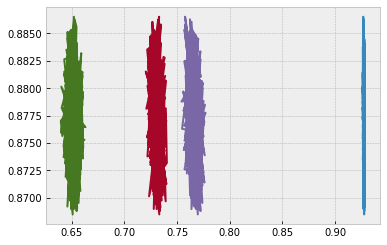

In [159]:
# p_~d, p_d1, p_d2, p_dboth for component 0
plt.plot(samples['probs'][:,order_h0_h1_h2_h12][:,:,0],best_weights_exp2[:, order_h0_h1_h2_h12][:,0])

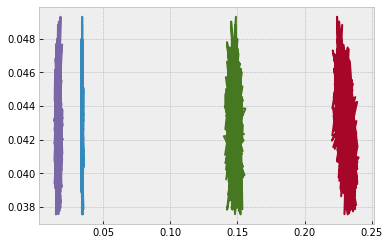

In [168]:
# p_~d, p_d1, p_d2, p_dboth for component 1
plt.plot(samples['probs'][:,order_h0_h1_h2_h12][:,:,1],best_weights_exp2[:, order_h0_h1_h2_h12][:,1])

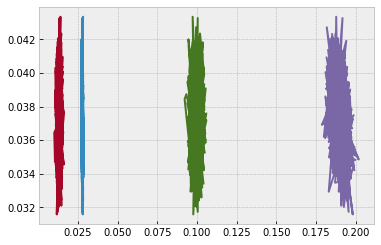

In [167]:
# p_~d, p_d1, p_d2, p_dboth for component 1
plt.plot(samples['probs'][:,order_h0_h1_h2_h12][:,:,2],best_weights_exp2[:, order_h0_h1_h2_h12][:,2])

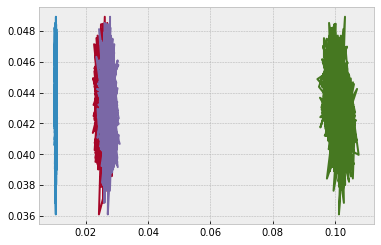

In [166]:
# p_~d, p_d1, p_d2, p_dboth for component 1
plt.plot(samples['probs'][:,order_h0_h1_h2_h12][:,:,3],best_weights_exp2[:, order_h0_h1_h2_h12][:,3])

In [ ]:
plt.plot(samples['probs'][:,order_h0_h1_h2_h12][:,0,0],best_weights_exp2[:, order_h0_h1_h2_h12][:,0])

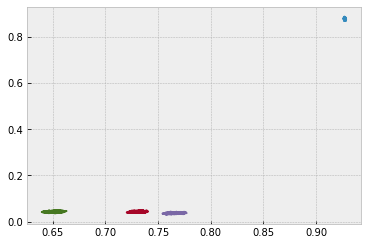

In [151]:
# pd_nb for all components
plt.plot(samples['probs'][:,order_h0_h1_h2_h12][:,:,0],best_weights_exp2[:, order_h0_h1_h2_h12])

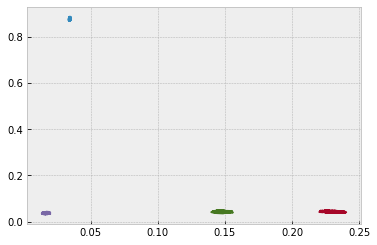

In [156]:
plt.plot(samples['probs'][:,order_h0_h1_h2_h12][:,:,1],best_weights_exp2[:, order_h0_h1_h2_h12])

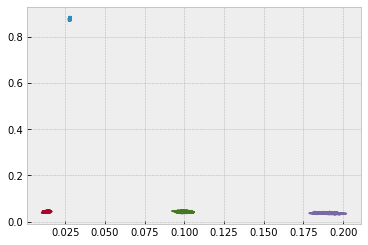

In [153]:
plt.plot(samples['probs'][:,order_h0_h1_h2_h12][:,:,2],best_weights_exp2[:, order_h0_h1_h2_h12])

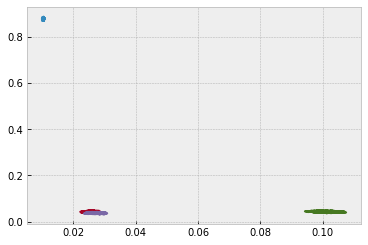

In [154]:
plt.plot(samples['probs'][:,order_h0_h1_h2_h12][:,:,3],best_weights_exp2[:, order_h0_h1_h2_h12])

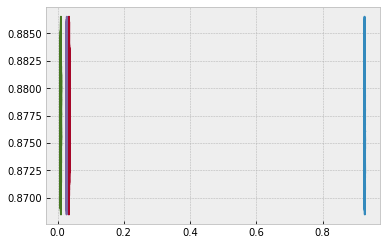

In [170]:
# p_~d, p_d1, p_d2, p_dboth for component 1
plt.plot(samples['probs'][:,order_h0_h1_h2_h12][:,0,:],best_weights_exp2[:, order_h0_h1_h2_h12][:,0])

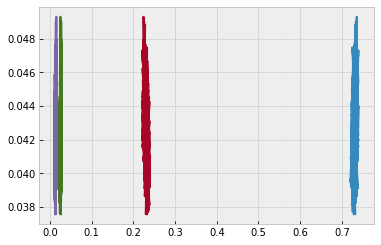

In [173]:
# p_~d, p_d1, p_d2, p_dboth for component 1
plt.plot(samples['probs'][:,order_h0_h1_h2_h12][:,1,:],best_weights_exp2[:, order_h0_h1_h2_h12][:,1])

In [135]:
probs = {}
for hypothesis_idx in range(4):
    if hypothesis_idx not in probs:
        probs[hypothesis_idx] = {}
    for p_dv_idx in range(4):
        if p_dv_idx not in probs[hypothesis_idx]:
            probs[hypothesis_idx][p_dv_idx] = []
        
        p_d_given_v_h = samples['probs'][:,order_h0_h1_h2_h12][:,hypothesis_idx,p_dv_idx]
        hpdi_stats = hpdi(p_d_given_v_h, .9)
        probs[hypothesis_idx][p_dv_idx]
        

    P_nd_V_H0 = samples['probs'][:,order_h0_h1_h2_h12][:,0]
    P_nd_V_H0 = samples['probs'][:,order_h0_h1_h2_h12][:,0]
    P_nd_V_H0 = samples['probs'][:,order_h0_h1_h2_h12][:,0]
    P_nd_V_H0 = samples['probs'][:,order_h0_h1_h2_h12][:,0]


DeviceArray([[0.9275263 , 0.03432675, 0.02792327, 0.01022369],
             [0.92707956, 0.03469067, 0.02777456, 0.01045521],
             [0.9272813 , 0.03454677, 0.02783929, 0.01033262],
             ...,
             [0.92716914, 0.0344954 , 0.02796934, 0.01036612],
             [0.92726016, 0.03445244, 0.02792071, 0.01036669],
             [0.9276856 , 0.0340923 , 0.02799015, 0.01023193]],            dtype=float32)

In [ ]:
# Samples appear completely deterministic
samples = best_chain_exp2.get_samples()
for i in range(samples['probs'].shape[0]):
    if i == 0:
        display(samples['probs'][i])
        continue
    
    # if samples['probs'][i][2,0] < .9:
    display(best_chain_exp2.get_samples()['probs'][i])
    
    if i > 50:
        break

In [117]:
posterior_predictive['probs'][0]

DeviceArray([[0.72568226, 0.23519295, 0.01324422, 0.02588057],
             [0.6523088 , 0.14729667, 0.09832198, 0.10207254],
             [0.9275263 , 0.03432675, 0.02792327, 0.01022369],
             [0.7613109 , 0.01861144, 0.19197743, 0.02810025]],            dtype=float32)

In [118]:
mix_weights(posterior_predictive['beta'][0])

DeviceArray([0.04364329, 0.04220336, 0.8789135 , 0.03523981], dtype=float32)

In [100]:
posterior_predictive['probs'][0]

DeviceArray([[0.72568226, 0.23519295, 0.01324422, 0.02588057],
             [0.6523088 , 0.14729667, 0.09832198, 0.10207254],
             [0.9275263 , 0.03432675, 0.02792327, 0.01022369],
             [0.7613109 , 0.01861144, 0.19197743, 0.02810025]],            dtype=float32)

In [101]:
posterior_predictive['probs'][1]

DeviceArray([[0.7336064 , 0.22812016, 0.01277715, 0.02549629],
             [0.6527414 , 0.14979699, 0.10052989, 0.09693173],
             [0.92707956, 0.03469067, 0.02777456, 0.01045521],
             [0.7659307 , 0.01586005, 0.19054848, 0.02766073]],            dtype=float32)

In [102]:
posterior_predictive['probs'][3]

DeviceArray([[0.73276544, 0.22766794, 0.01403597, 0.02553066],
             [0.6510268 , 0.1487257 , 0.09933935, 0.10090816],
             [0.92746776, 0.03443033, 0.02784079, 0.01026112],
             [0.76261264, 0.01787155, 0.19187863, 0.02763716]],            dtype=float32)

In [98]:
posterior_predictive.keys()

dict_keys(['beta', 'dirichlet_concentration', 'obs', 'probs', 'z'])

In [97]:
from typing import *
def get_assumed_order_for_2_predictive(predictive: Dict['str', np.ndarray], data_columns: List[str] = ['unaffected', 'affected1', 'affected2', 'affected12'], prevalences: np.ndarray = None, data: np.ndarray = None, ):
    """
    Infer the order of hypotheses for 2 conditions and 4 channels: ctrls, cases1, cases2, cases_both
    prevalences: Iterable[Union[int, float]]
        The list of prevalences for each of the condition columns (ex: ctrls, cases1, cases2, cases for both). Should be in the same order as the data columns
        The last element of the prevalences array should be comorbidity, if known
    """
    hypotheses = {}

    mapping= {
        'unaffected': 'P(~D|V,H)',
        'affected1': 'P(D1|V,H)',
        'affected2': 'P(D2|V,H)',
        'affected12': 'P(D12|V,H)'
    }
    
    probs_mean = predictive['probs']
    probs_mean = probs.mean(0)#round_it(probs.mean(0), 4)
    probs_mean_df = pd.DataFrame(probs_mean, dtype='float32', columns=[mapping[x] for x in data_columns])

    h0 = probs_mean_df['P(~D|V,H)'].idxmax()
    hypotheses[h0] = 'H0'
    h1 = (probs_mean_df['P(D1|V,H)'] - probs_mean_df['P(D2|V,H)']).idxmax() #(case1 > case2)
    hypotheses[h1] = 'H1'
    h2 = (probs_mean_df['P(D2|V,H)'] - probs_mean_df['P(D1|V,H)']).idxmax() #(case2 > case1)
    hypotheses[h2] = 'H2'
    h12 = (probs_mean_df['P(D12|V,H)']).idxmax()
    hypotheses[h12] = 'H12'

    probs_mean_df.index = [hypotheses[k] for k in probs_mean_df.index]
    
    return np.array([h0, h1, h2, h12]), probs_mean_df
get_assumed_order_for_2_predictive()

TypeError: get_assumed_order_for_2_predictive() missing 1 required positional argument: 'predictive'

In [ ]:
posterior_predictive['z'][0][0]

In [ ]:
posterior_predictive['probs'][0][0]

In [ ]:
weight = mix_weights(posterior_predictive['beta'][0])
weight

In [ ]:
posterior_predictive['probs'][0][0]

In [ ]:
df = df.drop(columns=['pred_Per_Gene_Counts_Unaffected_Unaffected', 'pred_Unaffected_Affected', 'pred_Affected_Unaffected', 'pred_Affected_Affected'])

In [ ]:
df.query('Affected_Affected > 3')

In [ ]:
from numpyro import handlers
from numpyro.distributions import *
with handlers.seed(rng_seed=0):  # random.PRNGKey(0) is used
    # for (weights, probs, conc) in get_statistics_permutations(mcmc_exp2_2_with_conc, 4):
    
        # mixing_dist = dist.Categorical(probs=weights.mean(1).mean(0))
#         display('posterior_predictive[\'probs\'][4]', posterior_predictive['probs'][4])
#         component_dist = dist.Multinomial(probs=posterior_predictive['probs'][4])

#         # mixture = dist.MixtureSameFamily(mixing_dist, component_dist)
#         display(df.values[13781])
#         display(component_dist.log_prob(df.values[13781]))
    random_key, _random_key = random.split(random_key)
    gamma_shape, gamma_rate = method_moments_estimator_gamma_shape_rate(df_exp2.values)
    print(gamma_shape)
    print(gamma_rate)
    display(Gamma(gamma_shape, gamma_rate).sample(key=random_key))
    # display(TransformedDistribution(Categorical(mix_weights(np.array([0.1437686 , 0.44246083 , 0.579667]))), transforms.OrderedTransform()).sample(key=random_key))

In [ ]:
posterior_predictive

In [ ]:
# this shows us we don't really predict genes consistently; are the chains flipping around?
list(stats.mode(posterior_predictive['z'])[0][0:200][0])

In [ ]:
df_exp2.drop(columns=['Mean Predictions']).values.std(0)

In [ ]:
df_exp2.shape

In [ ]:
gene_counts_posterior_pred_counts_mean[:,0]

In [ ]:
z_mode

In [ ]:
prior_predictions

In [ ]:
mean_prior_pred

In [ ]:
hpdi_prior_pred

In [ ]:
df.values

In [ ]:
random_key, _random_key = random.split(random_key)
predictive = Predictive(model, best_chain.get_samples())
samples_predictive = predictive(random.PRNGKey(1))
print(np.mean(samples_predictive['obs'])) 
posterior_samples = best_chain.get_samples()
predictive = Predictive(model, posterior_samples=posterior_samples)

In [ ]:
best_weights_exp2, best_probs_exp2, _, _ = get_parameters(best_chain_exp2)
best_weights_exp2.mean(0)

In [ ]:
H_exp2, mean_df_exp2 = get_assumed_order_for_2(best_probs_exp2, data_columns=['unaffected', 'affected2', 'affected1', 'affected12'], prevalences=pd_with_both_exp2)
mean_df_exp2

In [ ]:
# this looks correct in order
display('best_probs sample mean',best_probs_exp2.mean(0)[H_exp2])
display('best_probs sample mean', best_weights_exp2.mean(0)[H_exp2])


In [ ]:
print("H_exp2", H_exp2)

print("best_weights.mean(0)", best_weights_exp2.mean(0))

print("best_weights.mean(0)[H]", best_weights_exp2.mean(0)[H_exp2])


print("\nbest_probs.mean(0)", best_probs_exp2.mean(0))
print("best_probs.mean(0)[H]", best_probs_exp2.mean(0)[H_exp2])

PD_V_H_P_H_across_samples = np.multiply(best_probs_exp2, best_weights_exp2.reshape(*best_weights_exp2.shape,1))

PD_V_H_P_H_mean = PD_V_H_P_H_across_samples.mean(0)
print("\nPD_V_H_P_H_mean", PD_V_H_P_H_mean)
print("ordered PD|Vs based on H", PD_V_H_P_H_mean[H_exp2])
        
PD_V = PD_V_H_P_H_mean[H_exp2].sum(1)
display("PD|V", PD_V)
PD = pds_exp2
PV = q = 1e-4

rr = PD_V[1:4]/PD
display("rr",rr)

In [ ]:
best_probs_exp2.mean(0)[H_exp2][3,1:3]

In [ ]:
affects_both_penetrance = best_probs_exp2.mean(0)[H_exp2][2,1:3]
print(affects_both_penetrance)
P_D2_A1 = .4
P_D1_A1 = .75
print("P_D1_A1", P_D1_A1)
print("P_D2_A1", P_D2_A1)
q = 1e-4
p = 1-q

#Final Observed Prevalences for this study are (Disorder1,Disorder2,Both) = 0.022515,0.02302,0.001295
prevalence_d1 = pds_exp2[0]#.02
prevalence_d2 = pds_exp2[1]#PD[0] #.02
print('prevalence_d1', prevalence_d1, 'prevalence_d2', prevalence_d2)
thresh1 = Inv_Cumulative_Normal(prevalence_d1)
thresh2 = Inv_Cumulative_Normal(prevalence_d2)
print(f"thresh1: {thresh1}, thresh2: {thresh2}")

alpha1_D1 = thresh1 - Inv_Cumulative_Normal( 1- P_D1_A1)
print('alpha1_D1',alpha1_D1)
alpha1_D2 = thresh2 - Inv_Cumulative_Normal( 1- P_D2_A1)
print('alpha1_D2',alpha1_D2)

alpha2_D1 = -p*alpha1_D1/q
alpha2_D2 = -p*alpha1_D2/q
print('alpha2_D1',alpha2_D1)
print('alpha2_D2',alpha2_D2)


# 1) Convert to alpha1 and alpha2... noting that p*alpha1 = q*alpha2
# for each disorder for each gene.

# 2) The variance for this locus is

# 2*(p*alpha1^2 + q * alpha2^2)

# 3) The total variance for the category is the sum that thing above
# over all genes in the category.... that's the variance.

# 4) The covariance is probably

# 2(p*alpha1_1*alpha1_2 + q*alpha2_1*alpha2_2)

# where alpha1_1 and alpha1_2 is effects of A1 on phenotypes 1
# and phenotypes 2.

# The total covariance sums over all genes.
print('alpha1_D1**2', alpha1_D1**2)
print('alpha2_D1**2', alpha2_D1**2)
variance_D1 = 2*(p*(alpha1_D1**2) + q * (alpha2_D1**2))
variance_D2 = 2*(p*(alpha1_D2**2) + q * (alpha2_D2**2))
print(f"alpha2_D1: {alpha2_D1}, alpha2_D2: {alpha2_D2}")
print(f"variance_D1: {variance_D1}, variance_D2: {variance_D2}")
print('p*alpha1_D1*alpha1_D2 ', p*alpha1_D1*alpha1_D2 )
print('q*alpha2_D1*alpha2_D2', q*alpha2_D1*alpha2_D2)
cov = 2*(p*alpha1_D1*alpha1_D2 + q*alpha2_D1*alpha2_D2)
print(f"cov: {cov}")

rho = cov / ((variance_D1*variance_D2)**.5)
print(f"rho: {rho}")

In [ ]:
import numpyro.distributions as dist
# order doesn't matter for mixture models
with handlers.seed(rng_seed=0):  # random.PRNGKey(0) is used
    for (weights, probs, conc) in get_statistics_permutations(mcmc_exp2_2_with_conc, 4):

        mixing_dist = dist.Categorical(probs=weights.mean(1).mean(0))

        component_dist = dist.Multinomial(probs=probs.mean(1).mean(0))

        mixture = dist.MixtureSameFamily(mixing_dist, component_dist)

        res = mixture.log_prob(run_params_exp2_with_conc['data'])
        print("done:", res.sum())
        print(res)

We have 4 different categories of states
With probability pi_1 (disease 1 affected by gene), the gene affects disease 1. we have individuals affected by gene 1 with penetrance P(D|A1). Individuals affected by both also get P(D|A1), I think

With probability pi_2 (disease 2 affected by gene), the gene affects disease 2. we have individuals affected by disease 2 with penetrance P(D|A2). Individuals affected by both also get P(D|A2), I think

With probability pi_3, diseases 1 and 2 affected by the gene. Individuals with disease 1, 2, and both get P(D|ABoth), I think. 

I think we keep all penetrances independent.

I think that we actually get P(V|D1)?

In [ ]:
samples = np.array([n_ctrls, *n_cases])
sample_proportions = samples / samples.sum()
sample_proportions

penetrances = inferred_params_davec[0]['probs'].mean(0) / sample_proportions
print(penetrances)

# Dude this isn't penetrance! From  cureffi.org:
#P(D|A) = P(D) * P(A|D)/P(A)
# where p(A|D) = allele frequency in cases
# where P(A) is the allele frequency in population controls
# and
# penetrance = baseline risk * case allele frequency / population control allele frequency

# and the in-sample estimate of P(D) is the number of cases / total number of samples

# so when we get something like
# [[ 0.8134461   0.32360843  5.0985327   2.520728  ]
#  [ 1.0251557   0.75175786  0.7211326   1.0094681 ]
#  [ 0.80601496  5.306168    0.31114104  2.587026  ]
#  [ 0.69068795  2.8604672   2.904822   10.298759  ]]
# we can see that we've estimated say for component 2 that case allele frequency / population control allele frequency is larger
# penetrance = rr * P(D|~V) as well
# and P(D) = P(D|V)P(V) + P(D|~V)P(~V)
# population control allele frequency = P(A) = P(V|~D)

# P(D|V) / ( P(D|V)P(V) + P(D|~V)P(~V)) = P(V|D) / P(V|~D)

# P(V|D)P(D) = P(D|V)P(V)
# P(V|D) = P(D|V)P(V)/P(D)

# so my above calculation is close to P(V|D), off by the allele frequency

In [ ]:
# alpha1 = thres = Invs_Cumulative_Normal( 1 - Pv )
# Pv = prevalence of disease 1
# 0.04295 is prevalence of disease 1

# Why isn't this working?
samples = [n_ctrls, **n_cases]
d = dist.Normal(0, 1)

# for disease2 the penetrance should be the thing that is highest, after scaling by sample proportion I think for in
# we expect a pattern 
thresh1 = None
with numpyro.handlers.seed(rng_seed=0):  # random.PRNGKey(0) is used
    pd1 = .04295
    thresh1 = d.icdf(1-.04295)

    alpha1 = thresh1 - 

In [ ]:
stat_data_dave

# Prevalence of disease 1
# = 

concentration_a1 = inferred_params_davec[0]['concentrations'].mean(0)[0]

add_them = []
with numpyro.handlers.seed(rng_seed=0):  # random.PRNGKey(0) is used
    for i in range(20_000):
        prob = numpyro.sample(f'prob_gene_{i}', dist.Dirichlet(concentration_a1))
        add_them.append(prob)
        

        if i < 5:
            print(prob)

np.array(add_them).mean(0)
stat_data_dave.mean(0)

In [ ]:
# P(D|~V) = P(D|~V)P(~V)
# P(D) = Sum( P(D|V)P(V) ) over all V, which are the architectures (rare allele count sums)
# P(D|~V) this is prevalence as well? It can't be, must be 1 - sum (P(D|V)P(V)) over everything other than ~V, then / P(~V)
# P(V|D) = P(D|V)P(V) / P(D)
# pdv_pv_null = probs.mean(0)[selected_components]
# 
# alpha1 = freq(a1a1) * average(phenotype of a1a1 invididulal) + .5 * freq(a1a2) * average(phenotype of a1a2 individuals)/p

# alpha2 = -p * alpah1 / q
# alpha1 = thres - inv_cum_normal( 1 - P(D|A1))

# alpah2 = -p*alpha / q
# Variance due to locus is 2*(p*alpah1^2 + q*alpha2)

# For 2 phenotypes, you can calculate the alphas independently for the two traits based on the pentrance of the a1 allele for both traits (a1 allele here is a collection of rare alleles)

# penetrance is P(D|V), or here, P(D|A12) I think

multinomial_probs = probs.mean(0)[selected_components]
multinomial_probs
# The probability at a locus in P(D|V) = P(V|D)P(D)/P(V)
# dv_pv_one = probs.mean(1)[selected_components]
# dv_pv_other = probs.mean(2)[selected_components]
# dv_pv_both = probs.mean(3)[selected_components]
# dv_pv_both
null = multinomial_probs[0,:]
print('null', null)
a1 = multinomial_probs[1,:]
print('a1', a1)
a2 = multinomial_probs[2,:]
print("a2", a2)
a12 = multinomial_probs[3,:]
print("a12", a12)

# these are the proportions of genes that are configured in each way
# are these P(D)? are these P(V)?
# Well, the full likelihood is P(D) = P(D|V)P(V) + P(D2|V)(P|V) + P(D12|V)P(V) right? or is P(V|D)

print("pis", weights.mean(0))

In [ ]:
# 0.00010000000000000002
print('(stat_data_dave/ (200_000 * 2)).mean(0).sum()', (stat_data_dave/ (200_000 * 2)).mean(0).sum())

# array([8.954125e-05, 4.332250e-06, 4.232625e-06, 1.893875e-06])
# These are P(V|D) and P(D) is pi?
# No, I think these are P(V|D)P(D) so that their sum, is P(V)
(stat_data_dave/ (200_000 * 2)).mean(0)

In [ ]:
# Ok, let's assume that this is true, then P(V|D)P(D) summed is P(V)
# well, since null * 1e-4 gives numbers very close to N*2, it's probably P(D|V)
# So we are estimating penetrance
print('null * 1e-4: ', (null * 1e-4).sum())
# If so then this is P(D|V)P(V); then pi is P(H1 (H1 affects disease 1)), and maybe the P(V) P(D|V) means probability of disease given the variat affects disease 1 (It's really P(D|V,H1))

# Dave wrote that alphas can be calculated based on the penetrance of the a1 allele for both traits
# we estimate the penetrance of the a1 allele for both traits in the a12 component
#alpha1 = thres - inv_cum_normal( 1 - P(D|A1))
# assuming he means A12, let's use a12, which is P(D|a12)
# I think it may be more appropriate to just recognize that P(D|A1) = P(D|A1, H1)P(H1) + P(D|A1, H12)P(H12)
penetrance_d1_given_a1 = a1 * weights[1]
print('penetrance_d1_given_a1', penetrance_d1_given_a1)

penetrance_d1_given_a1_smear = a1 * (weights[1] / weights.sum()) + a12 * (weights[3] / weights.sum())
print('penetrance_d1_given_a1_smear', penetrance_d1_given_a1_smear)
print('weights shape', weights.shape)
print("probs.shape", probs.shape)
print('probs[0]', probs[0])
full_smear2 = (probs * weights).mean(0)
print("full_smear", full_smear2)

# P(D1|V) = P(D1|V1)P(V1) + P()
# I don't know if it's the 2nd entry, or 2nd + 4th that's needed
# Let's just say it's P(D1|V)
penetrance_d1_smear = full_smear2[1][1]
print('penetrance_d1_smear', penetrance_d1_smear)

penetrance_d1 = a1[1]
print(penetrance_d1)

In [ ]:
from mvl2.numpyro import mix_weights

beta = inferred_params_dave[0]['beta']

weights = mix_weights(beta)
# shape is (1001, 50)
print(weights.shape)

# shape is (50, )
print(weights.mean(0).shape)

selected_components = weights.mean(0) >= 9e-3
selected_components
print(weights.mean(0)[selected_components].sort()[::-1])
print(np.nonzero(selected_components))

selected_probs = mcmc_dave.get_samples()['probs'][:, selected_components, :]


component1 = selected_probs[:, :, :]
print(pd_with_both)
component1.mean(0)

probs = inferred_params_dave[0]['probs']
print(probs.mean(0)[selected_components])
# (3001, 100)
# (100,)
# [0.79759234 0.07203006 0.05195475 0.02510345 0.02443778 0.01053052
#  0.0054377 ]]
# 100 components infers as well, roughly as 50. But now 2 extra components, not 1

In [ ]:
from typing import List

def read_shit(path) -> List[float]:
    prevalences = None
    headers = None
    params = []
    with open(path, 'r') as f:
        for line in f:
            if line.startswith('Args are: '):
                headers = line.strip().split('Args are: ')[1].split(',')
            elif line.startswith('Args val: '):
                for val in line.strip().split('Args val: ')[1].split(','):
                    try:
                        params.append(float(val))
                    except:
                        params.append(val)
            elif line.startswith('Final Observed Prevalences for this study are (Disorder1,Disorder2,Both) = '):
                prevalences = list(map(float, line.split('Final Observed Prevalences for this study are (Disorder1,Disorder2,Both) = ')[1].strip().split(',')))

    return prevalences, dict(zip(headers, params))